> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [2]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [48]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32, name="D_a")#tf.Variable([1.0], dtype=tf.float32, 
                                   #name="D_a", 
                                   #constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.constant(0.0, dtype=tf.float32, name="sigma_a")#tf.Variable([0.0], dtype=tf.float32)#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.constant(0.02, dtype=tf.float32, name="rho_s")#tf.Variable([1.00], dtype=tf.float32, 
                                     #name="rho_s",
                                    #constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))#tf.constant(0.25, dtype=tf.float32)#

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        
        #self.loss_params = tf.math.abs(1e-8/(self.D_s + 1e-16), name="D_s_inv") + \
        #                   tf.math.abs(1e-8/(self.sigma_s + 1e-16), name="sigma_s_inv") + \
        #                   tf.math.abs(1e-8/(self.mu_a + 1e-16), name="mu_a_inv") + \
        #                   tf.math.abs(1e-8/(self.rho_a + 1e-16), name="rho_a_inv") + \
        #                   tf.math.abs(1e-8/(self.kappa_a + 1e-16), name="kappa_a_inv")   
        
        #self.loss_no_zero_a = tf.math.abs(1e-1/(tf.reduce_mean(self.a_pred) + 1e-16), name="a_pred_inv")
        #self.loss_no_zero_1 = tf.math.abs(1e-1/(tf.reduce_mean(self.s_pred) + 1e-16), name="s_pred_inv")

        self.loss = self.loss_1 + 100*self.loss_a + 100*self.loss_s #+ \
                     #self.loss_no_zero_a + self.loss_no_zero_1
                    #self.loss_params + self.loss_no_zero_a + self.loss_no_zero_1

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_t_temp = tf.identity(a_t, name="temp_a_t")
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        a_diff_temp = tf.identity(a_xx + a_yy, name="temp_a_diff")
        
        s_t = tf.gradients(s, t, name="s_t")[0]
        s_t_temp = tf.identity(s_t, name="temp_s_t")
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        s_diff_temp = tf.identity(s_xx + s_yy, name="temp_s_diff")
        
        f = a*a*s/(1 + kappa_a*a*a)
        kin_temp = tf.identity(f, name="temp_kin")
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train(self, nIter, early_stop_thresh = None, print_iter = 100): 
        
        

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100): 
        
        

        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]

                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss.tolist()},\n"                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()

            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]

                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss.tolist()},\n"
                      f"D_a: {D_a_value.tolist()}, D_s: {D_s_value.tolist()}\n"
                      f"sigma_a: {sigma_a_value.tolist()}, sigma_s: {sigma_s_value.tolist()}\n"
                      f"rho_a: {rho_a_value.tolist()}, rho_s: {rho_s_value.tolist()}\n"
                      f"mu_a: {mu_a_value.tolist()}, kappa_a: {kappa_a_value.tolist()}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break    
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a, self.D_s,
                                          self.sigma_a, self.sigma_s,
                                          self.rho_a, self.rho_s,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [49]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [50]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
model.train_batch(20000, batch_size=N*T//32, early_stop_thresh=10.0, print_iter=100)

It: 0, loss_a  : 13.21907073, loss_s  : 31688.86602783, loss  : 3235414.0625,
D_a: 0.004999999888241291, D_s: [1.0349104404449463]
sigma_a: 0.0, sigma_s: [0.9680920839309692]
rho_a: [1.009461522102356], rho_s: 0.019999999552965164
mu_a: [0.9832454919815063], kappa_a: [0.9955205917358398], 
Time:5.41

It: 100, loss_a  : 0.26341923, loss_s  : 0.16422692, loss  : 9560.21957397461,
D_a: 0.004999999888241291, D_s: [2.4603874683380127]
sigma_a: 0.0, sigma_s: [0.01506826002150774]
rho_a: [0.5613216161727905], rho_s: 0.019999999552965164
mu_a: [0.4039037525653839], kappa_a: [0.7666855454444885], 
Time:296.27

It: 200, loss_a  : 1.38310294, loss_s  : 0.47893708, loss  : 8536.942398071289,
D_a: 0.004999999888241291, D_s: [2.4475486278533936]
sigma_a: 0.0, sigma_s: [0.01300891675055027]
rho_a: [0.5174010396003723], rho_s: 0.019999999552965164
mu_a: [0.3506692945957184], kappa_a: [0.8617448210716248], 
Time:305.85

It: 300, loss_a  : 1.36081869, loss_s  : 0.55153899, loss  : 3061.917022705078,
D_a

In [70]:
model.train_batch(20000, batch_size=N*T//32, early_stop_thresh=5.0, print_iter=100)

It: 0, loss_a  : 0.00430596, loss_s  : 0.02292887, loss  : 9.684628248214722,
D_a: 0.004999999888241291, D_s: [0.1820322871208191]
sigma_a: 0.0, sigma_s: [0.017921674996614456]
rho_a: [0.011306206695735455], rho_s: 0.019999999552965164
mu_a: [0.010132205672562122], kappa_a: [0.3416576385498047], 
Time:2.44

It: 100, loss_a  : 0.00421982, loss_s  : 0.02221287, loss  : 11.325310081243515,
D_a: 0.004999999888241291, D_s: [0.1849375218153]
sigma_a: 0.0, sigma_s: [0.01805533654987812]
rho_a: [0.011159971356391907], rho_s: 0.019999999552965164
mu_a: [0.010118957608938217], kappa_a: [0.33430880308151245], 
Time:236.56

It: 200, loss_a  : 0.00351244, loss_s  : 0.02069406, loss  : 14.021243929862976,
D_a: 0.004999999888241291, D_s: [0.18704082071781158]
sigma_a: 0.0, sigma_s: [0.018355071544647217]
rho_a: [0.01110701821744442], rho_s: 0.019999999552965164
mu_a: [0.010076037608087063], kappa_a: [0.32793745398521423], 
Time:240.12

It: 300, loss_a  : 0.00363604, loss_s  : 0.02135221, loss  : 14.0

In [82]:
model.train_batch(20000, batch_size=N*T//32, early_stop_thresh=2.0, print_iter=100)

It: 0, loss_a  : 0.01387872, loss_s  : 0.09618250, loss  : 157.36378173530102,
D_a: 0.004999999888241291, D_s: [0.19719983637332916]
sigma_a: 0.0, sigma_s: [0.01887470856308937]
rho_a: [0.009454985149204731], rho_s: 0.019999999552965164
mu_a: [0.008985375985503197], kappa_a: [0.29798775911331177], 
Time:2.41

It: 100, loss_a  : 0.00187717, loss_s  : 0.01024603, loss  : 9.399052269756794,
D_a: 0.004999999888241291, D_s: [0.19965100288391113]
sigma_a: 0.0, sigma_s: [0.01902751252055168]
rho_a: [0.010298575274646282], rho_s: 0.019999999552965164
mu_a: [0.00984430592507124], kappa_a: [0.28804638981819153], 
Time:248.87

It: 200, loss_a  : 0.00158481, loss_s  : 0.00925475, loss  : 8.588498324155807,
D_a: 0.004999999888241291, D_s: [0.2000458836555481]
sigma_a: 0.0, sigma_s: [0.019150739535689354]
rho_a: [0.010368532501161098], rho_s: 0.019999999552965164
mu_a: [0.009869108907878399], kappa_a: [0.28732848167419434], 
Time:272.06

It: 300, loss_a  : 0.00181512, loss_s  : 0.00835146, loss  : 5

In [91]:
model.minimise(max_iter=500)  

loss: 1.5525434017181396, loss_a: 0.0009905907791107893, loss_s: 0.003921558149158955,
D_a: 0.004999999888241291, D_s: [0.203571155667305]
sigma_a: 0.0, sigma_s: [0.01935015618801117]
rho_a: [0.010171180590987206], rho_s: 0.019999999552965164
mu_a: [0.009812367148697376], kappa_a: [0.2772844731807709]

loss: 21505294.0, loss_a: 201783.375, loss_s: 1858.3878173828125,
D_a: 0.004999999888241291, D_s: [0.211056649684906]
sigma_a: 0.0, sigma_s: [0.2031390517950058]
rho_a: [-0.37790969014167786], rho_s: 0.019999999552965164
mu_a: [0.3931581377983093], kappa_a: [0.2880364656448364]

loss: 85635.9375, loss_a: 58.83689880371094, loss_s: 103.90324401855469,
D_a: 0.004999999888241291, D_s: [0.2052389681339264]
sigma_a: 0.0, sigma_s: [0.06029945984482765]
rho_a: [-0.0762956440448761], rho_s: 0.019999999552965164
mu_a: [0.09522418677806854], kappa_a: [0.279680073261261]

loss: 1.5603892803192139, loss_a: 0.0013163581024855375, loss_s: 0.003935478162020445,
D_a: 0.004999999888241291, D_s: [0.203572

loss: 1.3368186950683594, loss_a: 0.0009431233629584312, loss_s: 0.0038125074934214354,
D_a: 0.004999999888241291, D_s: [0.20356838405132294]
sigma_a: 0.0, sigma_s: [0.019349675625562668]
rho_a: [0.010171796195209026], rho_s: 0.019999999552965164
mu_a: [0.009839599020779133], kappa_a: [0.27722498774528503]

loss: 1.3353604078292847, loss_a: 0.0009425942553207278, loss_s: 0.0038097379729151726,
D_a: 0.004999999888241291, D_s: [0.20356222987174988]
sigma_a: 0.0, sigma_s: [0.019350016489624977]
rho_a: [0.010171206668019295], rho_s: 0.019999999552965164
mu_a: [0.009839114733040333], kappa_a: [0.2772141396999359]

loss: 1.3329906463623047, loss_a: 0.0009414716623723507, loss_s: 0.0038041286170482635,
D_a: 0.004999999888241291, D_s: [0.20355454087257385]
sigma_a: 0.0, sigma_s: [0.019350457936525345]
rho_a: [0.0101693170145154], rho_s: 0.019999999552965164
mu_a: [0.00983729213476181], kappa_a: [0.27719223499298096]

loss: 1.3327805995941162, loss_a: 0.000940795405767858, loss_s: 0.00379820330

loss: 1.3207707405090332, loss_a: 0.0009298591176047921, loss_s: 0.0037647204007953405,
D_a: 0.004999999888241291, D_s: [0.20382605493068695]
sigma_a: 0.0, sigma_s: [0.019365258514881134]
rho_a: [0.010150148533284664], rho_s: 0.019999999552965164
mu_a: [0.009825904853641987], kappa_a: [0.2765038311481476]

loss: 1.3206026554107666, loss_a: 0.0009298902587033808, loss_s: 0.003764403983950615,
D_a: 0.004999999888241291, D_s: [0.20382867753505707]
sigma_a: 0.0, sigma_s: [0.01936534233391285]
rho_a: [0.010149892419576645], rho_s: 0.019999999552965164
mu_a: [0.009825684130191803], kappa_a: [0.27649909257888794]

loss: 1.3202043771743774, loss_a: 0.0009293073089793324, loss_s: 0.003763234941288829,
D_a: 0.004999999888241291, D_s: [0.20385417342185974]
sigma_a: 0.0, sigma_s: [0.019366594031453133]
rho_a: [0.010147994384169579], rho_s: 0.019999999552965164
mu_a: [0.009824471548199654], kappa_a: [0.2764458656311035]

loss: 1.3197017908096313, loss_a: 0.0009279737714678049, loss_s: 0.00376131571

loss: 1.3170745372772217, loss_a: 0.0009187345276586711, loss_s: 0.003754593897610903,
D_a: 0.004999999888241291, D_s: [0.2041684240102768]
sigma_a: 0.0, sigma_s: [0.019387388601899147]
rho_a: [0.0101221464574337], rho_s: 0.019999999552965164
mu_a: [0.009809833019971848], kappa_a: [0.2755662798881531]

loss: 1.3169541358947754, loss_a: 0.0009182415087707341, loss_s: 0.0037549210246652365,
D_a: 0.004999999888241291, D_s: [0.20417790114879608]
sigma_a: 0.0, sigma_s: [0.019388481974601746]
rho_a: [0.010120579041540623], rho_s: 0.019999999552965164
mu_a: [0.009809587150812149], kappa_a: [0.2755303680896759]

loss: 1.316860556602478, loss_a: 0.000917779456358403, loss_s: 0.0037551927380263805,
D_a: 0.004999999888241291, D_s: [0.20418940484523773]
sigma_a: 0.0, sigma_s: [0.019389133900403976]
rho_a: [0.0101193031296134], rho_s: 0.019999999552965164
mu_a: [0.009808901697397232], kappa_a: [0.2754943370819092]

loss: 1.3165936470031738, loss_a: 0.0009167183306999505, loss_s: 0.00375575781799852

loss: 1.3114864826202393, loss_a: 0.0008933148346841335, loss_s: 0.0037545126397162676,
D_a: 0.004999999888241291, D_s: [0.20484864711761475]
sigma_a: 0.0, sigma_s: [0.01943492330610752]
rho_a: [0.01006442029029131], rho_s: 0.019999999552965164
mu_a: [0.009778822772204876], kappa_a: [0.27346786856651306]

loss: 1.310930609703064, loss_a: 0.0008907112060114741, loss_s: 0.003754621371626854,
D_a: 0.004999999888241291, D_s: [0.20490966737270355]
sigma_a: 0.0, sigma_s: [0.019441474229097366]
rho_a: [0.010058140382170677], rho_s: 0.019999999552965164
mu_a: [0.009775977581739426], kappa_a: [0.27320581674575806]

loss: 1.3108477592468262, loss_a: 0.0008864701958373189, loss_s: 0.0037542865611612797,
D_a: 0.004999999888241291, D_s: [0.20499666035175323]
sigma_a: 0.0, sigma_s: [0.019448786973953247]
rho_a: [0.010048200376331806], rho_s: 0.019999999552965164
mu_a: [0.009770380333065987], kappa_a: [0.272821843624115]

loss: 1.310282826423645, loss_a: 0.0008873556507751346, loss_s: 0.0037539147306

loss: 1.3064959049224854, loss_a: 0.0008725395891815424, loss_s: 0.0037549755070358515,
D_a: 0.004999999888241291, D_s: [0.20551469922065735]
sigma_a: 0.0, sigma_s: [0.01948314718902111]
rho_a: [0.010010046884417534], rho_s: 0.019999999552965164
mu_a: [0.009750555269420147], kappa_a: [0.2715160548686981]

loss: 1.306383490562439, loss_a: 0.0008714883588254452, loss_s: 0.003755213227123022,
D_a: 0.004999999888241291, D_s: [0.20555509626865387]
sigma_a: 0.0, sigma_s: [0.019483627751469612]
rho_a: [0.010008938610553741], rho_s: 0.019999999552965164
mu_a: [0.009748534299433231], kappa_a: [0.27139705419540405]

loss: 1.3062695264816284, loss_a: 0.0008712352719157934, loss_s: 0.003755501937121153,
D_a: 0.004999999888241291, D_s: [0.205560103058815]
sigma_a: 0.0, sigma_s: [0.019484415650367737]
rho_a: [0.010007997043430805], rho_s: 0.019999999552965164
mu_a: [0.009748588316142559], kappa_a: [0.27138546109199524]

loss: 1.3061587810516357, loss_a: 0.0008706293301656842, loss_s: 0.0037560635246

loss: 1.3011436462402344, loss_a: 0.000849610660225153, loss_s: 0.003757451195269823,
D_a: 0.004999999888241291, D_s: [0.20616747438907623]
sigma_a: 0.0, sigma_s: [0.019532252103090286]
rho_a: [0.009948994033038616], rho_s: 0.019999999552965164
mu_a: [0.009717841632664204], kappa_a: [0.26927950978279114]

loss: 1.3008688688278198, loss_a: 0.0008491676417179406, loss_s: 0.0037567366380244493,
D_a: 0.004999999888241291, D_s: [0.20617707073688507]
sigma_a: 0.0, sigma_s: [0.01953267492353916]
rho_a: [0.009946919046342373], rho_s: 0.019999999552965164
mu_a: [0.009715904481709003], kappa_a: [0.2692394256591797]

loss: 1.3004746437072754, loss_a: 0.0008478547097183764, loss_s: 0.0037556320894509554,
D_a: 0.004999999888241291, D_s: [0.20621073246002197]
sigma_a: 0.0, sigma_s: [0.019535722211003304]
rho_a: [0.009941861033439636], rho_s: 0.019999999552965164
mu_a: [0.00971188209950924], kappa_a: [0.26911085844039917]

loss: 1.3001705408096313, loss_a: 0.0008467247243970633, loss_s: 0.00375484814

loss: 1.2952396869659424, loss_a: 0.0008386113913729787, loss_s: 0.0037371977232396603,
D_a: 0.004999999888241291, D_s: [0.20646436512470245]
sigma_a: 0.0, sigma_s: [0.0195627361536026]
rho_a: [0.009910001419484615], rho_s: 0.019999999552965164
mu_a: [0.009692339226603508], kappa_a: [0.2680358290672302]

loss: 1.2949192523956299, loss_a: 0.0008378427010029554, loss_s: 0.0037381527945399284,
D_a: 0.004999999888241291, D_s: [0.20650403201580048]
sigma_a: 0.0, sigma_s: [0.019564252346754074]
rho_a: [0.009906085208058357], rho_s: 0.019999999552965164
mu_a: [0.009690729901194572], kappa_a: [0.26791590452194214]

loss: 1.2947334051132202, loss_a: 0.000837542291264981, loss_s: 0.003738625906407833,
D_a: 0.004999999888241291, D_s: [0.206515833735466]
sigma_a: 0.0, sigma_s: [0.019565913826227188]
rho_a: [0.009904972277581692], rho_s: 0.019999999552965164
mu_a: [0.009690370410680771], kappa_a: [0.2678817808628082]

loss: 1.2945241928100586, loss_a: 0.0008366303518414497, loss_s: 0.00373916304670

loss: 1.2875189781188965, loss_a: 0.000819886103272438, loss_s: 0.0037166946567595005,
D_a: 0.004999999888241291, D_s: [0.2072843611240387]
sigma_a: 0.0, sigma_s: [0.019609369337558746]
rho_a: [0.009849600493907928], rho_s: 0.019999999552965164
mu_a: [0.009656312875449657], kappa_a: [0.2660539448261261]

loss: 1.287064552307129, loss_a: 0.0008197820861823857, loss_s: 0.003715725615620613,
D_a: 0.004999999888241291, D_s: [0.20730069279670715]
sigma_a: 0.0, sigma_s: [0.01961156725883484]
rho_a: [0.009845953434705734], rho_s: 0.019999999552965164
mu_a: [0.009654655121266842], kappa_a: [0.2660074234008789]

loss: 1.2868479490280151, loss_a: 0.0008200695738196373, loss_s: 0.003715221071615815,
D_a: 0.004999999888241291, D_s: [0.20729199051856995]
sigma_a: 0.0, sigma_s: [0.019611062481999397]
rho_a: [0.009846333414316177], rho_s: 0.019999999552965164
mu_a: [0.009654869325459003], kappa_a: [0.2660256624221802]

loss: 1.2864954471588135, loss_a: 0.0008203474571928382, loss_s: 0.003713257377967

loss: 1.2812583446502686, loss_a: 0.0008170549990609288, loss_s: 0.003687504678964615,
D_a: 0.004999999888241291, D_s: [0.2073623239994049]
sigma_a: 0.0, sigma_s: [0.019614949822425842]
rho_a: [0.009843860752880573], rho_s: 0.019999999552965164
mu_a: [0.009653497487306595], kappa_a: [0.26586616039276123]

loss: 1.281052589416504, loss_a: 0.000816970132291317, loss_s: 0.0036866827867925167,
D_a: 0.004999999888241291, D_s: [0.20737433433532715]
sigma_a: 0.0, sigma_s: [0.01961495913565159]
rho_a: [0.00984279252588749], rho_s: 0.019999999552965164
mu_a: [0.00965261273086071], kappa_a: [0.26585653424263]

loss: 1.2806870937347412, loss_a: 0.0008167690830305219, loss_s: 0.0036845868453383446,
D_a: 0.004999999888241291, D_s: [0.20739342272281647]
sigma_a: 0.0, sigma_s: [0.019614677876234055]
rho_a: [0.009840465150773525], rho_s: 0.019999999552965164
mu_a: [0.009650622494518757], kappa_a: [0.2658207416534424]

loss: 1.280408263206482, loss_a: 0.000816738058347255, loss_s: 0.003682210110127926,

loss: 1.2738431692123413, loss_a: 0.0008051850600168109, loss_s: 0.00365213630720973,
D_a: 0.004999999888241291, D_s: [0.20779502391815186]
sigma_a: 0.0, sigma_s: [0.019644731655716896]
rho_a: [0.00980315264314413], rho_s: 0.019999999552965164
mu_a: [0.00963111687451601], kappa_a: [0.264540433883667]

loss: 1.2735750675201416, loss_a: 0.0008060071850195527, loss_s: 0.0036488373298197985,
D_a: 0.004999999888241291, D_s: [0.20779545605182648]
sigma_a: 0.0, sigma_s: [0.01964893750846386]
rho_a: [0.00980603601783514], rho_s: 0.019999999552965164
mu_a: [0.009635558351874352], kappa_a: [0.2645624577999115]

loss: 1.27289879322052, loss_a: 0.000805768184363842, loss_s: 0.0036463155411183834,
D_a: 0.004999999888241291, D_s: [0.20779956877231598]
sigma_a: 0.0, sigma_s: [0.019643589854240417]
rho_a: [0.009808892384171486], rho_s: 0.019999999552965164
mu_a: [0.009635786525905132], kappa_a: [0.2646084725856781]

loss: 1.2726707458496094, loss_a: 0.0008057727245613933, loss_s: 0.0036461735144257545

loss: 1.266850233078003, loss_a: 0.0007999895024113357, loss_s: 0.0036184596829116344,
D_a: 0.004999999888241291, D_s: [0.20792976021766663]
sigma_a: 0.0, sigma_s: [0.019658220931887627]
rho_a: [0.009789797477424145], rho_s: 0.019999999552965164
mu_a: [0.009623870253562927], kappa_a: [0.26400625705718994]

loss: 1.2665919065475464, loss_a: 0.0007999161025509238, loss_s: 0.0036176005378365517,
D_a: 0.004999999888241291, D_s: [0.20794221758842468]
sigma_a: 0.0, sigma_s: [0.01965760439634323]
rho_a: [0.009790359064936638], rho_s: 0.019999999552965164
mu_a: [0.009624003432691097], kappa_a: [0.2639766037464142]

loss: 1.2664604187011719, loss_a: 0.0007999651716090739, loss_s: 0.0036171572282910347,
D_a: 0.004999999888241291, D_s: [0.20794609189033508]
sigma_a: 0.0, sigma_s: [0.0196574404835701]
rho_a: [0.009790411219000816], rho_s: 0.019999999552965164
mu_a: [0.009623777121305466], kappa_a: [0.263971209526062]

loss: 1.2661536931991577, loss_a: 0.0008000059169717133, loss_s: 0.0036160796880

loss: 1.2587699890136719, loss_a: 0.000794930150732398, loss_s: 0.003582138568162918,
D_a: 0.004999999888241291, D_s: [0.2080884724855423]
sigma_a: 0.0, sigma_s: [0.019665276631712914]
rho_a: [0.009777831844985485], rho_s: 0.019999999552965164
mu_a: [0.009615709073841572], kappa_a: [0.2636755704879761]

loss: 1.2583763599395752, loss_a: 0.0007941279327496886, loss_s: 0.003579346928745508,
D_a: 0.004999999888241291, D_s: [0.20810575783252716]
sigma_a: 0.0, sigma_s: [0.019668353721499443]
rho_a: [0.009777738712728024], rho_s: 0.019999999552965164
mu_a: [0.009615625254809856], kappa_a: [0.2635924518108368]

loss: 1.2581137418746948, loss_a: 0.000793982355389744, loss_s: 0.0035774200223386288,
D_a: 0.004999999888241291, D_s: [0.20809626579284668]
sigma_a: 0.0, sigma_s: [0.01966598629951477]
rho_a: [0.009779253043234348], rho_s: 0.019999999552965164
mu_a: [0.009618259035050869], kappa_a: [0.2636120021343231]

loss: 1.2579137086868286, loss_a: 0.0007939436472952366, loss_s: 0.003576672170311

loss: 1.251620888710022, loss_a: 0.000795513391494751, loss_s: 0.0035420204512774944,
D_a: 0.004999999888241291, D_s: [0.20793688297271729]
sigma_a: 0.0, sigma_s: [0.01965281367301941]
rho_a: [0.00979497842490673], rho_s: 0.019999999552965164
mu_a: [0.00962584838271141], kappa_a: [0.2641759514808655]

loss: 1.2514185905456543, loss_a: 0.0007956274203024805, loss_s: 0.003541196696460247,
D_a: 0.004999999888241291, D_s: [0.20793026685714722]
sigma_a: 0.0, sigma_s: [0.019653456285595894]
rho_a: [0.009795911610126495], rho_s: 0.019999999552965164
mu_a: [0.009626583196222782], kappa_a: [0.26418206095695496]

loss: 1.2510558366775513, loss_a: 0.0007960264338180423, loss_s: 0.0035392811987549067,
D_a: 0.004999999888241291, D_s: [0.20790459215641022]
sigma_a: 0.0, sigma_s: [0.019653383642435074]
rho_a: [0.009797923266887665], rho_s: 0.019999999552965164
mu_a: [0.009628194384276867], kappa_a: [0.26423510909080505]

loss: 1.2507963180541992, loss_a: 0.0007961009396240115, loss_s: 0.0035373051650

loss: 1.2439632415771484, loss_a: 0.0007910042768344283, loss_s: 0.0034974743612110615,
D_a: 0.004999999888241291, D_s: [0.20793044567108154]
sigma_a: 0.0, sigma_s: [0.01965889148414135]
rho_a: [0.009786124341189861], rho_s: 0.019999999552965164
mu_a: [0.009619581513106823], kappa_a: [0.26395174860954285]

loss: 1.2451589107513428, loss_a: 0.0007911963621154428, loss_s: 0.0034912279807031155,
D_a: 0.004999999888241291, D_s: [0.20792512595653534]
sigma_a: 0.0, sigma_s: [0.019660061225295067]
rho_a: [0.009786933660507202], rho_s: 0.019999999552965164
mu_a: [0.009621026925742626], kappa_a: [0.26397785544395447]

loss: 1.2437365055084229, loss_a: 0.0007910300046205521, loss_s: 0.003495356533676386,
D_a: 0.004999999888241291, D_s: [0.20792891085147858]
sigma_a: 0.0, sigma_s: [0.01965922676026821]
rho_a: [0.00978635624051094], rho_s: 0.019999999552965164
mu_a: [0.009619995951652527], kappa_a: [0.26395922899246216]

loss: 1.243277907371521, loss_a: 0.0007906301179900765, loss_s: 0.00349319074

loss: 1.2355332374572754, loss_a: 0.000786358374170959, loss_s: 0.0034570966381579638,
D_a: 0.004999999888241291, D_s: [0.2081477791070938]
sigma_a: 0.0, sigma_s: [0.019673600792884827]
rho_a: [0.009767952375113964], rho_s: 0.019999999552965164
mu_a: [0.009608842432498932], kappa_a: [0.2632972300052643]

loss: 1.2353591918945312, loss_a: 0.0007862796192057431, loss_s: 0.003456447273492813,
D_a: 0.004999999888241291, D_s: [0.20815055072307587]
sigma_a: 0.0, sigma_s: [0.019673418253660202]
rho_a: [0.009768044576048851], rho_s: 0.019999999552965164
mu_a: [0.009608381427824497], kappa_a: [0.2633121907711029]

loss: 1.2349978685379028, loss_a: 0.0007863853243179619, loss_s: 0.003454997204244137,
D_a: 0.004999999888241291, D_s: [0.20814953744411469]
sigma_a: 0.0, sigma_s: [0.019673017784953117]
rho_a: [0.009767910465598106], rho_s: 0.019999999552965164
mu_a: [0.009608076885342598], kappa_a: [0.26333799958229065]

loss: 1.2349269390106201, loss_a: 0.0007864266517572105, loss_s: 0.003453963901

loss: 1.2282215356826782, loss_a: 0.0007810167735442519, loss_s: 0.0034208018332719803,
D_a: 0.004999999888241291, D_s: [0.20831893384456635]
sigma_a: 0.0, sigma_s: [0.01968059316277504]
rho_a: [0.00975096970796585], rho_s: 0.019999999552965164
mu_a: [0.009597796946763992], kappa_a: [0.2629278004169464]

loss: 1.2278847694396973, loss_a: 0.0007811191026121378, loss_s: 0.003419178770855069,
D_a: 0.004999999888241291, D_s: [0.20831310749053955]
sigma_a: 0.0, sigma_s: [0.019679252058267593]
rho_a: [0.009751112200319767], rho_s: 0.019999999552965164
mu_a: [0.009597433730959892], kappa_a: [0.2629793584346771]

loss: 1.2271472215652466, loss_a: 0.0007816404104232788, loss_s: 0.0034155710600316525,
D_a: 0.004999999888241291, D_s: [0.20829787850379944]
sigma_a: 0.0, sigma_s: [0.019675886258482933]
rho_a: [0.009751377627253532], rho_s: 0.019999999552965164
mu_a: [0.009596184827387333], kappa_a: [0.2631126344203949]

loss: 1.234684944152832, loss_a: 0.0007840766338631511, loss_s: 0.0034166947007

loss: 1.22024405002594, loss_a: 0.000778607907705009, loss_s: 0.0033726259134709835,
D_a: 0.004999999888241291, D_s: [0.20833097398281097]
sigma_a: 0.0, sigma_s: [0.019681576639413834]
rho_a: [0.009741959162056446], rho_s: 0.019999999552965164
mu_a: [0.009587129577994347], kappa_a: [0.26291075348854065]

loss: 1.2199931144714355, loss_a: 0.0007782138418406248, loss_s: 0.0033709504641592503,
D_a: 0.004999999888241291, D_s: [0.20833620429039001]
sigma_a: 0.0, sigma_s: [0.019681883975863457]
rho_a: [0.009740706533193588], rho_s: 0.019999999552965164
mu_a: [0.00958727765828371], kappa_a: [0.2628915309906006]

loss: 1.2197905778884888, loss_a: 0.0007779131410643458, loss_s: 0.0033693257719278336,
D_a: 0.004999999888241291, D_s: [0.20834104716777802]
sigma_a: 0.0, sigma_s: [0.019685378298163414]
rho_a: [0.009740276262164116], rho_s: 0.019999999552965164
mu_a: [0.009585535153746605], kappa_a: [0.26287513971328735]

loss: 1.2196046113967896, loss_a: 0.0007784095942042768, loss_s: 0.00336733972

loss: 1.2138550281524658, loss_a: 0.0007797760190442204, loss_s: 0.0033402799163013697,
D_a: 0.004999999888241291, D_s: [0.20825506746768951]
sigma_a: 0.0, sigma_s: [0.019674742594361305]
rho_a: [0.009757773019373417], rho_s: 0.019999999552965164
mu_a: [0.009600073099136353], kappa_a: [0.26321250200271606]

loss: 1.2136822938919067, loss_a: 0.0007797914440743625, loss_s: 0.003339204238727689,
D_a: 0.004999999888241291, D_s: [0.20825935900211334]
sigma_a: 0.0, sigma_s: [0.019674478098750114]
rho_a: [0.009757048450410366], rho_s: 0.019999999552965164
mu_a: [0.009599232114851475], kappa_a: [0.2632075548171997]

loss: 1.2133164405822754, loss_a: 0.0007798635633662343, loss_s: 0.003336705733090639,
D_a: 0.004999999888241291, D_s: [0.20826706290245056]
sigma_a: 0.0, sigma_s: [0.01967509090900421]
rho_a: [0.009755429811775684], rho_s: 0.019999999552965164
mu_a: [0.009596518240869045], kappa_a: [0.2632039189338684]

loss: 1.2133631706237793, loss_a: 0.0007798512233421206, loss_s: 0.00333295203

loss: 1.2052149772644043, loss_a: 0.0007798400474712253, loss_s: 0.0032938080839812756,
D_a: 0.004999999888241291, D_s: [0.20804357528686523]
sigma_a: 0.0, sigma_s: [0.019664879888296127]
rho_a: [0.009770015254616737], rho_s: 0.019999999552965164
mu_a: [0.009607532992959023], kappa_a: [0.26375314593315125]

loss: 1.2060226202011108, loss_a: 0.0007822868647053838, loss_s: 0.0032923459075391293,
D_a: 0.004999999888241291, D_s: [0.20800742506980896]
sigma_a: 0.0, sigma_s: [0.019658606499433517]
rho_a: [0.009772464632987976], rho_s: 0.019999999552965164
mu_a: [0.009598561562597752], kappa_a: [0.26395589113235474]

loss: 1.2050106525421143, loss_a: 0.0007798710139468312, loss_s: 0.0032929484732449055,
D_a: 0.004999999888241291, D_s: [0.20803231000900269]
sigma_a: 0.0, sigma_s: [0.019662925973534584]
rho_a: [0.009770778007805347], rho_s: 0.019999999552965164
mu_a: [0.009604739025235176], kappa_a: [0.2638162672519684]

loss: 1.2047405242919922, loss_a: 0.000780039990786463, loss_s: 0.00329225

loss: 1.198119044303894, loss_a: 0.0007821543840691447, loss_s: 0.0032639470882713795,
D_a: 0.004999999888241291, D_s: [0.20777581632137299]
sigma_a: 0.0, sigma_s: [0.019648434594273567]
rho_a: [0.009798324666917324], rho_s: 0.019999999552965164
mu_a: [0.009625550359487534], kappa_a: [0.26453647017478943]

loss: 1.1986931562423706, loss_a: 0.0007836661534383893, loss_s: 0.003262931713834405,
D_a: 0.004999999888241291, D_s: [0.20778153836727142]
sigma_a: 0.0, sigma_s: [0.019635291770100594]
rho_a: [0.009799657389521599], rho_s: 0.019999999552965164
mu_a: [0.009619508869946003], kappa_a: [0.2646436095237732]

loss: 1.1979092359542847, loss_a: 0.0007824065978638828, loss_s: 0.00326285557821393,
D_a: 0.004999999888241291, D_s: [0.20777776837348938]
sigma_a: 0.0, sigma_s: [0.01964395120739937]
rho_a: [0.009798779152333736], rho_s: 0.019999999552965164
mu_a: [0.00962348934262991], kappa_a: [0.26457300782203674]

loss: 1.1974599361419678, loss_a: 0.0007827029330655932, loss_s: 0.0032617689575

In [93]:
model.minimise(max_iter=5000)  

loss: 1.1944512128829956, loss_a: 0.0007827932713553309, loss_s: 0.003244002116844058,
D_a: 0.004999999888241291, D_s: [0.20782023668289185]
sigma_a: 0.0, sigma_s: [0.019643886014819145]
rho_a: [0.009785152040421963], rho_s: 0.019999999552965164
mu_a: [0.009609696455299854], kappa_a: [0.26466596126556396]

loss: 5655080.5, loss_a: 50886.8828125, loss_s: 900.884033203125,
D_a: 0.004999999888241291, D_s: [0.13147936761379242]
sigma_a: 0.0, sigma_s: [0.2682848572731018]
rho_a: [0.20773997902870178], rho_s: 0.019999999552965164
mu_a: [-0.11532517522573471], kappa_a: [0.22835852205753326]

loss: 56262.296875, loss_a: 139.80763244628906, loss_s: 130.47557067871094,
D_a: 0.004999999888241291, D_s: [0.19021552801132202]
sigma_a: 0.0, sigma_s: [0.07698214799165726]
rho_a: [0.05543484911322594], rho_s: 0.019999999552965164
mu_a: [-0.019201114773750305], kappa_a: [0.25629323720932007]

loss: 1.1944217681884766, loss_a: 0.0007828002562746406, loss_s: 0.0032439762726426125,
D_a: 0.00499999988824129

loss: 1.1909476518630981, loss_a: 0.0007832710980437696, loss_s: 0.003230819944292307,
D_a: 0.004999999888241291, D_s: [0.20774829387664795]
sigma_a: 0.0, sigma_s: [0.019646035507321358]
rho_a: [0.009788848459720612], rho_s: 0.019999999552965164
mu_a: [0.009614145383238792], kappa_a: [0.2645871937274933]

loss: 1.1907631158828735, loss_a: 0.0007832839619368315, loss_s: 0.003229954047128558,
D_a: 0.004999999888241291, D_s: [0.20775075256824493]
sigma_a: 0.0, sigma_s: [0.01964632049202919]
rho_a: [0.009787297807633877], rho_s: 0.019999999552965164
mu_a: [0.009612449444830418], kappa_a: [0.26458311080932617]

loss: 1.1904760599136353, loss_a: 0.0007832252886146307, loss_s: 0.0032285074703395367,
D_a: 0.004999999888241291, D_s: [0.20775434374809265]
sigma_a: 0.0, sigma_s: [0.01964651420712471]
rho_a: [0.00978526845574379], rho_s: 0.019999999552965164
mu_a: [0.009610427543520927], kappa_a: [0.26457464694976807]

loss: 1.1902002096176147, loss_a: 0.000783161201979965, loss_s: 0.0032260688021

loss: 1.1829017400741577, loss_a: 0.0007799506420269608, loss_s: 0.0031990862917155027,
D_a: 0.004999999888241291, D_s: [0.20793434977531433]
sigma_a: 0.0, sigma_s: [0.01965240016579628]
rho_a: [0.009783169254660606], rho_s: 0.019999999552965164
mu_a: [0.009613251313567162], kappa_a: [0.26420044898986816]

loss: 1.1826742887496948, loss_a: 0.000779947848059237, loss_s: 0.003197308862581849,
D_a: 0.004999999888241291, D_s: [0.20794062316417694]
sigma_a: 0.0, sigma_s: [0.019657094031572342]
rho_a: [0.009783808141946793], rho_s: 0.019999999552965164
mu_a: [0.009610855020582676], kappa_a: [0.2641478478908539]

loss: 1.1823762655258179, loss_a: 0.0007795881247147918, loss_s: 0.003195645520463586,
D_a: 0.004999999888241291, D_s: [0.20795144140720367]
sigma_a: 0.0, sigma_s: [0.019652750343084335]
rho_a: [0.00977620854973793], rho_s: 0.019999999552965164
mu_a: [0.009610108099877834], kappa_a: [0.2641226351261139]

loss: 1.1821616888046265, loss_a: 0.0007794405682943761, loss_s: 0.0031958238687

loss: 1.1789500713348389, loss_a: 0.0007781189051456749, loss_s: 0.0031862996984273195,
D_a: 0.004999999888241291, D_s: [0.2080383598804474]
sigma_a: 0.0, sigma_s: [0.019660377874970436]
rho_a: [0.009774836711585522], rho_s: 0.019999999552965164
mu_a: [0.009608793072402477], kappa_a: [0.26389601826667786]

loss: 1.1786530017852783, loss_a: 0.000777923094574362, loss_s: 0.0031858901493251324,
D_a: 0.004999999888241291, D_s: [0.20805390179157257]
sigma_a: 0.0, sigma_s: [0.01966170221567154]
rho_a: [0.009773805737495422], rho_s: 0.019999999552965164
mu_a: [0.009608080610632896], kappa_a: [0.263851523399353]

loss: 1.178450107574463, loss_a: 0.0007778658764436841, loss_s: 0.0031860503368079662,
D_a: 0.004999999888241291, D_s: [0.20805294811725616]
sigma_a: 0.0, sigma_s: [0.019662000238895416]
rho_a: [0.009771750308573246], rho_s: 0.019999999552965164
mu_a: [0.009606998413801193], kappa_a: [0.26383593678474426]

loss: 1.1782867908477783, loss_a: 0.0007779469597153366, loss_s: 0.003185917623

loss: 1.1713159084320068, loss_a: 0.0007736691040918231, loss_s: 0.003165659960359335,
D_a: 0.004999999888241291, D_s: [0.20825418829917908]
sigma_a: 0.0, sigma_s: [0.019677363336086273]
rho_a: [0.009764972142875195], rho_s: 0.019999999552965164
mu_a: [0.009608668275177479], kappa_a: [0.2632046043872833]

loss: 1.171161413192749, loss_a: 0.0007738735876046121, loss_s: 0.0031661055982112885,
D_a: 0.004999999888241291, D_s: [0.20826388895511627]
sigma_a: 0.0, sigma_s: [0.019675899296998978]
rho_a: [0.009765071794390678], rho_s: 0.019999999552965164
mu_a: [0.009612931869924068], kappa_a: [0.2631540596485138]

loss: 1.170776128768921, loss_a: 0.0007729237549938262, loss_s: 0.0031654597260057926,
D_a: 0.004999999888241291, D_s: [0.20826773345470428]
sigma_a: 0.0, sigma_s: [0.019679157063364983]
rho_a: [0.009764451533555984], rho_s: 0.019999999552965164
mu_a: [0.009607668034732342], kappa_a: [0.2631497085094452]

loss: 1.1706594228744507, loss_a: 0.0007731050718575716, loss_s: 0.003165170084

loss: 1.1670947074890137, loss_a: 0.0007717658299952745, loss_s: 0.003158142324537039,
D_a: 0.004999999888241291, D_s: [0.20838654041290283]
sigma_a: 0.0, sigma_s: [0.019686227664351463]
rho_a: [0.009752647019922733], rho_s: 0.019999999552965164
mu_a: [0.00959973968565464], kappa_a: [0.26281827688217163]

loss: 1.1668180227279663, loss_a: 0.0007714803796261549, loss_s: 0.0031581567600369453,
D_a: 0.004999999888241291, D_s: [0.20837710797786713]
sigma_a: 0.0, sigma_s: [0.01968669518828392]
rho_a: [0.009750006720423698], rho_s: 0.019999999552965164
mu_a: [0.009598379954695702], kappa_a: [0.26279035210609436]

loss: 1.1666513681411743, loss_a: 0.0007712965016253293, loss_s: 0.0031574214808642864,
D_a: 0.004999999888241291, D_s: [0.20837314426898956]
sigma_a: 0.0, sigma_s: [0.019687289372086525]
rho_a: [0.009750137105584145], rho_s: 0.019999999552965164
mu_a: [0.009598132222890854], kappa_a: [0.2627926170825958]

loss: 1.1664894819259644, loss_a: 0.0007714692619629204, loss_s: 0.0031567683

loss: 1.1616020202636719, loss_a: 0.0007698157569393516, loss_s: 0.003151408163830638,
D_a: 0.004999999888241291, D_s: [0.20852002501487732]
sigma_a: 0.0, sigma_s: [0.019694481045007706]
rho_a: [0.009736348874866962], rho_s: 0.019999999552965164
mu_a: [0.009587466716766357], kappa_a: [0.26248931884765625]

loss: 1.1626124382019043, loss_a: 0.0007726901676505804, loss_s: 0.0031549122650176287,
D_a: 0.004999999888241291, D_s: [0.2085447609424591]
sigma_a: 0.0, sigma_s: [0.019689323380589485]
rho_a: [0.009735453873872757], rho_s: 0.019999999552965164
mu_a: [0.00959539320319891], kappa_a: [0.26243719458580017]

loss: 1.1615822315216064, loss_a: 0.0007698456756770611, loss_s: 0.0031515778973698616,
D_a: 0.004999999888241291, D_s: [0.2085229903459549]
sigma_a: 0.0, sigma_s: [0.01969386450946331]
rho_a: [0.009736241772770882], rho_s: 0.019999999552965164
mu_a: [0.009588414803147316], kappa_a: [0.26248306035995483]

loss: 1.1615170240402222, loss_a: 0.0007699152920395136, loss_s: 0.00315166357

loss: 1.1586501598358154, loss_a: 0.0007706303731538355, loss_s: 0.003144260495901108,
D_a: 0.004999999888241291, D_s: [0.20853282511234283]
sigma_a: 0.0, sigma_s: [0.019697075709700584]
rho_a: [0.009736863896250725], rho_s: 0.019999999552965164
mu_a: [0.009591417387127876], kappa_a: [0.2623913586139679]

loss: 1.1584866046905518, loss_a: 0.0007706405594944954, loss_s: 0.003143856767565012,
D_a: 0.004999999888241291, D_s: [0.2085290402173996]
sigma_a: 0.0, sigma_s: [0.019696811214089394]
rho_a: [0.009736288338899612], rho_s: 0.019999999552965164
mu_a: [0.00958987046033144], kappa_a: [0.2623913884162903]

loss: 1.1583300828933716, loss_a: 0.0007707225158810616, loss_s: 0.0031434567645192146,
D_a: 0.004999999888241291, D_s: [0.20852267742156982]
sigma_a: 0.0, sigma_s: [0.019696785137057304]
rho_a: [0.009735739789903164], rho_s: 0.019999999552965164
mu_a: [0.009588481858372688], kappa_a: [0.2623918652534485]

loss: 1.1582388877868652, loss_a: 0.0007707393378950655, loss_s: 0.0031434406992

loss: 1.153228998184204, loss_a: 0.0007694850210100412, loss_s: 0.0031338147819042206,
D_a: 0.004999999888241291, D_s: [0.2085803896188736]
sigma_a: 0.0, sigma_s: [0.019699541851878166]
rho_a: [0.009735705330967903], rho_s: 0.019999999552965164
mu_a: [0.009590023197233677], kappa_a: [0.2623108923435211]

loss: 1.1528186798095703, loss_a: 0.0007693739607930183, loss_s: 0.003134043887257576,
D_a: 0.004999999888241291, D_s: [0.20858196914196014]
sigma_a: 0.0, sigma_s: [0.019700387492775917]
rho_a: [0.00973279494792223], rho_s: 0.019999999552965164
mu_a: [0.009586677886545658], kappa_a: [0.26228851079940796]

loss: 1.152526617050171, loss_a: 0.0007695324602536857, loss_s: 0.003133692080155015,
D_a: 0.004999999888241291, D_s: [0.20858979225158691]
sigma_a: 0.0, sigma_s: [0.019700776785612106]
rho_a: [0.009736181236803532], rho_s: 0.019999999552965164
mu_a: [0.009590452536940575], kappa_a: [0.262287437915802]

loss: 1.1524935960769653, loss_a: 0.0007701563299633563, loss_s: 0.003134295344352

loss: 1.1501777172088623, loss_a: 0.0007699527777731419, loss_s: 0.0031322897411882877,
D_a: 0.004999999888241291, D_s: [0.20855766534805298]
sigma_a: 0.0, sigma_s: [0.01969907619059086]
rho_a: [0.009731984697282314], rho_s: 0.019999999552965164
mu_a: [0.009584729559719563], kappa_a: [0.2623695135116577]

loss: 1.150080680847168, loss_a: 0.0007700683199800551, loss_s: 0.0031325053423643112,
D_a: 0.004999999888241291, D_s: [0.20855188369750977]
sigma_a: 0.0, sigma_s: [0.019699588418006897]
rho_a: [0.009733154438436031], rho_s: 0.019999999552965164
mu_a: [0.009585545398294926], kappa_a: [0.2623651623725891]

loss: 1.1499143838882446, loss_a: 0.0007701028953306377, loss_s: 0.003132519545033574,
D_a: 0.004999999888241291, D_s: [0.20853665471076965]
sigma_a: 0.0, sigma_s: [0.01969979703426361]
rho_a: [0.009734945371747017], rho_s: 0.019999999552965164
mu_a: [0.009587766602635384], kappa_a: [0.26237380504608154]

loss: 1.149843454360962, loss_a: 0.0007707046461291611, loss_s: 0.0031343116424

loss: 1.1459752321243286, loss_a: 0.0007707258919253945, loss_s: 0.0031283474527299404,
D_a: 0.004999999888241291, D_s: [0.2084529846906662]
sigma_a: 0.0, sigma_s: [0.01969100907444954]
rho_a: [0.00975301954895258], rho_s: 0.019999999552965164
mu_a: [0.009602692909538746], kappa_a: [0.26270952820777893]

loss: 1.1458052396774292, loss_a: 0.0007710690260864794, loss_s: 0.003126951167359948,
D_a: 0.004999999888241291, D_s: [0.20844215154647827]
sigma_a: 0.0, sigma_s: [0.019689761102199554]
rho_a: [0.009751331992447376], rho_s: 0.019999999552965164
mu_a: [0.009600162506103516], kappa_a: [0.26272907853126526]

loss: 1.1455590724945068, loss_a: 0.0007710466161370277, loss_s: 0.0031265676952898502,
D_a: 0.004999999888241291, D_s: [0.20843935012817383]
sigma_a: 0.0, sigma_s: [0.019689783453941345]
rho_a: [0.00975240208208561], rho_s: 0.019999999552965164
mu_a: [0.00960097648203373], kappa_a: [0.2627549171447754]

loss: 1.1452667713165283, loss_a: 0.0007712700753472745, loss_s: 0.0031258733943

loss: 1.1422685384750366, loss_a: 0.0007767553324811161, loss_s: 0.003114809514954686,
D_a: 0.004999999888241291, D_s: [0.20813655853271484]
sigma_a: 0.0, sigma_s: [0.019670803099870682]
rho_a: [0.009779048152267933], rho_s: 0.019999999552965164
mu_a: [0.009617026895284653], kappa_a: [0.2635355293750763]

loss: 1.1421728134155273, loss_a: 0.0007767408387735486, loss_s: 0.00311407377012074,
D_a: 0.004999999888241291, D_s: [0.20813876390457153]
sigma_a: 0.0, sigma_s: [0.01967027224600315]
rho_a: [0.00977847445756197], rho_s: 0.019999999552965164
mu_a: [0.009617301635444164], kappa_a: [0.26353248953819275]

loss: 1.1421009302139282, loss_a: 0.0007768032373860478, loss_s: 0.003113219514489174,
D_a: 0.004999999888241291, D_s: [0.20813849568367004]
sigma_a: 0.0, sigma_s: [0.019670242443680763]
rho_a: [0.009778028354048729], rho_s: 0.019999999552965164
mu_a: [0.009617263451218605], kappa_a: [0.26353663206100464]

loss: 1.1420096158981323, loss_a: 0.0007769037620164454, loss_s: 0.0031126914545

loss: 1.1377826929092407, loss_a: 0.0007836802396923304, loss_s: 0.0031010068487375975,
D_a: 0.004999999888241291, D_s: [0.2078622728586197]
sigma_a: 0.0, sigma_s: [0.019646476954221725]
rho_a: [0.0098030436784029], rho_s: 0.019999999552965164
mu_a: [0.009632489643990993], kappa_a: [0.2644934058189392]

loss: 1.1374211311340332, loss_a: 0.0007833237759768963, loss_s: 0.003100211266428232,
D_a: 0.004999999888241291, D_s: [0.20785896480083466]
sigma_a: 0.0, sigma_s: [0.01964694634079933]
rho_a: [0.009803887456655502], rho_s: 0.019999999552965164
mu_a: [0.009631600230932236], kappa_a: [0.2644807994365692]

loss: 1.1372982263565063, loss_a: 0.0007831641705706716, loss_s: 0.0030999791342765093,
D_a: 0.004999999888241291, D_s: [0.2078578621149063]
sigma_a: 0.0, sigma_s: [0.019646991044282913]
rho_a: [0.009803439490497112], rho_s: 0.019999999552965164
mu_a: [0.00963075552135706], kappa_a: [0.264466255903244]

loss: 1.1371569633483887, loss_a: 0.0007831518305465579, loss_s: 0.00309953116811811

loss: 1.134230375289917, loss_a: 0.0007875441806390882, loss_s: 0.003086208365857601,
D_a: 0.004999999888241291, D_s: [0.20757052302360535]
sigma_a: 0.0, sigma_s: [0.01962563395500183]
rho_a: [0.009829667396843433], rho_s: 0.019999999552965164
mu_a: [0.00964653491973877], kappa_a: [0.2653163969516754]

loss: 1.1340559720993042, loss_a: 0.000787892029620707, loss_s: 0.003085830481722951,
D_a: 0.004999999888241291, D_s: [0.2075527012348175]
sigma_a: 0.0, sigma_s: [0.019624603912234306]
rho_a: [0.00983172096312046], rho_s: 0.019999999552965164
mu_a: [0.00964802410453558], kappa_a: [0.2653656005859375]

loss: 1.1338222026824951, loss_a: 0.0007890796405263245, loss_s: 0.0030853981152176857,
D_a: 0.004999999888241291, D_s: [0.20748309791088104]
sigma_a: 0.0, sigma_s: [0.019617052748799324]
rho_a: [0.009837726131081581], rho_s: 0.019999999552965164
mu_a: [0.009653158485889435], kappa_a: [0.26556137204170227]

loss: 1.1339941024780273, loss_a: 0.0007906975224614143, loss_s: 0.00308514060452580

loss: 1.1301124095916748, loss_a: 0.0007973101455718279, loss_s: 0.0030681947246193886,
D_a: 0.004999999888241291, D_s: [0.207152858376503]
sigma_a: 0.0, sigma_s: [0.019596824422478676]
rho_a: [0.00986970029771328], rho_s: 0.019999999552965164
mu_a: [0.00967081356793642], kappa_a: [0.2666052281856537]

loss: 1.1299943923950195, loss_a: 0.0007976586930453777, loss_s: 0.003068043850362301,
D_a: 0.004999999888241291, D_s: [0.20713680982589722]
sigma_a: 0.0, sigma_s: [0.019596444442868233]
rho_a: [0.009869415313005447], rho_s: 0.019999999552965164
mu_a: [0.009670006111264229], kappa_a: [0.26664313673973083]

loss: 1.1298487186431885, loss_a: 0.0007981091039255261, loss_s: 0.003067906480282545,
D_a: 0.004999999888241291, D_s: [0.2071150541305542]
sigma_a: 0.0, sigma_s: [0.019595226272940636]
rho_a: [0.009868992492556572], rho_s: 0.019999999552965164
mu_a: [0.009668668732047081], kappa_a: [0.26670098304748535]

loss: 1.1296815872192383, loss_a: 0.0007988085853867233, loss_s: 0.00306758517399

loss: 1.1273555755615234, loss_a: 0.0008037916850298643, loss_s: 0.003060384886339307,
D_a: 0.004999999888241291, D_s: [0.2068442404270172]
sigma_a: 0.0, sigma_s: [0.01957397349178791]
rho_a: [0.009899605996906757], rho_s: 0.019999999552965164
mu_a: [0.00968883279711008], kappa_a: [0.2675628066062927]

loss: 1.127198576927185, loss_a: 0.0008040543179959059, loss_s: 0.003059962298721075,
D_a: 0.004999999888241291, D_s: [0.20682981610298157]
sigma_a: 0.0, sigma_s: [0.01957218535244465]
rho_a: [0.009898965246975422], rho_s: 0.019999999552965164
mu_a: [0.009687226265668869], kappa_a: [0.2676156759262085]

loss: 1.127659797668457, loss_a: 0.0008060079999268055, loss_s: 0.0030608417000621557,
D_a: 0.004999999888241291, D_s: [0.20680201053619385]
sigma_a: 0.0, sigma_s: [0.019574491307139397]
rho_a: [0.009892378002405167], rho_s: 0.019999999552965164
mu_a: [0.009683595038950443], kappa_a: [0.2676876187324524]

loss: 1.1271384954452515, loss_a: 0.0008043674170039594, loss_s: 0.00305993249639868

loss: 1.1241681575775146, loss_a: 0.000811403151601553, loss_s: 0.0030438879039138556,
D_a: 0.004999999888241291, D_s: [0.20653977990150452]
sigma_a: 0.0, sigma_s: [0.019550949335098267]
rho_a: [0.009924630634486675], rho_s: 0.019999999552965164
mu_a: [0.009702171199023724], kappa_a: [0.26848989725112915]

loss: 1.1240909099578857, loss_a: 0.0008115023374557495, loss_s: 0.0030434357468038797,
D_a: 0.004999999888241291, D_s: [0.20653598010540009]
sigma_a: 0.0, sigma_s: [0.019550727680325508]
rho_a: [0.009923340752720833], rho_s: 0.019999999552965164
mu_a: [0.009700844995677471], kappa_a: [0.2685018479824066]

loss: 1.1240596771240234, loss_a: 0.0008118011755868793, loss_s: 0.0030426778830587864,
D_a: 0.004999999888241291, D_s: [0.20651985704898834]
sigma_a: 0.0, sigma_s: [0.019551167264580727]
rho_a: [0.009920562617480755], rho_s: 0.019999999552965164
mu_a: [0.009697276167571545], kappa_a: [0.26854878664016724]

loss: 1.123862862586975, loss_a: 0.0008119515259750187, loss_s: 0.003041944

loss: 1.1212904453277588, loss_a: 0.0008164843311533332, loss_s: 0.0030368734151124954,
D_a: 0.004999999888241291, D_s: [0.20635353028774261]
sigma_a: 0.0, sigma_s: [0.019537879154086113]
rho_a: [0.009937318041920662], rho_s: 0.019999999552965164
mu_a: [0.009707809425890446], kappa_a: [0.2690679430961609]

loss: 1.1211965084075928, loss_a: 0.0008163463789969683, loss_s: 0.0030363972764462233,
D_a: 0.004999999888241291, D_s: [0.20636072754859924]
sigma_a: 0.0, sigma_s: [0.019537171348929405]
rho_a: [0.009934463538229465], rho_s: 0.019999999552965164
mu_a: [0.009704756550490856], kappa_a: [0.2690502107143402]

loss: 1.1210882663726807, loss_a: 0.0008167080814018846, loss_s: 0.0030359961092472076,
D_a: 0.004999999888241291, D_s: [0.20635733008384705]
sigma_a: 0.0, sigma_s: [0.019537173211574554]
rho_a: [0.009933707304298878], rho_s: 0.019999999552965164
mu_a: [0.0097043476998806], kappa_a: [0.269087016582489]

loss: 1.1209501028060913, loss_a: 0.0008167227497324347, loss_s: 0.003035878762

loss: 1.1181731224060059, loss_a: 0.0008182726451195776, loss_s: 0.0030294531024992466,
D_a: 0.004999999888241291, D_s: [0.2062646895647049]
sigma_a: 0.0, sigma_s: [0.019529907032847404]
rho_a: [0.009943018667399883], rho_s: 0.019999999552965164
mu_a: [0.009708564728498459], kappa_a: [0.26938602328300476]

loss: 1.1180830001831055, loss_a: 0.000818207859992981, loss_s: 0.0030295902397483587,
D_a: 0.004999999888241291, D_s: [0.20626603066921234]
sigma_a: 0.0, sigma_s: [0.01952994056046009]
rho_a: [0.00994260236620903], rho_s: 0.019999999552965164
mu_a: [0.009708595462143421], kappa_a: [0.26938438415527344]

loss: 1.1179373264312744, loss_a: 0.0008182077435776591, loss_s: 0.0030296482145786285,
D_a: 0.004999999888241291, D_s: [0.20626617968082428]
sigma_a: 0.0, sigma_s: [0.019529707729816437]
rho_a: [0.00994169432669878], rho_s: 0.019999999552965164
mu_a: [0.009707982651889324], kappa_a: [0.26938578486442566]

loss: 1.117760419845581, loss_a: 0.0008182869059965014, loss_s: 0.003029504325

loss: 1.112947702407837, loss_a: 0.0008176811970770359, loss_s: 0.003019549883902073,
D_a: 0.004999999888241291, D_s: [0.2062416970729828]
sigma_a: 0.0, sigma_s: [0.019530560821294785]
rho_a: [0.009941096417605877], rho_s: 0.019999999552965164
mu_a: [0.009709195233881474], kappa_a: [0.2693289816379547]

loss: 1.1127302646636963, loss_a: 0.0008176460396498442, loss_s: 0.0030192825943231583,
D_a: 0.004999999888241291, D_s: [0.20624549686908722]
sigma_a: 0.0, sigma_s: [0.019531255587935448]
rho_a: [0.009939217008650303], rho_s: 0.019999999552965164
mu_a: [0.009705894626677036], kappa_a: [0.26933127641677856]

loss: 1.1126214265823364, loss_a: 0.0008177129202522337, loss_s: 0.0030190199613571167,
D_a: 0.004999999888241291, D_s: [0.2062450498342514]
sigma_a: 0.0, sigma_s: [0.01953195594251156]
rho_a: [0.009939021430909634], rho_s: 0.019999999552965164
mu_a: [0.00970514863729477], kappa_a: [0.2693358361721039]

loss: 1.112438440322876, loss_a: 0.0008178302668966353, loss_s: 0.003018404822796

loss: 1.107553243637085, loss_a: 0.0008176946430467069, loss_s: 0.0029993122443556786,
D_a: 0.004999999888241291, D_s: [0.2062172144651413]
sigma_a: 0.0, sigma_s: [0.01952943205833435]
rho_a: [0.009956653229892254], rho_s: 0.019999999552965164
mu_a: [0.009721211157739162], kappa_a: [0.2694825232028961]

loss: 1.1073312759399414, loss_a: 0.0008179830620065331, loss_s: 0.0029984707944095135,
D_a: 0.004999999888241291, D_s: [0.20621700584888458]
sigma_a: 0.0, sigma_s: [0.01952805556356907]
rho_a: [0.009954552166163921], rho_s: 0.019999999552965164
mu_a: [0.009719242341816425], kappa_a: [0.2695031464099884]

loss: 1.1070665121078491, loss_a: 0.0008182791643776, loss_s: 0.0029976237565279007,
D_a: 0.004999999888241291, D_s: [0.20621982216835022]
sigma_a: 0.0, sigma_s: [0.01952706091105938]
rho_a: [0.009951762855052948], rho_s: 0.019999999552965164
mu_a: [0.009716412983834743], kappa_a: [0.26951348781585693]

loss: 1.1067254543304443, loss_a: 0.0008184873731806874, loss_s: 0.0029970221221446

loss: 1.0997968912124634, loss_a: 0.0008092664647847414, loss_s: 0.002977381693199277,
D_a: 0.004999999888241291, D_s: [0.20651334524154663]
sigma_a: 0.0, sigma_s: [0.0195472314953804]
rho_a: [0.009910502471029758], rho_s: 0.019999999552965164
mu_a: [0.00968785211443901], kappa_a: [0.26861312985420227]

loss: 1.0993486642837524, loss_a: 0.0008088722825050354, loss_s: 0.00297640566714108,
D_a: 0.004999999888241291, D_s: [0.20653493702411652]
sigma_a: 0.0, sigma_s: [0.019549356773495674]
rho_a: [0.009905784390866756], rho_s: 0.019999999552965164
mu_a: [0.00968166720122099], kappa_a: [0.2685929536819458]

loss: 1.0991076231002808, loss_a: 0.0008086246671155095, loss_s: 0.0029756706207990646,
D_a: 0.004999999888241291, D_s: [0.2065419852733612]
sigma_a: 0.0, sigma_s: [0.01955013908445835]
rho_a: [0.009905973449349403], rho_s: 0.019999999552965164
mu_a: [0.009681534953415394], kappa_a: [0.268582284450531]

loss: 1.0987569093704224, loss_a: 0.0008081374689936638, loss_s: 0.002974488772451877

loss: 1.0916967391967773, loss_a: 0.0008009442244656384, loss_s: 0.002948360051959753,
D_a: 0.004999999888241291, D_s: [0.20676881074905396]
sigma_a: 0.0, sigma_s: [0.019566191360354424]
rho_a: [0.009901084937155247], rho_s: 0.019999999552965164
mu_a: [0.009685390628874302], kappa_a: [0.26785293221473694]

loss: 1.0914885997772217, loss_a: 0.0008010418387129903, loss_s: 0.002948169829323888,
D_a: 0.004999999888241291, D_s: [0.20677602291107178]
sigma_a: 0.0, sigma_s: [0.01956634223461151]
rho_a: [0.009897352196276188], rho_s: 0.019999999552965164
mu_a: [0.00968281738460064], kappa_a: [0.2678498327732086]

loss: 1.091259241104126, loss_a: 0.0008011028403416276, loss_s: 0.0029481095261871815,
D_a: 0.004999999888241291, D_s: [0.2067849338054657]
sigma_a: 0.0, sigma_s: [0.01956627145409584]
rho_a: [0.009894372895359993], rho_s: 0.019999999552965164
mu_a: [0.0096806725487113], kappa_a: [0.2678392827510834]

loss: 1.090904712677002, loss_a: 0.0008010284509509802, loss_s: 0.002948082052171230

loss: 1.0833823680877686, loss_a: 0.0007919482886791229, loss_s: 0.0029373811557888985,
D_a: 0.004999999888241291, D_s: [0.2071043848991394]
sigma_a: 0.0, sigma_s: [0.019587771967053413]
rho_a: [0.00988769717514515], rho_s: 0.019999999552965164
mu_a: [0.009684099815785885], kappa_a: [0.2669614851474762]

loss: 1.082926630973816, loss_a: 0.000792076694779098, loss_s: 0.0029364738147705793,
D_a: 0.004999999888241291, D_s: [0.20710445940494537]
sigma_a: 0.0, sigma_s: [0.01958712562918663]
rho_a: [0.009886020794510841], rho_s: 0.019999999552965164
mu_a: [0.009683537296950817], kappa_a: [0.2669449746608734]

loss: 1.0825905799865723, loss_a: 0.0007920285570435226, loss_s: 0.002935962053015828,
D_a: 0.004999999888241291, D_s: [0.20710685849189758]
sigma_a: 0.0, sigma_s: [0.019587183371186256]
rho_a: [0.009885240346193314], rho_s: 0.019999999552965164
mu_a: [0.009682955220341682], kappa_a: [0.2669256627559662]

loss: 1.0821523666381836, loss_a: 0.0007916315225884318, loss_s: 0.002935305004939

loss: 1.075610876083374, loss_a: 0.0007839167956262827, loss_s: 0.0029215894173830748,
D_a: 0.004999999888241291, D_s: [0.20734497904777527]
sigma_a: 0.0, sigma_s: [0.019609613344073296]
rho_a: [0.009863913990557194], rho_s: 0.019999999552965164
mu_a: [0.009672867134213448], kappa_a: [0.2659890055656433]

loss: 1.075378179550171, loss_a: 0.0007838939200155437, loss_s: 0.00292105320841074,
D_a: 0.004999999888241291, D_s: [0.20734524726867676]
sigma_a: 0.0, sigma_s: [0.019608570262789726]
rho_a: [0.009865892119705677], rho_s: 0.019999999552965164
mu_a: [0.009674634784460068], kappa_a: [0.26599010825157166]

loss: 1.0750973224639893, loss_a: 0.0007840093458071351, loss_s: 0.002920046914368868,
D_a: 0.004999999888241291, D_s: [0.20734187960624695]
sigma_a: 0.0, sigma_s: [0.01960720494389534]
rho_a: [0.009868741035461426], rho_s: 0.019999999552965164
mu_a: [0.009677005931735039], kappa_a: [0.2660039961338043]

loss: 1.0748968124389648, loss_a: 0.0007840612670406699, loss_s: 0.00291938427835

loss: 1.0665366649627686, loss_a: 0.0007763769244775176, loss_s: 0.0029064177069813013,
D_a: 0.004999999888241291, D_s: [0.20770379900932312]
sigma_a: 0.0, sigma_s: [0.019630201160907745]
rho_a: [0.009830346331000328], rho_s: 0.019999999552965164
mu_a: [0.009651951491832733], kappa_a: [0.2650190591812134]

loss: 1.066400408744812, loss_a: 0.0007765598711557686, loss_s: 0.0029040260706096888,
D_a: 0.004999999888241291, D_s: [0.2077033668756485]
sigma_a: 0.0, sigma_s: [0.019630039110779762]
rho_a: [0.009835109114646912], rho_s: 0.019999999552965164
mu_a: [0.009653211571276188], kappa_a: [0.26498737931251526]

loss: 1.066097378730774, loss_a: 0.0007762964814901352, loss_s: 0.0029044905677437782,
D_a: 0.004999999888241291, D_s: [0.20770128071308136]
sigma_a: 0.0, sigma_s: [0.019630081951618195]
rho_a: [0.009833153337240219], rho_s: 0.019999999552965164
mu_a: [0.009652924723923206], kappa_a: [0.2649993896484375]

loss: 1.0657000541687012, loss_a: 0.0007762358291074634, loss_s: 0.00290418742

loss: 1.055484414100647, loss_a: 0.0007715198444202542, loss_s: 0.0028725394513458014,
D_a: 0.004999999888241291, D_s: [0.2079402208328247]
sigma_a: 0.0, sigma_s: [0.01964353770017624]
rho_a: [0.009806136600673199], rho_s: 0.019999999552965164
mu_a: [0.009633628651499748], kappa_a: [0.26446667313575745]

loss: 1.0552903413772583, loss_a: 0.000771328981500119, loss_s: 0.002872477052733302,
D_a: 0.004999999888241291, D_s: [0.20794667303562164]
sigma_a: 0.0, sigma_s: [0.019643599167466164]
rho_a: [0.009804954752326012], rho_s: 0.019999999552965164
mu_a: [0.009632304310798645], kappa_a: [0.2644502520561218]

loss: 1.0547595024108887, loss_a: 0.0007709478959441185, loss_s: 0.002870445139706135,
D_a: 0.004999999888241291, D_s: [0.20794813334941864]
sigma_a: 0.0, sigma_s: [0.019642261788249016]
rho_a: [0.009799497202038765], rho_s: 0.019999999552965164
mu_a: [0.009627270512282848], kappa_a: [0.2644020915031433]

loss: 1.0554327964782715, loss_a: 0.0007711176876910031, loss_s: 0.00287464098073

loss: 1.0428990125656128, loss_a: 0.0007663752185180783, loss_s: 0.0028384188190102577,
D_a: 0.004999999888241291, D_s: [0.20798161625862122]
sigma_a: 0.0, sigma_s: [0.01965390518307686]
rho_a: [0.009789223782718182], rho_s: 0.019999999552965164
mu_a: [0.009623249992728233], kappa_a: [0.26392504572868347]

loss: 1.0423870086669922, loss_a: 0.0007665891898795962, loss_s: 0.002836327301338315,
D_a: 0.004999999888241291, D_s: [0.2079870104789734]
sigma_a: 0.0, sigma_s: [0.01965390145778656]
rho_a: [0.009782461449503899], rho_s: 0.019999999552965164
mu_a: [0.00961592048406601], kappa_a: [0.26393693685531616]

loss: 1.0420315265655518, loss_a: 0.0007666649762541056, loss_s: 0.0028353140223771334,
D_a: 0.004999999888241291, D_s: [0.20799271762371063]
sigma_a: 0.0, sigma_s: [0.019654113799333572]
rho_a: [0.009779554791748524], rho_s: 0.019999999552965164
mu_a: [0.009612515568733215], kappa_a: [0.2639385461807251]

loss: 1.0416665077209473, loss_a: 0.0007666196906939149, loss_s: 0.002834432991

loss: 1.0333434343338013, loss_a: 0.0007632080814801157, loss_s: 0.0028068791143596172,
D_a: 0.004999999888241291, D_s: [0.20817500352859497]
sigma_a: 0.0, sigma_s: [0.019655385985970497]
rho_a: [0.009804224595427513], rho_s: 0.019999999552965164
mu_a: [0.00963866151869297], kappa_a: [0.2639535963535309]

loss: 1.0327863693237305, loss_a: 0.0007628061575815082, loss_s: 0.0028055054135620594,
D_a: 0.004999999888241291, D_s: [0.2081850916147232]
sigma_a: 0.0, sigma_s: [0.01965472288429737]
rho_a: [0.009799852035939693], rho_s: 0.019999999552965164
mu_a: [0.009633468464016914], kappa_a: [0.26395896077156067]

loss: 1.0322866439819336, loss_a: 0.0007625080761499703, loss_s: 0.0028030830435454845,
D_a: 0.004999999888241291, D_s: [0.20818206667900085]
sigma_a: 0.0, sigma_s: [0.019654234871268272]
rho_a: [0.00979652814567089], rho_s: 0.019999999552965164
mu_a: [0.009629891254007816], kappa_a: [0.2639622986316681]

loss: 1.0319268703460693, loss_a: 0.0007620672695338726, loss_s: 0.002798659726

loss: 1.0214627981185913, loss_a: 0.0007591645116917789, loss_s: 0.0027684709057211876,
D_a: 0.004999999888241291, D_s: [0.20813989639282227]
sigma_a: 0.0, sigma_s: [0.01965622790157795]
rho_a: [0.00979409646242857], rho_s: 0.019999999552965164
mu_a: [0.009628881700336933], kappa_a: [0.26387885212898254]

loss: 1.0209219455718994, loss_a: 0.0007590911700390279, loss_s: 0.0027665491215884686,
D_a: 0.004999999888241291, D_s: [0.20813141763210297]
sigma_a: 0.0, sigma_s: [0.019655408337712288]
rho_a: [0.009786630049347878], rho_s: 0.019999999552965164
mu_a: [0.009621069766581059], kappa_a: [0.2638847231864929]

loss: 1.0203325748443604, loss_a: 0.0007588352309539914, loss_s: 0.00276451138779521,
D_a: 0.004999999888241291, D_s: [0.20812037587165833]
sigma_a: 0.0, sigma_s: [0.01965520530939102]
rho_a: [0.009783146902918816], rho_s: 0.019999999552965164
mu_a: [0.009617535397410393], kappa_a: [0.2638767659664154]

loss: 1.0231044292449951, loss_a: 0.0007592609035782516, loss_s: 0.0027594517450

loss: 1.0114179849624634, loss_a: 0.0007559163495898247, loss_s: 0.002737614791840315,
D_a: 0.004999999888241291, D_s: [0.20816893875598907]
sigma_a: 0.0, sigma_s: [0.01966097578406334]
rho_a: [0.009784344583749771], rho_s: 0.019999999552965164
mu_a: [0.009620850905776024], kappa_a: [0.26366057991981506]

loss: 1.0111253261566162, loss_a: 0.0007559268269687891, loss_s: 0.00273747555911541,
D_a: 0.004999999888241291, D_s: [0.20817552506923676]
sigma_a: 0.0, sigma_s: [0.01966068521142006]
rho_a: [0.009782765060663223], rho_s: 0.019999999552965164
mu_a: [0.009619556367397308], kappa_a: [0.26365992426872253]

loss: 1.010624885559082, loss_a: 0.0007557319477200508, loss_s: 0.00273721432313323,
D_a: 0.004999999888241291, D_s: [0.20818541944026947]
sigma_a: 0.0, sigma_s: [0.019660620018839836]
rho_a: [0.009780371561646461], rho_s: 0.019999999552965164
mu_a: [0.009617452509701252], kappa_a: [0.2636500597000122]

loss: 1.0101101398468018, loss_a: 0.0007552459137514234, loss_s: 0.002736616879701

loss: 1.0007660388946533, loss_a: 0.0007495352765545249, loss_s: 0.002704137470573187,
D_a: 0.004999999888241291, D_s: [0.20827963948249817]
sigma_a: 0.0, sigma_s: [0.019666830077767372]
rho_a: [0.00977881159633398], rho_s: 0.019999999552965164
mu_a: [0.009618748910725117], kappa_a: [0.26347193121910095]

loss: 1.000292420387268, loss_a: 0.0007494448800571263, loss_s: 0.002703334903344512,
D_a: 0.004999999888241291, D_s: [0.20827820897102356]
sigma_a: 0.0, sigma_s: [0.01966647058725357]
rho_a: [0.009781931526958942], rho_s: 0.019999999552965164
mu_a: [0.009622624143958092], kappa_a: [0.26346534490585327]

loss: 0.9995183348655701, loss_a: 0.0007489038398489356, loss_s: 0.0027012210339307785,
D_a: 0.004999999888241291, D_s: [0.20827922224998474]
sigma_a: 0.0, sigma_s: [0.01966736651957035]
rho_a: [0.009791584685444832], rho_s: 0.019999999552965164
mu_a: [0.009632171131670475], kappa_a: [0.26344045996665955]

loss: 0.9995512962341309, loss_a: 0.0007505895919166505, loss_s: 0.002699242439

loss: 0.9905624389648438, loss_a: 0.0007466298993676901, loss_s: 0.0026790043339133263,
D_a: 0.004999999888241291, D_s: [0.20831593871116638]
sigma_a: 0.0, sigma_s: [0.019673645496368408]
rho_a: [0.009766140021383762], rho_s: 0.019999999552965164
mu_a: [0.009606913663446903], kappa_a: [0.2631734013557434]

loss: 0.9902974367141724, loss_a: 0.0007465393282473087, loss_s: 0.0026775673031806946,
D_a: 0.004999999888241291, D_s: [0.2083185315132141]
sigma_a: 0.0, sigma_s: [0.019675111398100853]
rho_a: [0.009764880873262882], rho_s: 0.019999999552965164
mu_a: [0.009606419131159782], kappa_a: [0.26316484808921814]

loss: 0.9900057315826416, loss_a: 0.00074642343679443, loss_s: 0.0026763274800032377,
D_a: 0.004999999888241291, D_s: [0.20832394063472748]
sigma_a: 0.0, sigma_s: [0.019676318392157555]
rho_a: [0.009764475747942924], rho_s: 0.019999999552965164
mu_a: [0.009606976993381977], kappa_a: [0.2631567716598511]

loss: 0.9896793365478516, loss_a: 0.0007461807690560818, loss_s: 0.00267534563

loss: 0.9819885492324829, loss_a: 0.0007416958687826991, loss_s: 0.00265311636030674,
D_a: 0.004999999888241291, D_s: [0.2085147649049759]
sigma_a: 0.0, sigma_s: [0.01968161016702652]
rho_a: [0.009755615144968033], rho_s: 0.019999999552965164
mu_a: [0.009601842612028122], kappa_a: [0.26292547583580017]

loss: 0.9816138744354248, loss_a: 0.0007415206637233496, loss_s: 0.0026532779447734356,
D_a: 0.004999999888241291, D_s: [0.20851126313209534]
sigma_a: 0.0, sigma_s: [0.01968155987560749]
rho_a: [0.009756897576153278], rho_s: 0.019999999552965164
mu_a: [0.009602850303053856], kappa_a: [0.2629198729991913]

loss: 0.9809290170669556, loss_a: 0.0007412419654428959, loss_s: 0.0026526267174631357,
D_a: 0.004999999888241291, D_s: [0.20850537717342377]
sigma_a: 0.0, sigma_s: [0.019681937992572784]
rho_a: [0.009757342748343945], rho_s: 0.019999999552965164
mu_a: [0.009602870792150497], kappa_a: [0.26290756464004517]

loss: 0.9803587198257446, loss_a: 0.0007410546531900764, loss_s: 0.002651073737

loss: 0.9676648378372192, loss_a: 0.0007354875560849905, loss_s: 0.0026153044309467077,
D_a: 0.004999999888241291, D_s: [0.20863087475299835]
sigma_a: 0.0, sigma_s: [0.019687766209244728]
rho_a: [0.009759144857525826], rho_s: 0.019999999552965164
mu_a: [0.009606811217963696], kappa_a: [0.26269280910491943]

loss: 0.9673002362251282, loss_a: 0.0007349015213549137, loss_s: 0.0026133768260478973,
D_a: 0.004999999888241291, D_s: [0.20863357186317444]
sigma_a: 0.0, sigma_s: [0.019688183441758156]
rho_a: [0.0097569664940238], rho_s: 0.019999999552965164
mu_a: [0.0096065578982234], kappa_a: [0.26267531514167786]

loss: 0.9669584035873413, loss_a: 0.000735298846848309, loss_s: 0.0026114284992218018,
D_a: 0.004999999888241291, D_s: [0.20864379405975342]
sigma_a: 0.0, sigma_s: [0.01968996599316597]
rho_a: [0.009762569330632687], rho_s: 0.019999999552965164
mu_a: [0.009609207510948181], kappa_a: [0.26268288493156433]

loss: 0.9665690660476685, loss_a: 0.0007351148524321616, loss_s: 0.002610696014

loss: 0.9565062522888184, loss_a: 0.0007302414160221815, loss_s: 0.0025798252318054438,
D_a: 0.004999999888241291, D_s: [0.20868206024169922]
sigma_a: 0.0, sigma_s: [0.019692426547408104]
rho_a: [0.009756616316735744], rho_s: 0.019999999552965164
mu_a: [0.009609216824173927], kappa_a: [0.26250699162483215]

loss: 0.9564907550811768, loss_a: 0.0007303387392312288, loss_s: 0.002579484833404422,
D_a: 0.004999999888241291, D_s: [0.20869854092597961]
sigma_a: 0.0, sigma_s: [0.01969238929450512]
rho_a: [0.009763785637915134], rho_s: 0.019999999552965164
mu_a: [0.009609917178750038], kappa_a: [0.2624908685684204]

loss: 0.9561786651611328, loss_a: 0.0007298050913959742, loss_s: 0.0025793719105422497,
D_a: 0.004999999888241291, D_s: [0.20869037508964539]
sigma_a: 0.0, sigma_s: [0.01969240792095661]
rho_a: [0.009760232642292976], rho_s: 0.019999999552965164
mu_a: [0.009609569795429707], kappa_a: [0.2624988555908203]

loss: 0.9557914137840271, loss_a: 0.0007297616102732718, loss_s: 0.00257817329

loss: 0.9418249130249023, loss_a: 0.0007259207195602357, loss_s: 0.002523707691580057,
D_a: 0.004999999888241291, D_s: [0.20874828100204468]
sigma_a: 0.0, sigma_s: [0.019695568829774857]
rho_a: [0.00978036504238844], rho_s: 0.019999999552965164
mu_a: [0.009634493850171566], kappa_a: [0.2622828185558319]

loss: 0.9415673017501831, loss_a: 0.0007257955148816109, loss_s: 0.002523536328226328,
D_a: 0.004999999888241291, D_s: [0.2087489366531372]
sigma_a: 0.0, sigma_s: [0.019695820286870003]
rho_a: [0.009776081889867783], rho_s: 0.019999999552965164
mu_a: [0.009631037712097168], kappa_a: [0.2622823715209961]

loss: 0.9410792589187622, loss_a: 0.0007255063392221928, loss_s: 0.002522766822949052,
D_a: 0.004999999888241291, D_s: [0.20875242352485657]
sigma_a: 0.0, sigma_s: [0.01969626545906067]
rho_a: [0.00976845808327198], rho_s: 0.019999999552965164
mu_a: [0.00962427631020546], kappa_a: [0.2622719407081604]

loss: 0.9402532577514648, loss_a: 0.0007249220507219434, loss_s: 0.00252081314101815

loss: 0.9280217289924622, loss_a: 0.0007181905675679445, loss_s: 0.002482529729604721,
D_a: 0.004999999888241291, D_s: [0.20890039205551147]
sigma_a: 0.0, sigma_s: [0.01969911903142929]
rho_a: [0.009753587655723095], rho_s: 0.019999999552965164
mu_a: [0.009610083885490894], kappa_a: [0.26201000809669495]

loss: 0.9277263879776001, loss_a: 0.0007181017426773906, loss_s: 0.0024820761755108833,
D_a: 0.004999999888241291, D_s: [0.2089000791311264]
sigma_a: 0.0, sigma_s: [0.01970014162361622]
rho_a: [0.009750808589160442], rho_s: 0.019999999552965164
mu_a: [0.009607699699699879], kappa_a: [0.26200953125953674]

loss: 0.9265286922454834, loss_a: 0.0007178566884249449, loss_s: 0.0024796603247523308,
D_a: 0.004999999888241291, D_s: [0.20889531075954437]
sigma_a: 0.0, sigma_s: [0.01970481127500534]
rho_a: [0.009733697399497032], rho_s: 0.019999999552965164
mu_a: [0.009592077694833279], kappa_a: [0.26201218366622925]

loss: 0.926175594329834, loss_a: 0.000718049006536603, loss_s: 0.0024787327274

loss: 0.9148569703102112, loss_a: 0.0007135841879062355, loss_s: 0.002452877350151539,
D_a: 0.004999999888241291, D_s: [0.20875400304794312]
sigma_a: 0.0, sigma_s: [0.019707193598151207]
rho_a: [0.009751088917255402], rho_s: 0.019999999552965164
mu_a: [0.009607736952602863], kappa_a: [0.2619004249572754]

loss: 0.9143513441085815, loss_a: 0.0007137464126572013, loss_s: 0.0024514910764992237,
D_a: 0.004999999888241291, D_s: [0.20875734090805054]
sigma_a: 0.0, sigma_s: [0.01970716565847397]
rho_a: [0.0097526665776968], rho_s: 0.019999999552965164
mu_a: [0.009611140936613083], kappa_a: [0.26191335916519165]

loss: 0.9139171838760376, loss_a: 0.0007138017099350691, loss_s: 0.0024499050341546535,
D_a: 0.004999999888241291, D_s: [0.2087647169828415]
sigma_a: 0.0, sigma_s: [0.019707638770341873]
rho_a: [0.009755559265613556], rho_s: 0.019999999552965164
mu_a: [0.009615079499781132], kappa_a: [0.26191577315330505]

loss: 0.9134334325790405, loss_a: 0.0007136734784580767, loss_s: 0.002447760431

loss: 0.9018796682357788, loss_a: 0.0007116998312994838, loss_s: 0.002400937955826521,
D_a: 0.004999999888241291, D_s: [0.20890723168849945]
sigma_a: 0.0, sigma_s: [0.01971832476556301]
rho_a: [0.009741837158799171], rho_s: 0.019999999552965164
mu_a: [0.009602329693734646], kappa_a: [0.2617715001106262]

loss: 0.9011318683624268, loss_a: 0.0007113332976587117, loss_s: 0.002399920951575041,
D_a: 0.004999999888241291, D_s: [0.20890550315380096]
sigma_a: 0.0, sigma_s: [0.01971505768597126]
rho_a: [0.009743168018758297], rho_s: 0.019999999552965164
mu_a: [0.009604193270206451], kappa_a: [0.2617746591567993]

loss: 0.9007768034934998, loss_a: 0.0007110029691830277, loss_s: 0.0023995977826416492,
D_a: 0.004999999888241291, D_s: [0.20890703797340393]
sigma_a: 0.0, sigma_s: [0.019712941721081734]
rho_a: [0.009746645577251911], rho_s: 0.019999999552965164
mu_a: [0.009607073850929737], kappa_a: [0.2617758512496948]

loss: 0.900360107421875, loss_a: 0.0007106385892257094, loss_s: 0.00239894771948

loss: 0.8903347253799438, loss_a: 0.0007083885720930994, loss_s: 0.0023696869611740112,
D_a: 0.004999999888241291, D_s: [0.20902195572853088]
sigma_a: 0.0, sigma_s: [0.019716676324605942]
rho_a: [0.009737549349665642], rho_s: 0.019999999552965164
mu_a: [0.009599440731108189], kappa_a: [0.26165491342544556]

loss: 0.8899092674255371, loss_a: 0.0007082227384671569, loss_s: 0.0023692059330642223,
D_a: 0.004999999888241291, D_s: [0.20901912450790405]
sigma_a: 0.0, sigma_s: [0.019717831164598465]
rho_a: [0.009740320034325123], rho_s: 0.019999999552965164
mu_a: [0.009603212587535381], kappa_a: [0.26163557171821594]

loss: 0.8893469572067261, loss_a: 0.0007076812908053398, loss_s: 0.0023689770605415106,
D_a: 0.004999999888241291, D_s: [0.2090137004852295]
sigma_a: 0.0, sigma_s: [0.019719157367944717]
rho_a: [0.009745384566485882], rho_s: 0.019999999552965164
mu_a: [0.009608239866793156], kappa_a: [0.2615983486175537]

loss: 0.8901696801185608, loss_a: 0.0007092535961419344, loss_s: 0.00236993

loss: 0.8800259828567505, loss_a: 0.00070462457370013, loss_s: 0.00234483415260911,
D_a: 0.004999999888241291, D_s: [0.2090945690870285]
sigma_a: 0.0, sigma_s: [0.01972259394824505]
rho_a: [0.009708618745207787], rho_s: 0.019999999552965164
mu_a: [0.0095730135217309], kappa_a: [0.26130491495132446]

loss: 0.8794746398925781, loss_a: 0.0007042096694931388, loss_s: 0.002344051841646433,
D_a: 0.004999999888241291, D_s: [0.2091188132762909]
sigma_a: 0.0, sigma_s: [0.01972644217312336]
rho_a: [0.00971220713108778], rho_s: 0.019999999552965164
mu_a: [0.009578358381986618], kappa_a: [0.2612837851047516]

loss: 0.8791709542274475, loss_a: 0.0007040056516416371, loss_s: 0.0023436646442860365,
D_a: 0.004999999888241291, D_s: [0.20912814140319824]
sigma_a: 0.0, sigma_s: [0.019724508747458458]
rho_a: [0.009717735461890697], rho_s: 0.019999999552965164
mu_a: [0.009583287872374058], kappa_a: [0.26128053665161133]

loss: 0.878975510597229, loss_a: 0.0007040092605166137, loss_s: 0.002342970110476017,


loss: 0.8687713742256165, loss_a: 0.0006988612003624439, loss_s: 0.002313265111297369,
D_a: 0.004999999888241291, D_s: [0.20930011570453644]
sigma_a: 0.0, sigma_s: [0.019734753295779228]
rho_a: [0.009708566591143608], rho_s: 0.019999999552965164
mu_a: [0.009580559097230434], kappa_a: [0.26080602407455444]

loss: 0.8684883117675781, loss_a: 0.0006988919922150671, loss_s: 0.0023125321604311466,
D_a: 0.004999999888241291, D_s: [0.20930054783821106]
sigma_a: 0.0, sigma_s: [0.019735120236873627]
rho_a: [0.009708404541015625], rho_s: 0.019999999552965164
mu_a: [0.009580142796039581], kappa_a: [0.2607995271682739]

loss: 0.8680707812309265, loss_a: 0.0006985782529227436, loss_s: 0.0023116820957511663,
D_a: 0.004999999888241291, D_s: [0.20930148661136627]
sigma_a: 0.0, sigma_s: [0.019735857844352722]
rho_a: [0.009709279984235764], rho_s: 0.019999999552965164
mu_a: [0.009581372141838074], kappa_a: [0.2607809901237488]

loss: 0.8676843047142029, loss_a: 0.0006979684694670141, loss_s: 0.002310967

loss: 0.8600199222564697, loss_a: 0.0006931304815225303, loss_s: 0.00227802200242877,
D_a: 0.004999999888241291, D_s: [0.20936308801174164]
sigma_a: 0.0, sigma_s: [0.019744867458939552]
rho_a: [0.009717036038637161], rho_s: 0.019999999552965164
mu_a: [0.009591537527740002], kappa_a: [0.2604401409626007]

loss: 0.8598250150680542, loss_a: 0.0006928510265424848, loss_s: 0.002278747968375683,
D_a: 0.004999999888241291, D_s: [0.2093804031610489]
sigma_a: 0.0, sigma_s: [0.019744345918297768]
rho_a: [0.00971541553735733], rho_s: 0.019999999552965164
mu_a: [0.009591801092028618], kappa_a: [0.26044562458992004]

loss: 0.8595958948135376, loss_a: 0.0006925815250724554, loss_s: 0.0022779288701713085,
D_a: 0.004999999888241291, D_s: [0.2093815952539444]
sigma_a: 0.0, sigma_s: [0.019744835793972015]
rho_a: [0.009715219028294086], rho_s: 0.019999999552965164
mu_a: [0.009592370130121708], kappa_a: [0.26043426990509033]

loss: 0.8592096567153931, loss_a: 0.0006921219173818827, loss_s: 0.0022761351428

loss: 0.850313663482666, loss_a: 0.0006889969808980823, loss_s: 0.002242171438410878,
D_a: 0.004999999888241291, D_s: [0.20954419672489166]
sigma_a: 0.0, sigma_s: [0.019751671701669693]
rho_a: [0.00971055869013071], rho_s: 0.019999999552965164
mu_a: [0.009593280032277107], kappa_a: [0.2600787580013275]

loss: 0.8495819568634033, loss_a: 0.0006882742745801806, loss_s: 0.0022387320641428232,
D_a: 0.004999999888241291, D_s: [0.2095467746257782]
sigma_a: 0.0, sigma_s: [0.019753361120820045]
rho_a: [0.009706472977995872], rho_s: 0.019999999552965164
mu_a: [0.009588967077434063], kappa_a: [0.26004302501678467]

loss: 0.8491447567939758, loss_a: 0.0006877816049382091, loss_s: 0.0022348458878695965,
D_a: 0.004999999888241291, D_s: [0.20956967771053314]
sigma_a: 0.0, sigma_s: [0.019753605127334595]
rho_a: [0.009685703553259373], rho_s: 0.019999999552965164
mu_a: [0.009569277055561543], kappa_a: [0.2599791884422302]

loss: 0.8484776020050049, loss_a: 0.0006876431871205568, loss_s: 0.002234811428

loss: 0.8420051336288452, loss_a: 0.0006843629525974393, loss_s: 0.0022216509096324444,
D_a: 0.004999999888241291, D_s: [0.20958450436592102]
sigma_a: 0.0, sigma_s: [0.01976349763572216]
rho_a: [0.009673986583948135], rho_s: 0.019999999552965164
mu_a: [0.00955994799733162], kappa_a: [0.2596285045146942]

loss: 0.8413952589035034, loss_a: 0.0006842148141004145, loss_s: 0.002219079528003931,
D_a: 0.004999999888241291, D_s: [0.20959068834781647]
sigma_a: 0.0, sigma_s: [0.019763628020882607]
rho_a: [0.009674382396042347], rho_s: 0.019999999552965164
mu_a: [0.009560993872582912], kappa_a: [0.2596171498298645]

loss: 0.8433043360710144, loss_a: 0.000687489693518728, loss_s: 0.0022157435305416584,
D_a: 0.004999999888241291, D_s: [0.20960669219493866]
sigma_a: 0.0, sigma_s: [0.019751865416765213]
rho_a: [0.009694182313978672], rho_s: 0.019999999552965164
mu_a: [0.009572234936058521], kappa_a: [0.2596282660961151]

loss: 0.8412410020828247, loss_a: 0.0006843756418675184, loss_s: 0.0022171738091

loss: 0.8328585624694824, loss_a: 0.0006790630868636072, loss_s: 0.002183695323765278,
D_a: 0.004999999888241291, D_s: [0.2097507119178772]
sigma_a: 0.0, sigma_s: [0.019766319543123245]
rho_a: [0.009681561030447483], rho_s: 0.019999999552965164
mu_a: [0.009569785557687283], kappa_a: [0.2595047354698181]

loss: 0.8325302600860596, loss_a: 0.0006790787447243929, loss_s: 0.002182471100240946,
D_a: 0.004999999888241291, D_s: [0.2097589671611786]
sigma_a: 0.0, sigma_s: [0.019766462966799736]
rho_a: [0.009682080708444118], rho_s: 0.019999999552965164
mu_a: [0.009570457972586155], kappa_a: [0.25951215624809265]

loss: 0.83241206407547, loss_a: 0.0006790108745917678, loss_s: 0.0021842760033905506,
D_a: 0.004999999888241291, D_s: [0.20977695286273956]
sigma_a: 0.0, sigma_s: [0.01976163685321808]
rho_a: [0.009683339856564999], rho_s: 0.019999999552965164
mu_a: [0.009574169293045998], kappa_a: [0.2595050632953644]

loss: 0.8317575454711914, loss_a: 0.0006790590123273432, loss_s: 0.002181100426241

loss: 0.831954836845398, loss_a: 0.0007074099266901612, loss_s: 0.0021544392220675945,
D_a: 0.004999999888241291, D_s: [0.2097737193107605]
sigma_a: 0.0, sigma_s: [0.019758207723498344]
rho_a: [0.009669709950685501], rho_s: 0.019999999552965164
mu_a: [0.009580804035067558], kappa_a: [0.25963857769966125]

loss: 0.8241283893585205, loss_a: 0.0006801658892072737, loss_s: 0.0021590241231024265,
D_a: 0.004999999888241291, D_s: [0.20979653298854828]
sigma_a: 0.0, sigma_s: [0.019764985889196396]
rho_a: [0.009675759822130203], rho_s: 0.019999999552965164
mu_a: [0.009565575048327446], kappa_a: [0.25954651832580566]

loss: 0.8237059712409973, loss_a: 0.0006799862021580338, loss_s: 0.0021579796448349953,
D_a: 0.004999999888241291, D_s: [0.2098143994808197]
sigma_a: 0.0, sigma_s: [0.019765721634030342]
rho_a: [0.00967747438699007], rho_s: 0.019999999552965164
mu_a: [0.009566218592226505], kappa_a: [0.25953933596611023]

loss: 0.8233593702316284, loss_a: 0.0006799469701945782, loss_s: 0.0021563200

loss: 0.8167361617088318, loss_a: 0.0006794607033953071, loss_s: 0.002132794354110956,
D_a: 0.004999999888241291, D_s: [0.20969195663928986]
sigma_a: 0.0, sigma_s: [0.019762085750699043]
rho_a: [0.009689762257039547], rho_s: 0.019999999552965164
mu_a: [0.009576329030096531], kappa_a: [0.2596178948879242]

loss: 0.8165823221206665, loss_a: 0.0006791873602196574, loss_s: 0.0021323105320334435,
D_a: 0.004999999888241291, D_s: [0.20968541502952576]
sigma_a: 0.0, sigma_s: [0.019757971167564392]
rho_a: [0.009693865664303303], rho_s: 0.019999999552965164
mu_a: [0.009578347206115723], kappa_a: [0.2596179246902466]

loss: 0.8162802457809448, loss_a: 0.0006790462648496032, loss_s: 0.0021307053975760937,
D_a: 0.004999999888241291, D_s: [0.20967997610569]
sigma_a: 0.0, sigma_s: [0.01976148784160614]
rho_a: [0.009693091735243797], rho_s: 0.019999999552965164
mu_a: [0.009579249657690525], kappa_a: [0.2596154808998108]

loss: 0.8160760998725891, loss_a: 0.0006790439365431666, loss_s: 0.00213028630241

loss: 0.8104081749916077, loss_a: 0.0006777211092412472, loss_s: 0.0021105785854160786,
D_a: 0.004999999888241291, D_s: [0.20971065759658813]
sigma_a: 0.0, sigma_s: [0.019761545583605766]
rho_a: [0.00970950722694397], rho_s: 0.019999999552965164
mu_a: [0.009596515446901321], kappa_a: [0.25966572761535645]

loss: 0.8102548718452454, loss_a: 0.0006777922972105443, loss_s: 0.002109614433720708,
D_a: 0.004999999888241291, D_s: [0.2097131758928299]
sigma_a: 0.0, sigma_s: [0.019761115312576294]
rho_a: [0.009709365665912628], rho_s: 0.019999999552965164
mu_a: [0.009596436284482479], kappa_a: [0.2596698999404907]

loss: 0.8098577260971069, loss_a: 0.0006776341469958425, loss_s: 0.002108152024447918,
D_a: 0.004999999888241291, D_s: [0.20971910655498505]
sigma_a: 0.0, sigma_s: [0.019760731607675552]
rho_a: [0.009707869961857796], rho_s: 0.019999999552965164
mu_a: [0.009594729170203209], kappa_a: [0.2596719264984131]

loss: 0.8101819753646851, loss_a: 0.0006772849010303617, loss_s: 0.002103596925

loss: 0.805194616317749, loss_a: 0.0006763315759599209, loss_s: 0.0020855143666267395,
D_a: 0.004999999888241291, D_s: [0.20973709225654602]
sigma_a: 0.0, sigma_s: [0.01976216956973076]
rho_a: [0.009689990431070328], rho_s: 0.019999999552965164
mu_a: [0.009575004689395428], kappa_a: [0.2596581280231476]

loss: 0.8049401044845581, loss_a: 0.0006758360541425645, loss_s: 0.0020840191282331944,
D_a: 0.004999999888241291, D_s: [0.2097245454788208]
sigma_a: 0.0, sigma_s: [0.019758814945816994]
rho_a: [0.009693922474980354], rho_s: 0.019999999552965164
mu_a: [0.009581129066646099], kappa_a: [0.25964415073394775]

loss: 0.8046665191650391, loss_a: 0.0006755255162715912, loss_s: 0.00208323635160923,
D_a: 0.004999999888241291, D_s: [0.2097131460905075]
sigma_a: 0.0, sigma_s: [0.019762709736824036]
rho_a: [0.00969899445772171], rho_s: 0.019999999552965164
mu_a: [0.00958563107997179], kappa_a: [0.25963303446769714]

loss: 0.8045018911361694, loss_a: 0.0006756311631761491, loss_s: 0.002082957886159

loss: 0.7998243570327759, loss_a: 0.000675162416882813, loss_s: 0.0020612129010260105,
D_a: 0.004999999888241291, D_s: [0.20966529846191406]
sigma_a: 0.0, sigma_s: [0.019763533025979996]
rho_a: [0.00967472419142723], rho_s: 0.019999999552965164
mu_a: [0.009559604339301586], kappa_a: [0.25963109731674194]

loss: 0.7994070053100586, loss_a: 0.0006753638153895736, loss_s: 0.0020599663257598877,
D_a: 0.004999999888241291, D_s: [0.20966272056102753]
sigma_a: 0.0, sigma_s: [0.019763633608818054]
rho_a: [0.009678044356405735], rho_s: 0.019999999552965164
mu_a: [0.009563266299664974], kappa_a: [0.25962767004966736]

loss: 0.7989301681518555, loss_a: 0.0006753256311640143, loss_s: 0.0020584403537213802,
D_a: 0.004999999888241291, D_s: [0.20966476202011108]
sigma_a: 0.0, sigma_s: [0.019763393327593803]
rho_a: [0.009683878161013126], rho_s: 0.019999999552965164
mu_a: [0.009570145048201084], kappa_a: [0.25962331891059875]

loss: 0.7995235919952393, loss_a: 0.0006761435652151704, loss_s: 0.00205719

loss: 0.7931057810783386, loss_a: 0.0006740986136719584, loss_s: 0.0020395945757627487,
D_a: 0.004999999888241291, D_s: [0.20972174406051636]
sigma_a: 0.0, sigma_s: [0.019766004756093025]
rho_a: [0.00968021247535944], rho_s: 0.019999999552965164
mu_a: [0.009566198103129864], kappa_a: [0.2595057189464569]

loss: 0.79278564453125, loss_a: 0.0006740231765434146, loss_s: 0.0020393370650708675,
D_a: 0.004999999888241291, D_s: [0.209725484251976]
sigma_a: 0.0, sigma_s: [0.019766217097640038]
rho_a: [0.009680216200649738], rho_s: 0.019999999552965164
mu_a: [0.009567352011799812], kappa_a: [0.2595025300979614]

loss: 0.7926193475723267, loss_a: 0.0006740269018337131, loss_s: 0.002039117505773902,
D_a: 0.004999999888241291, D_s: [0.20972652733325958]
sigma_a: 0.0, sigma_s: [0.01976671814918518]
rho_a: [0.009682879783213139], rho_s: 0.019999999552965164
mu_a: [0.00957070104777813], kappa_a: [0.2594980299472809]

loss: 0.7925096154212952, loss_a: 0.0006740096723660827, loss_s: 0.00203873403370380

loss: 0.7852907180786133, loss_a: 0.0006696339114569128, loss_s: 0.0020035074558109045,
D_a: 0.004999999888241291, D_s: [0.20977674424648285]
sigma_a: 0.0, sigma_s: [0.019772503525018692]
rho_a: [0.009663665667176247], rho_s: 0.019999999552965164
mu_a: [0.009554597549140453], kappa_a: [0.2592492401599884]

loss: 0.7847368121147156, loss_a: 0.0006694417679682374, loss_s: 0.0020007514394819736,
D_a: 0.004999999888241291, D_s: [0.20977996289730072]
sigma_a: 0.0, sigma_s: [0.019772550091147423]
rho_a: [0.009664967656135559], rho_s: 0.019999999552965164
mu_a: [0.009555664844810963], kappa_a: [0.25923749804496765]

loss: 0.7863762378692627, loss_a: 0.0006701911916024983, loss_s: 0.0020002839155495167,
D_a: 0.004999999888241291, D_s: [0.20979328453540802]
sigma_a: 0.0, sigma_s: [0.019768251106142998]
rho_a: [0.009681085124611855], rho_s: 0.019999999552965164
mu_a: [0.00957485195249319], kappa_a: [0.259228378534317]

loss: 0.784569501876831, loss_a: 0.0006695234915241599, loss_s: 0.00200005806

loss: 0.7801243662834167, loss_a: 0.0006691059679724276, loss_s: 0.001976517029106617,
D_a: 0.004999999888241291, D_s: [0.20991608500480652]
sigma_a: 0.0, sigma_s: [0.01977408304810524]
rho_a: [0.009663045406341553], rho_s: 0.019999999552965164
mu_a: [0.00955442525446415], kappa_a: [0.2591466009616852]

loss: 0.7799117565155029, loss_a: 0.0006690984009765089, loss_s: 0.001976312603801489,
D_a: 0.004999999888241291, D_s: [0.20990701019763947]
sigma_a: 0.0, sigma_s: [0.01977381482720375]
rho_a: [0.00966297835111618], rho_s: 0.019999999552965164
mu_a: [0.009554564021527767], kappa_a: [0.25914961099624634]

loss: 0.7796674966812134, loss_a: 0.0006690174341201782, loss_s: 0.001975548919290304,
D_a: 0.004999999888241291, D_s: [0.2098979353904724]
sigma_a: 0.0, sigma_s: [0.0197738204151392]
rho_a: [0.009662586264312267], rho_s: 0.019999999552965164
mu_a: [0.009554627351462841], kappa_a: [0.2591496407985687]

loss: 0.7794321775436401, loss_a: 0.0006688477005809546, loss_s: 0.001974419923499226

loss: 0.775124192237854, loss_a: 0.000665632076561451, loss_s: 0.0019561653025448322,
D_a: 0.004999999888241291, D_s: [0.20987354218959808]
sigma_a: 0.0, sigma_s: [0.019777370616793633]
rho_a: [0.00966610200703144], rho_s: 0.019999999552965164
mu_a: [0.009560403414070606], kappa_a: [0.25901925563812256]

loss: 0.7754954099655151, loss_a: 0.000666025560349226, loss_s: 0.0019549811258912086,
D_a: 0.004999999888241291, D_s: [0.2098749876022339]
sigma_a: 0.0, sigma_s: [0.019779374822974205]
rho_a: [0.00967300496995449], rho_s: 0.019999999552965164
mu_a: [0.009564371779561043], kappa_a: [0.2590126693248749]

loss: 0.7750181555747986, loss_a: 0.0006656149635091424, loss_s: 0.0019556188490241766,
D_a: 0.004999999888241291, D_s: [0.2098740041255951]
sigma_a: 0.0, sigma_s: [0.01977800950407982]
rho_a: [0.009668301790952682], rho_s: 0.019999999552965164
mu_a: [0.00956166721880436], kappa_a: [0.2590171694755554]

loss: 0.7748132348060608, loss_a: 0.0006654496537521482, loss_s: 0.00195501511916518

loss: 0.7709289789199829, loss_a: 0.0006626598769798875, loss_s: 0.0019442252814769745,
D_a: 0.004999999888241291, D_s: [0.20991238951683044]
sigma_a: 0.0, sigma_s: [0.019778752699494362]
rho_a: [0.00966192688792944], rho_s: 0.019999999552965164
mu_a: [0.009555842727422714], kappa_a: [0.25873878598213196]

loss: 0.7707800269126892, loss_a: 0.0006628315895795822, loss_s: 0.0019439149182289839,
D_a: 0.004999999888241291, D_s: [0.20990799367427826]
sigma_a: 0.0, sigma_s: [0.019779566675424576]
rho_a: [0.009658640250563622], rho_s: 0.019999999552965164
mu_a: [0.009553072042763233], kappa_a: [0.25877052545547485]

loss: 0.7706322073936462, loss_a: 0.0006625590031035244, loss_s: 0.0019435030408203602,
D_a: 0.004999999888241291, D_s: [0.2099086195230484]
sigma_a: 0.0, sigma_s: [0.019780302420258522]
rho_a: [0.009658035822212696], rho_s: 0.019999999552965164
mu_a: [0.009553804993629456], kappa_a: [0.25875967741012573]

loss: 0.7705157995223999, loss_a: 0.0006624744855798781, loss_s: 0.00194307

loss: 0.7656232118606567, loss_a: 0.0006585580995306373, loss_s: 0.001925781136378646,
D_a: 0.004999999888241291, D_s: [0.2100471556186676]
sigma_a: 0.0, sigma_s: [0.019788255915045738]
rho_a: [0.00964285247027874], rho_s: 0.019999999552965164
mu_a: [0.009542549960315228], kappa_a: [0.258440762758255]

loss: 0.7655080556869507, loss_a: 0.0006585124647244811, loss_s: 0.0019243403803557158,
D_a: 0.004999999888241291, D_s: [0.2100645899772644]
sigma_a: 0.0, sigma_s: [0.019785750657320023]
rho_a: [0.009638054296374321], rho_s: 0.019999999552965164
mu_a: [0.009538239799439907], kappa_a: [0.2584160268306732]

loss: 0.7650917172431946, loss_a: 0.0006583522190339863, loss_s: 0.0019224733114242554,
D_a: 0.004999999888241291, D_s: [0.21006180346012115]
sigma_a: 0.0, sigma_s: [0.01978953555226326]
rho_a: [0.009642690420150757], rho_s: 0.019999999552965164
mu_a: [0.009543193504214287], kappa_a: [0.2584132254123688]

loss: 0.7649761438369751, loss_a: 0.000658278469927609, loss_s: 0.0019223260460421

loss: 0.7608063817024231, loss_a: 0.0006565282819792628, loss_s: 0.0019047288224101067,
D_a: 0.004999999888241291, D_s: [0.21018916368484497]
sigma_a: 0.0, sigma_s: [0.019795287400484085]
rho_a: [0.009644586592912674], rho_s: 0.019999999552965164
mu_a: [0.009546750225126743], kappa_a: [0.2581910789012909]

loss: 0.7606598734855652, loss_a: 0.0006565865478478372, loss_s: 0.00190408481284976,
D_a: 0.004999999888241291, D_s: [0.2101859599351883]
sigma_a: 0.0, sigma_s: [0.0197957381606102]
rho_a: [0.00964658334851265], rho_s: 0.019999999552965164
mu_a: [0.00954915676265955], kappa_a: [0.2581821084022522]

loss: 0.7608599066734314, loss_a: 0.000656694988720119, loss_s: 0.0019031275296583772,
D_a: 0.004999999888241291, D_s: [0.21019315719604492]
sigma_a: 0.0, sigma_s: [0.019795235246419907]
rho_a: [0.009655102156102657], rho_s: 0.019999999552965164
mu_a: [0.009558610618114471], kappa_a: [0.2581552565097809]

loss: 0.7605562806129456, loss_a: 0.0006566143129020929, loss_s: 0.00190361426211893

loss: 0.757337212562561, loss_a: 0.0006542279152199626, loss_s: 0.0018892886582762003,
D_a: 0.004999999888241291, D_s: [0.21025612950325012]
sigma_a: 0.0, sigma_s: [0.01980188488960266]
rho_a: [0.009623994119465351], rho_s: 0.019999999552965164
mu_a: [0.009530534967780113], kappa_a: [0.2578825354576111]

loss: 0.757278323173523, loss_a: 0.0006542014889419079, loss_s: 0.0018891718937084079,
D_a: 0.004999999888241291, D_s: [0.21025776863098145]
sigma_a: 0.0, sigma_s: [0.019802335649728775]
rho_a: [0.00962470006197691], rho_s: 0.019999999552965164
mu_a: [0.009531442075967789], kappa_a: [0.2578812539577484]

loss: 0.757123589515686, loss_a: 0.0006542301271110773, loss_s: 0.0018888176418840885,
D_a: 0.004999999888241291, D_s: [0.21025919914245605]
sigma_a: 0.0, sigma_s: [0.01980307139456272]
rho_a: [0.009627191349864006], rho_s: 0.019999999552965164
mu_a: [0.009534101001918316], kappa_a: [0.25788021087646484]

loss: 0.7569080591201782, loss_a: 0.0006542722694575787, loss_s: 0.00188805791549

loss: 0.7533825039863586, loss_a: 0.0006515691056847572, loss_s: 0.001870389562100172,
D_a: 0.004999999888241291, D_s: [0.2103482335805893]
sigma_a: 0.0, sigma_s: [0.019812945276498795]
rho_a: [0.00964269693940878], rho_s: 0.019999999552965164
mu_a: [0.009551615454256535], kappa_a: [0.25752192735671997]

loss: 0.7532763481140137, loss_a: 0.0006513263797387481, loss_s: 0.0018708053976297379,
D_a: 0.004999999888241291, D_s: [0.210353285074234]
sigma_a: 0.0, sigma_s: [0.01981186680495739]
rho_a: [0.009641936980187893], rho_s: 0.019999999552965164
mu_a: [0.009552529081702232], kappa_a: [0.2575380504131317]

loss: 0.7530930638313293, loss_a: 0.0006513025145977736, loss_s: 0.0018693475285544991,
D_a: 0.004999999888241291, D_s: [0.2103520780801773]
sigma_a: 0.0, sigma_s: [0.01981164701282978]
rho_a: [0.009643742814660072], rho_s: 0.019999999552965164
mu_a: [0.009556692093610764], kappa_a: [0.25752589106559753]

loss: 0.7529888153076172, loss_a: 0.0006513084517791867, loss_s: 0.001868762774392

loss: 0.7498512268066406, loss_a: 0.0006501240422949195, loss_s: 0.0018555840943008661,
D_a: 0.004999999888241291, D_s: [0.21044757962226868]
sigma_a: 0.0, sigma_s: [0.019813172519207]
rho_a: [0.009637322276830673], rho_s: 0.019999999552965164
mu_a: [0.00955110415816307], kappa_a: [0.25737541913986206]

loss: 0.7496393918991089, loss_a: 0.0006503504700958729, loss_s: 0.0018548214575275779,
D_a: 0.004999999888241291, D_s: [0.21045230329036713]
sigma_a: 0.0, sigma_s: [0.01981409080326557]
rho_a: [0.00963940192013979], rho_s: 0.019999999552965164
mu_a: [0.009553901851177216], kappa_a: [0.25737571716308594]

loss: 0.7495640516281128, loss_a: 0.0006507011130452156, loss_s: 0.0018540266901254654,
D_a: 0.004999999888241291, D_s: [0.21045351028442383]
sigma_a: 0.0, sigma_s: [0.019810538738965988]
rho_a: [0.009641939774155617], rho_s: 0.019999999552965164
mu_a: [0.009554041549563408], kappa_a: [0.2573776841163635]

loss: 0.749356746673584, loss_a: 0.0006506118224933743, loss_s: 0.00185322389006

loss: 0.7459843158721924, loss_a: 0.0006484710611402988, loss_s: 0.001836210722103715,
D_a: 0.004999999888241291, D_s: [0.21057163178920746]
sigma_a: 0.0, sigma_s: [0.019821040332317352]
rho_a: [0.009626273065805435], rho_s: 0.019999999552965164
mu_a: [0.009542838670313358], kappa_a: [0.2570963501930237]

loss: 0.7458742260932922, loss_a: 0.000648446031846106, loss_s: 0.0018357861554250121,
D_a: 0.004999999888241291, D_s: [0.2105691134929657]
sigma_a: 0.0, sigma_s: [0.01982102543115616]
rho_a: [0.009624414145946503], rho_s: 0.019999999552965164
mu_a: [0.009541267529129982], kappa_a: [0.2570825219154358]

loss: 0.7457808256149292, loss_a: 0.0006481721648015082, loss_s: 0.0018352433107793331,
D_a: 0.004999999888241291, D_s: [0.2105601280927658]
sigma_a: 0.0, sigma_s: [0.019822007045149803]
rho_a: [0.009618625044822693], rho_s: 0.019999999552965164
mu_a: [0.009534335695207119], kappa_a: [0.2570507824420929]

loss: 0.7457341551780701, loss_a: 0.000647895154543221, loss_s: 0.001834942027926

loss: 0.7431604862213135, loss_a: 0.0006450621876865625, loss_s: 0.0018276013433933258,
D_a: 0.004999999888241291, D_s: [0.21060296893119812]
sigma_a: 0.0, sigma_s: [0.01982741616666317]
rho_a: [0.009605731815099716], rho_s: 0.019999999552965164
mu_a: [0.009525882080197334], kappa_a: [0.25681573152542114]

loss: 0.7430258393287659, loss_a: 0.0006449490902014077, loss_s: 0.0018270004075020552,
D_a: 0.004999999888241291, D_s: [0.21060588955879211]
sigma_a: 0.0, sigma_s: [0.019827812910079956]
rho_a: [0.00960801262408495], rho_s: 0.019999999552965164
mu_a: [0.009527850896120071], kappa_a: [0.25680503249168396]

loss: 0.7429117560386658, loss_a: 0.0006448486819863319, loss_s: 0.0018264480167999864,
D_a: 0.004999999888241291, D_s: [0.21060839295387268]
sigma_a: 0.0, sigma_s: [0.0198290403932333]
rho_a: [0.00960735883563757], rho_s: 0.019999999552965164
mu_a: [0.0095266317948699], kappa_a: [0.2567934989929199]

loss: 0.7428022623062134, loss_a: 0.0006446962943300605, loss_s: 0.00182543182745

loss: 0.73990398645401, loss_a: 0.0006440284196287394, loss_s: 0.0018152324482798576,
D_a: 0.004999999888241291, D_s: [0.2106725573539734]
sigma_a: 0.0, sigma_s: [0.019833289086818695]
rho_a: [0.009580054320394993], rho_s: 0.019999999552965164
mu_a: [0.00950145535171032], kappa_a: [0.2565949559211731]

loss: 0.7398090958595276, loss_a: 0.0006438987329602242, loss_s: 0.0018149538664147258,
D_a: 0.004999999888241291, D_s: [0.2106744647026062]
sigma_a: 0.0, sigma_s: [0.01983369141817093]
rho_a: [0.00958134513348341], rho_s: 0.019999999552965164
mu_a: [0.009503103792667389], kappa_a: [0.256592333316803]

loss: 0.7396392822265625, loss_a: 0.0006436713738366961, loss_s: 0.001814491581171751,
D_a: 0.004999999888241291, D_s: [0.21067745983600616]
sigma_a: 0.0, sigma_s: [0.019834071397781372]
rho_a: [0.00958489440381527], rho_s: 0.019999999552965164
mu_a: [0.009507120586931705], kappa_a: [0.2565860450267792]

loss: 0.7393016219139099, loss_a: 0.0006432667141780257, loss_s: 0.0018137677107006311

loss: 0.7365716695785522, loss_a: 0.0006418247357942164, loss_s: 0.0018044060561805964,
D_a: 0.004999999888241291, D_s: [0.21079711616039276]
sigma_a: 0.0, sigma_s: [0.01983710192143917]
rho_a: [0.009583260864019394], rho_s: 0.019999999552965164
mu_a: [0.009505883790552616], kappa_a: [0.25646960735321045]

loss: 0.7364373207092285, loss_a: 0.0006417474942281842, loss_s: 0.0018037727568298578,
D_a: 0.004999999888241291, D_s: [0.21079541742801666]
sigma_a: 0.0, sigma_s: [0.019836891442537308]
rho_a: [0.009584243409335613], rho_s: 0.019999999552965164
mu_a: [0.009507792070508003], kappa_a: [0.25646230578422546]

loss: 0.7363126873970032, loss_a: 0.0006417081458494067, loss_s: 0.0018032938241958618,
D_a: 0.004999999888241291, D_s: [0.21079261600971222]
sigma_a: 0.0, sigma_s: [0.019836746156215668]
rho_a: [0.009585396386682987], rho_s: 0.019999999552965164
mu_a: [0.00950974877923727], kappa_a: [0.25645580887794495]

loss: 0.7362065315246582, loss_a: 0.0006416728137992322, loss_s: 0.00180281

loss: 0.7324510812759399, loss_a: 0.0006398457917384803, loss_s: 0.001786180306226015,
D_a: 0.004999999888241291, D_s: [0.2108098864555359]
sigma_a: 0.0, sigma_s: [0.01983976736664772]
rho_a: [0.009573361836373806], rho_s: 0.019999999552965164
mu_a: [0.00949829537421465], kappa_a: [0.2563317120075226]

loss: 0.7321875691413879, loss_a: 0.0006398633122444153, loss_s: 0.0017846138216555119,
D_a: 0.004999999888241291, D_s: [0.21080371737480164]
sigma_a: 0.0, sigma_s: [0.019839555025100708]
rho_a: [0.00957429502159357], rho_s: 0.019999999552965164
mu_a: [0.009499343112111092], kappa_a: [0.25630834698677063]

loss: 0.7320511937141418, loss_a: 0.0006393671501427889, loss_s: 0.001782599720172584,
D_a: 0.004999999888241291, D_s: [0.21081075072288513]
sigma_a: 0.0, sigma_s: [0.01984190009534359]
rho_a: [0.009579150937497616], rho_s: 0.019999999552965164
mu_a: [0.009505330584943295], kappa_a: [0.256265789270401]

loss: 0.7318292856216431, loss_a: 0.0006395737291313708, loss_s: 0.0017826464027166

loss: 0.7289063334465027, loss_a: 0.0006383747095242143, loss_s: 0.0017702729674056172,
D_a: 0.004999999888241291, D_s: [0.21086432039737701]
sigma_a: 0.0, sigma_s: [0.019845200702548027]
rho_a: [0.009574208408594131], rho_s: 0.019999999552965164
mu_a: [0.00950152613222599], kappa_a: [0.25608527660369873]

loss: 0.728743314743042, loss_a: 0.0006385518936440349, loss_s: 0.0017693170811980963,
D_a: 0.004999999888241291, D_s: [0.210862934589386]
sigma_a: 0.0, sigma_s: [0.019847234711050987]
rho_a: [0.009580095298588276], rho_s: 0.019999999552965164
mu_a: [0.009506364353001118], kappa_a: [0.25608161091804504]

loss: 0.7285709381103516, loss_a: 0.0006381807615980506, loss_s: 0.0017689453670755029,
D_a: 0.004999999888241291, D_s: [0.21086178719997406]
sigma_a: 0.0, sigma_s: [0.019845521077513695]
rho_a: [0.009580700658261776], rho_s: 0.019999999552965164
mu_a: [0.009509018622338772], kappa_a: [0.25605806708335876]

loss: 0.7284878492355347, loss_a: 0.000638204044662416, loss_s: 0.00176891125

loss: 0.7249364852905273, loss_a: 0.0006340708932839334, loss_s: 0.001758864615112543,
D_a: 0.004999999888241291, D_s: [0.21109899878501892]
sigma_a: 0.0, sigma_s: [0.01985815539956093]
rho_a: [0.009570219554007053], rho_s: 0.019999999552965164
mu_a: [0.009504863992333412], kappa_a: [0.25562143325805664]

loss: 0.7248339653015137, loss_a: 0.0006340087857097387, loss_s: 0.0017587081529200077,
D_a: 0.004999999888241291, D_s: [0.21109949052333832]
sigma_a: 0.0, sigma_s: [0.01985803432762623]
rho_a: [0.009571433998644352], rho_s: 0.019999999552965164
mu_a: [0.009505901485681534], kappa_a: [0.25561776757240295]

loss: 0.7246615886688232, loss_a: 0.0006339355022646487, loss_s: 0.001758457743562758,
D_a: 0.004999999888241291, D_s: [0.21110279858112335]
sigma_a: 0.0, sigma_s: [0.01985790953040123]
rho_a: [0.00957381073385477], rho_s: 0.019999999552965164
mu_a: [0.009508082643151283], kappa_a: [0.25560876727104187]

loss: 0.7244946956634521, loss_a: 0.0006339004030451179, loss_s: 0.001758405938

loss: 0.7206628322601318, loss_a: 0.0006311878096312284, loss_s: 0.0017508455784991384,
D_a: 0.004999999888241291, D_s: [0.21123990416526794]
sigma_a: 0.0, sigma_s: [0.019868139177560806]
rho_a: [0.009564010426402092], rho_s: 0.019999999552965164
mu_a: [0.009503143839538097], kappa_a: [0.2552225589752197]

loss: 0.7214207053184509, loss_a: 0.0006331049371510744, loss_s: 0.0017514450009912252,
D_a: 0.004999999888241291, D_s: [0.21124038100242615]
sigma_a: 0.0, sigma_s: [0.019874898716807365]
rho_a: [0.009572481736540794], rho_s: 0.019999999552965164
mu_a: [0.00950672384351492], kappa_a: [0.2552284896373749]

loss: 0.7205928564071655, loss_a: 0.0006314339698292315, loss_s: 0.0017504729330539703,
D_a: 0.004999999888241291, D_s: [0.2112400084733963]
sigma_a: 0.0, sigma_s: [0.019869651645421982]
rho_a: [0.009565903805196285], rho_s: 0.019999999552965164
mu_a: [0.009503943845629692], kappa_a: [0.2552239000797272]

loss: 0.7203993797302246, loss_a: 0.0006315067876130342, loss_s: 0.00174992834

loss: 0.7169166207313538, loss_a: 0.0006292206235229969, loss_s: 0.0017371149733662605,
D_a: 0.004999999888241291, D_s: [0.21129661798477173]
sigma_a: 0.0, sigma_s: [0.019873982295393944]
rho_a: [0.009555632248520851], rho_s: 0.019999999552965164
mu_a: [0.009499318897724152], kappa_a: [0.2549312710762024]

loss: 0.7167226076126099, loss_a: 0.0006288749864324927, loss_s: 0.0017370644491165876,
D_a: 0.004999999888241291, D_s: [0.21129871904850006]
sigma_a: 0.0, sigma_s: [0.01987479068338871]
rho_a: [0.00956184882670641], rho_s: 0.019999999552965164
mu_a: [0.009505106136202812], kappa_a: [0.2549128830432892]

loss: 0.7165935635566711, loss_a: 0.0006287310970947146, loss_s: 0.001736844889819622,
D_a: 0.004999999888241291, D_s: [0.21130400896072388]
sigma_a: 0.0, sigma_s: [0.019874772056937218]
rho_a: [0.009564017876982689], rho_s: 0.019999999552965164
mu_a: [0.009507199749350548], kappa_a: [0.2549000680446625]

loss: 0.7164549231529236, loss_a: 0.0006285665440373123, loss_s: 0.001736511010

loss: 0.712918758392334, loss_a: 0.0006254452746361494, loss_s: 0.0017263081390410662,
D_a: 0.004999999888241291, D_s: [0.21140019595623016]
sigma_a: 0.0, sigma_s: [0.01988193392753601]
rho_a: [0.00955013558268547], rho_s: 0.019999999552965164
mu_a: [0.009497636929154396], kappa_a: [0.25466862320899963]

loss: 0.7126597166061401, loss_a: 0.0006250092992559075, loss_s: 0.0017260799650102854,
D_a: 0.004999999888241291, D_s: [0.21138916909694672]
sigma_a: 0.0, sigma_s: [0.019880332052707672]
rho_a: [0.009550798684358597], rho_s: 0.019999999552965164
mu_a: [0.009496139362454414], kappa_a: [0.2546612024307251]

loss: 0.7125593423843384, loss_a: 0.0006248862482607365, loss_s: 0.0017261062748730183,
D_a: 0.004999999888241291, D_s: [0.21139129996299744]
sigma_a: 0.0, sigma_s: [0.01988011784851551]
rho_a: [0.009550094604492188], rho_s: 0.019999999552965164
mu_a: [0.009495736099779606], kappa_a: [0.25465676188468933]

loss: 0.7124072313308716, loss_a: 0.0006246982957236469, loss_s: 0.00172626832

loss: 0.7091922760009766, loss_a: 0.0006237214547581971, loss_s: 0.0017205059994012117,
D_a: 0.004999999888241291, D_s: [0.21137891709804535]
sigma_a: 0.0, sigma_s: [0.01988060213625431]
rho_a: [0.00955022033303976], rho_s: 0.019999999552965164
mu_a: [0.009495394304394722], kappa_a: [0.2547280192375183]

loss: 0.7095850110054016, loss_a: 0.0006231588777154684, loss_s: 0.001721806125715375,
D_a: 0.004999999888241291, D_s: [0.21135620772838593]
sigma_a: 0.0, sigma_s: [0.019874557852745056]
rho_a: [0.009541681967675686], rho_s: 0.019999999552965164
mu_a: [0.009489466436207294], kappa_a: [0.25470393896102905]

loss: 0.7091005444526672, loss_a: 0.0006234979955479503, loss_s: 0.0017204303294420242,
D_a: 0.004999999888241291, D_s: [0.2113719880580902]
sigma_a: 0.0, sigma_s: [0.019878758117556572]
rho_a: [0.009547614492475986], rho_s: 0.019999999552965164
mu_a: [0.009493585675954819], kappa_a: [0.25472068786621094]

loss: 0.7089449167251587, loss_a: 0.0006233995663933456, loss_s: 0.00172040844

loss: 0.705223798751831, loss_a: 0.0006213344749994576, loss_s: 0.0017063876148313284,
D_a: 0.004999999888241291, D_s: [0.2113698571920395]
sigma_a: 0.0, sigma_s: [0.019875815138220787]
rho_a: [0.009559964761137962], rho_s: 0.019999999552965164
mu_a: [0.009502693079411983], kappa_a: [0.2548711597919464]

loss: 0.7051004767417908, loss_a: 0.0006214636960066855, loss_s: 0.0017052441835403442,
D_a: 0.004999999888241291, D_s: [0.21134886145591736]
sigma_a: 0.0, sigma_s: [0.01987418532371521]
rho_a: [0.00956378411501646], rho_s: 0.019999999552965164
mu_a: [0.009508367627859116], kappa_a: [0.2549181282520294]

loss: 0.7049597501754761, loss_a: 0.0006212524604052305, loss_s: 0.0017053599003702402,
D_a: 0.004999999888241291, D_s: [0.21135006844997406]
sigma_a: 0.0, sigma_s: [0.019875049591064453]
rho_a: [0.00955983530730009], rho_s: 0.019999999552965164
mu_a: [0.009503393433988094], kappa_a: [0.25490137934684753]

loss: 0.7048218250274658, loss_a: 0.0006210630526766181, loss_s: 0.0017055067000

loss: 0.701479971408844, loss_a: 0.0006209560669958591, loss_s: 0.0016954386373981833,
D_a: 0.004999999888241291, D_s: [0.2112339437007904]
sigma_a: 0.0, sigma_s: [0.019871367141604424]
rho_a: [0.009560730308294296], rho_s: 0.019999999552965164
mu_a: [0.009500856511294842], kappa_a: [0.2550867795944214]

loss: 0.7013911008834839, loss_a: 0.0006210582796484232, loss_s: 0.0016949556302279234,
D_a: 0.004999999888241291, D_s: [0.21122759580612183]
sigma_a: 0.0, sigma_s: [0.019870657473802567]
rho_a: [0.00956217385828495], rho_s: 0.019999999552965164
mu_a: [0.009502772241830826], kappa_a: [0.2550991475582123]

loss: 0.701259970664978, loss_a: 0.000621202343609184, loss_s: 0.0016944903181865811,
D_a: 0.004999999888241291, D_s: [0.21121980249881744]
sigma_a: 0.0, sigma_s: [0.019869720563292503]
rho_a: [0.009562968276441097], rho_s: 0.019999999552965164
mu_a: [0.009503955021500587], kappa_a: [0.25511422753334045]

loss: 0.7010990977287292, loss_a: 0.0006212919251993299, loss_s: 0.0016940794885

loss: 0.6971256732940674, loss_a: 0.0006214025779627264, loss_s: 0.0016843532212078571,
D_a: 0.004999999888241291, D_s: [0.21111580729484558]
sigma_a: 0.0, sigma_s: [0.019862761721014977]
rho_a: [0.009564412757754326], rho_s: 0.019999999552965164
mu_a: [0.009500819258391857], kappa_a: [0.25547999143600464]

loss: 0.6968836784362793, loss_a: 0.000621238024905324, loss_s: 0.0016836324939504266,
D_a: 0.004999999888241291, D_s: [0.21111051738262177]
sigma_a: 0.0, sigma_s: [0.019862420856952667]
rho_a: [0.009563764557242393], rho_s: 0.019999999552965164
mu_a: [0.009500231593847275], kappa_a: [0.2554994821548462]

loss: 0.6967413425445557, loss_a: 0.0006209969287738204, loss_s: 0.0016826926730573177,
D_a: 0.004999999888241291, D_s: [0.21111193299293518]
sigma_a: 0.0, sigma_s: [0.01986064948141575]
rho_a: [0.009564723819494247], rho_s: 0.019999999552965164
mu_a: [0.009499281644821167], kappa_a: [0.25552135705947876]

loss: 0.696550726890564, loss_a: 0.0006207422120496631, loss_s: 0.0016819947

loss: 0.6931883096694946, loss_a: 0.0006193097797222435, loss_s: 0.0016743047162890434,
D_a: 0.004999999888241291, D_s: [0.21109777688980103]
sigma_a: 0.0, sigma_s: [0.01986011490225792]
rho_a: [0.009572765789926052], rho_s: 0.019999999552965164
mu_a: [0.00950612686574459], kappa_a: [0.2556559145450592]

loss: 0.6930170655250549, loss_a: 0.0006194059969857335, loss_s: 0.0016738802660256624,
D_a: 0.004999999888241291, D_s: [0.2111009806394577]
sigma_a: 0.0, sigma_s: [0.019858112558722496]
rho_a: [0.009573536925017834], rho_s: 0.019999999552965164
mu_a: [0.00950684305280447], kappa_a: [0.25565946102142334]

loss: 0.6929585933685303, loss_a: 0.0006194799207150936, loss_s: 0.0016732306685298681,
D_a: 0.004999999888241291, D_s: [0.21109525859355927]
sigma_a: 0.0, sigma_s: [0.01986284740269184]
rho_a: [0.009571664035320282], rho_s: 0.019999999552965164
mu_a: [0.009507458657026291], kappa_a: [0.2556637227535248]

loss: 0.6927759647369385, loss_a: 0.0006194069283083081, loss_s: 0.0016728175105

loss: 0.6889606714248657, loss_a: 0.0006173678557388484, loss_s: 0.0016597232315689325,
D_a: 0.004999999888241291, D_s: [0.21096380054950714]
sigma_a: 0.0, sigma_s: [0.019854836165905]
rho_a: [0.009580261074006557], rho_s: 0.019999999552965164
mu_a: [0.009511707350611687], kappa_a: [0.2557952105998993]

loss: 0.6887848377227783, loss_a: 0.0006173420697450638, loss_s: 0.0016590941231697798,
D_a: 0.004999999888241291, D_s: [0.21096687018871307]
sigma_a: 0.0, sigma_s: [0.019854670390486717]
rho_a: [0.009582371450960636], rho_s: 0.019999999552965164
mu_a: [0.00951380468904972], kappa_a: [0.255799263715744]

loss: 0.6884690523147583, loss_a: 0.000617263896856457, loss_s: 0.001658059423789382,
D_a: 0.004999999888241291, D_s: [0.21097348630428314]
sigma_a: 0.0, sigma_s: [0.019854338839650154]
rho_a: [0.009582817554473877], rho_s: 0.019999999552965164
mu_a: [0.00951381679624319], kappa_a: [0.2558002471923828]

loss: 0.6888685822486877, loss_a: 0.0006176858441904187, loss_s: 0.00165772065520286

loss: 0.6849760413169861, loss_a: 0.0006148165557533503, loss_s: 0.0016486605163663626,
D_a: 0.004999999888241291, D_s: [0.21098683774471283]
sigma_a: 0.0, sigma_s: [0.019849447533488274]
rho_a: [0.009584764949977398], rho_s: 0.019999999552965164
mu_a: [0.009514439851045609], kappa_a: [0.25602996349334717]

loss: 0.6846636533737183, loss_a: 0.0006146975792944431, loss_s: 0.0016480139456689358,
D_a: 0.004999999888241291, D_s: [0.21098639070987701]
sigma_a: 0.0, sigma_s: [0.019848762080073357]
rho_a: [0.009589272551238537], rho_s: 0.019999999552965164
mu_a: [0.009518662467598915], kappa_a: [0.2560696005821228]

loss: 0.6843235492706299, loss_a: 0.0006144561339169741, loss_s: 0.0016463312786072493,
D_a: 0.004999999888241291, D_s: [0.21098247170448303]
sigma_a: 0.0, sigma_s: [0.019846655428409576]
rho_a: [0.009590961039066315], rho_s: 0.019999999552965164
mu_a: [0.009519160725176334], kappa_a: [0.25610679388046265]

loss: 0.6840633153915405, loss_a: 0.0006142226047813892, loss_s: 0.0016465

loss: 0.6795597672462463, loss_a: 0.0006129625253379345, loss_s: 0.0016282493015751243,
D_a: 0.004999999888241291, D_s: [0.21086369454860687]
sigma_a: 0.0, sigma_s: [0.01984221488237381]
rho_a: [0.00960102304816246], rho_s: 0.019999999552965164
mu_a: [0.009525669738650322], kappa_a: [0.2563471496105194]

loss: 0.6794300675392151, loss_a: 0.0006131336558610201, loss_s: 0.0016265474259853363,
D_a: 0.004999999888241291, D_s: [0.21085093915462494]
sigma_a: 0.0, sigma_s: [0.01984184794127941]
rho_a: [0.00960190687328577], rho_s: 0.019999999552965164
mu_a: [0.009529557079076767], kappa_a: [0.25639790296554565]

loss: 0.679009735584259, loss_a: 0.0006126665975898504, loss_s: 0.0016268162289634347,
D_a: 0.004999999888241291, D_s: [0.21085362136363983]
sigma_a: 0.0, sigma_s: [0.01984180323779583]
rho_a: [0.0095981415361166], rho_s: 0.019999999552965164
mu_a: [0.009523039683699608], kappa_a: [0.2563822567462921]

loss: 0.6788828372955322, loss_a: 0.0006126861553639174, loss_s: 0.0016267674509435

loss: 0.6748592853546143, loss_a: 0.0006112720584496856, loss_s: 0.00161600555293262,
D_a: 0.004999999888241291, D_s: [0.21066899597644806]
sigma_a: 0.0, sigma_s: [0.019834063947200775]
rho_a: [0.009606490842998028], rho_s: 0.019999999552965164
mu_a: [0.009530503302812576], kappa_a: [0.2566811740398407]

loss: 0.6745828986167908, loss_a: 0.0006112353876233101, loss_s: 0.001615730463527143,
D_a: 0.004999999888241291, D_s: [0.21067456901073456]
sigma_a: 0.0, sigma_s: [0.01983526535332203]
rho_a: [0.00960716512054205], rho_s: 0.019999999552965164
mu_a: [0.009528790600597858], kappa_a: [0.2566625475883484]

loss: 0.6745208501815796, loss_a: 0.0006112647242844105, loss_s: 0.0016157138161361217,
D_a: 0.004999999888241291, D_s: [0.2106759399175644]
sigma_a: 0.0, sigma_s: [0.019835328683257103]
rho_a: [0.009607000276446342], rho_s: 0.019999999552965164
mu_a: [0.009528111666440964], kappa_a: [0.256663978099823]

loss: 0.6744226217269897, loss_a: 0.0006112447590567172, loss_s: 0.0016156699275597

loss: 0.671046793460846, loss_a: 0.0006087970687076449, loss_s: 0.0016064851079136133,
D_a: 0.004999999888241291, D_s: [0.21068061888217926]
sigma_a: 0.0, sigma_s: [0.019831018522381783]
rho_a: [0.009605594910681248], rho_s: 0.019999999552965164
mu_a: [0.009522879496216774], kappa_a: [0.25693479180336]

loss: 0.6704365015029907, loss_a: 0.0006089956732466817, loss_s: 0.0016064993105828762,
D_a: 0.004999999888241291, D_s: [0.21066711843013763]
sigma_a: 0.0, sigma_s: [0.01983029767870903]
rho_a: [0.00960555486381054], rho_s: 0.019999999552965164
mu_a: [0.009523280896246433], kappa_a: [0.2569180727005005]

loss: 0.670217752456665, loss_a: 0.0006090289098210633, loss_s: 0.0016059305053204298,
D_a: 0.004999999888241291, D_s: [0.2106669843196869]
sigma_a: 0.0, sigma_s: [0.01983047090470791]
rho_a: [0.009606001898646355], rho_s: 0.019999999552965164
mu_a: [0.009523858316242695], kappa_a: [0.25693315267562866]

loss: 0.6700737476348877, loss_a: 0.0006091195391491055, loss_s: 0.0016055135056376

loss: 0.6652746796607971, loss_a: 0.0006087400834076107, loss_s: 0.001590839005075395,
D_a: 0.004999999888241291, D_s: [0.21065035462379456]
sigma_a: 0.0, sigma_s: [0.019832158461213112]
rho_a: [0.009605089202523232], rho_s: 0.019999999552965164
mu_a: [0.0095240268856287], kappa_a: [0.2568452060222626]

loss: 0.6651148200035095, loss_a: 0.0006085837376303971, loss_s: 0.001590790576301515,
D_a: 0.004999999888241291, D_s: [0.210649311542511]
sigma_a: 0.0, sigma_s: [0.019832972437143326]
rho_a: [0.009606380015611649], rho_s: 0.019999999552965164
mu_a: [0.009524999186396599], kappa_a: [0.25684043765068054]

loss: 0.6648921966552734, loss_a: 0.000608428381383419, loss_s: 0.0015906770713627338,
D_a: 0.004999999888241291, D_s: [0.2106538861989975]
sigma_a: 0.0, sigma_s: [0.019833581522107124]
rho_a: [0.009607743471860886], rho_s: 0.019999999552965164
mu_a: [0.009526313282549381], kappa_a: [0.2568313479423523]

loss: 0.6645252108573914, loss_a: 0.0006082468898966908, loss_s: 0.0015899764839559

loss: 0.6607294678688049, loss_a: 0.000604868633672595, loss_s: 0.0015834278892725706,
D_a: 0.004999999888241291, D_s: [0.21073898673057556]
sigma_a: 0.0, sigma_s: [0.019834836944937706]
rho_a: [0.009597641415894032], rho_s: 0.019999999552965164
mu_a: [0.009517508558928967], kappa_a: [0.25675904750823975]

loss: 0.6606079936027527, loss_a: 0.0006048440118320286, loss_s: 0.001583266886882484,
D_a: 0.004999999888241291, D_s: [0.21073907613754272]
sigma_a: 0.0, sigma_s: [0.019834298640489578]
rho_a: [0.009596102871000767], rho_s: 0.019999999552965164
mu_a: [0.009515412151813507], kappa_a: [0.2567625939846039]

loss: 0.6605205535888672, loss_a: 0.0006047954666428268, loss_s: 0.0015831550117582083,
D_a: 0.004999999888241291, D_s: [0.2107391655445099]
sigma_a: 0.0, sigma_s: [0.019834116101264954]
rho_a: [0.009595206007361412], rho_s: 0.019999999552965164
mu_a: [0.009514376521110535], kappa_a: [0.2567629814147949]

loss: 0.6603496670722961, loss_a: 0.0006045869085937738, loss_s: 0.00158324837

loss: 0.6573901176452637, loss_a: 0.0006008679629303515, loss_s: 0.0015875224489718676,
D_a: 0.004999999888241291, D_s: [0.21083687245845795]
sigma_a: 0.0, sigma_s: [0.01984042301774025]
rho_a: [0.00959474965929985], rho_s: 0.019999999552965164
mu_a: [0.00951770693063736], kappa_a: [0.2565104067325592]

loss: 0.6573004722595215, loss_a: 0.0006009123753756285, loss_s: 0.0015875175595283508,
D_a: 0.004999999888241291, D_s: [0.2108345925807953]
sigma_a: 0.0, sigma_s: [0.019840912893414497]
rho_a: [0.009595012292265892], rho_s: 0.019999999552965164
mu_a: [0.009518271312117577], kappa_a: [0.25650960206985474]

loss: 0.6572067737579346, loss_a: 0.0006008894415572286, loss_s: 0.0015874442178755999,
D_a: 0.004999999888241291, D_s: [0.21083597838878632]
sigma_a: 0.0, sigma_s: [0.019841456785798073]
rho_a: [0.009595399722456932], rho_s: 0.019999999552965164
mu_a: [0.009518634527921677], kappa_a: [0.2565018832683563]

loss: 0.6570908427238464, loss_a: 0.0006007152260281146, loss_s: 0.001587861683

loss: 0.6537157893180847, loss_a: 0.000597243313677609, loss_s: 0.0015839558327570558,
D_a: 0.004999999888241291, D_s: [0.2108585685491562]
sigma_a: 0.0, sigma_s: [0.019848015159368515]
rho_a: [0.00958935171365738], rho_s: 0.019999999552965164
mu_a: [0.009513823315501213], kappa_a: [0.25628677010536194]

loss: 0.653580904006958, loss_a: 0.0005972176440991461, loss_s: 0.0015837764367461205,
D_a: 0.004999999888241291, D_s: [0.2108612209558487]
sigma_a: 0.0, sigma_s: [0.019846675917506218]
rho_a: [0.009588601067662239], rho_s: 0.019999999552965164
mu_a: [0.00951397605240345], kappa_a: [0.2562890648841858]

loss: 0.6534689664840698, loss_a: 0.0005972059443593025, loss_s: 0.0015836734091863036,
D_a: 0.004999999888241291, D_s: [0.21086649596691132]
sigma_a: 0.0, sigma_s: [0.019846096634864807]
rho_a: [0.009587678126990795], rho_s: 0.019999999552965164
mu_a: [0.009513615630567074], kappa_a: [0.25628960132598877]

loss: 0.6533479690551758, loss_a: 0.000597096630372107, loss_s: 0.00158354942686

loss: 0.6498463749885559, loss_a: 0.0005932526546530426, loss_s: 0.0015787313459441066,
D_a: 0.004999999888241291, D_s: [0.2109704613685608]
sigma_a: 0.0, sigma_s: [0.019857041537761688]
rho_a: [0.00957797933369875], rho_s: 0.019999999552965164
mu_a: [0.009508301503956318], kappa_a: [0.2558251917362213]

loss: 0.6496009826660156, loss_a: 0.0005929995677433908, loss_s: 0.0015777735970914364,
D_a: 0.004999999888241291, D_s: [0.21098245680332184]
sigma_a: 0.0, sigma_s: [0.019858328625559807]
rho_a: [0.009577075019478798], rho_s: 0.019999999552965164
mu_a: [0.009508446790277958], kappa_a: [0.25578561425209045]

loss: 0.6504262685775757, loss_a: 0.00059379858430475, loss_s: 0.0015752371400594711,
D_a: 0.004999999888241291, D_s: [0.21100901067256927]
sigma_a: 0.0, sigma_s: [0.019856436178088188]
rho_a: [0.009575381875038147], rho_s: 0.019999999552965164
mu_a: [0.009502257220447063], kappa_a: [0.2557184398174286]

loss: 0.6495022773742676, loss_a: 0.0005930094048380852, loss_s: 0.001576914452

loss: 0.6458215713500977, loss_a: 0.0005889012245461345, loss_s: 0.0015680508222430944,
D_a: 0.004999999888241291, D_s: [0.21116964519023895]
sigma_a: 0.0, sigma_s: [0.019868506118655205]
rho_a: [0.009567885659635067], rho_s: 0.019999999552965164
mu_a: [0.009505013935267925], kappa_a: [0.2553839683532715]

loss: 0.6456784605979919, loss_a: 0.0005887232255190611, loss_s: 0.0015677332412451506,
D_a: 0.004999999888241291, D_s: [0.21117685735225677]
sigma_a: 0.0, sigma_s: [0.01986859366297722]
rho_a: [0.009565936401486397], rho_s: 0.019999999552965164
mu_a: [0.009503438137471676], kappa_a: [0.2553633451461792]

loss: 0.6456671953201294, loss_a: 0.0005887644947506487, loss_s: 0.001567693892866373,
D_a: 0.004999999888241291, D_s: [0.21119162440299988]
sigma_a: 0.0, sigma_s: [0.01987295411527157]
rho_a: [0.009564460255205631], rho_s: 0.019999999552965164
mu_a: [0.009500004351139069], kappa_a: [0.2553419768810272]

loss: 0.6455645561218262, loss_a: 0.0005887012230232358, loss_s: 0.001567525090

loss: 0.6422005295753479, loss_a: 0.0005866326973773539, loss_s: 0.001557437120936811,
D_a: 0.004999999888241291, D_s: [0.2113085687160492]
sigma_a: 0.0, sigma_s: [0.019879871979355812]
rho_a: [0.0095523064956069], rho_s: 0.019999999552965164
mu_a: [0.009494289755821228], kappa_a: [0.25499722361564636]

loss: 0.6419305801391602, loss_a: 0.0005866769934073091, loss_s: 0.0015572139527648687,
D_a: 0.004999999888241291, D_s: [0.21130354702472687]
sigma_a: 0.0, sigma_s: [0.01987738162279129]
rho_a: [0.009554031305015087], rho_s: 0.019999999552965164
mu_a: [0.009494665078818798], kappa_a: [0.25500917434692383]

loss: 0.6418113708496094, loss_a: 0.0005868677399121225, loss_s: 0.0015568467788398266,
D_a: 0.004999999888241291, D_s: [0.21129757165908813]
sigma_a: 0.0, sigma_s: [0.01987624727189541]
rho_a: [0.009554965421557426], rho_s: 0.019999999552965164
mu_a: [0.009495921432971954], kappa_a: [0.2550258934497833]

loss: 0.6416393518447876, loss_a: 0.000586917856708169, loss_s: 0.00155620498117

loss: 0.6384798288345337, loss_a: 0.0005838751676492393, loss_s: 0.0015520384768024087,
D_a: 0.004999999888241291, D_s: [0.21138866245746613]
sigma_a: 0.0, sigma_s: [0.01988312602043152]
rho_a: [0.009539374150335789], rho_s: 0.019999999552965164
mu_a: [0.009483152069151402], kappa_a: [0.25477680563926697]

loss: 0.6382883787155151, loss_a: 0.0005837290664203465, loss_s: 0.001551150344312191,
D_a: 0.004999999888241291, D_s: [0.2113938331604004]
sigma_a: 0.0, sigma_s: [0.019882388412952423]
rho_a: [0.009539621882140636], rho_s: 0.019999999552965164
mu_a: [0.009483029134571552], kappa_a: [0.25475451350212097]

loss: 0.6380858421325684, loss_a: 0.0005835919291712344, loss_s: 0.0015497846761718392,
D_a: 0.004999999888241291, D_s: [0.2113972008228302]
sigma_a: 0.0, sigma_s: [0.01988227292895317]
rho_a: [0.009539901278913021], rho_s: 0.019999999552965164
mu_a: [0.009483600966632366], kappa_a: [0.25472965836524963]

loss: 0.6394791603088379, loss_a: 0.0005869660526514053, loss_s: 0.00155224208

loss: 0.6342006325721741, loss_a: 0.0005812359740957618, loss_s: 0.001541482051834464,
D_a: 0.004999999888241291, D_s: [0.21152056753635406]
sigma_a: 0.0, sigma_s: [0.019890055060386658]
rho_a: [0.009541126899421215], rho_s: 0.019999999552965164
mu_a: [0.009489154443144798], kappa_a: [0.25441959500312805]

loss: 0.6340709328651428, loss_a: 0.0005810792790725827, loss_s: 0.001541835255920887,
D_a: 0.004999999888241291, D_s: [0.21152262389659882]
sigma_a: 0.0, sigma_s: [0.019890379160642624]
rho_a: [0.009541764855384827], rho_s: 0.019999999552965164
mu_a: [0.009490043856203556], kappa_a: [0.254404753446579]

loss: 0.6338294744491577, loss_a: 0.0005809625727124512, loss_s: 0.0015419663395732641,
D_a: 0.004999999888241291, D_s: [0.21152517199516296]
sigma_a: 0.0, sigma_s: [0.01989075541496277]
rho_a: [0.00954204797744751], rho_s: 0.019999999552965164
mu_a: [0.00949070230126381], kappa_a: [0.25438499450683594]

loss: 0.6334661245346069, loss_a: 0.0005808782298117876, loss_s: 0.0015414794906

loss: 0.6291691660881042, loss_a: 0.0005778104532510042, loss_s: 0.0015282495878636837,
D_a: 0.004999999888241291, D_s: [0.21157731115818024]
sigma_a: 0.0, sigma_s: [0.01989641971886158]
rho_a: [0.009527673944830894], rho_s: 0.019999999552965164
mu_a: [0.009478199295699596], kappa_a: [0.25417211651802063]

loss: 0.6288224458694458, loss_a: 0.0005774228484369814, loss_s: 0.0015275371260941029,
D_a: 0.004999999888241291, D_s: [0.21157294511795044]
sigma_a: 0.0, sigma_s: [0.01989762857556343]
rho_a: [0.009527965448796749], rho_s: 0.019999999552965164
mu_a: [0.009479077532887459], kappa_a: [0.2541601359844208]

loss: 0.6287785172462463, loss_a: 0.0005770538118667901, loss_s: 0.0015270228032022715,
D_a: 0.004999999888241291, D_s: [0.21157602965831757]
sigma_a: 0.0, sigma_s: [0.01989257149398327]
rho_a: [0.009527194313704967], rho_s: 0.019999999552965164
mu_a: [0.009478294290602207], kappa_a: [0.25413671135902405]

loss: 0.628507137298584, loss_a: 0.0005769685376435518, loss_s: 0.00152714271

loss: 0.6251044869422913, loss_a: 0.0005754433805122972, loss_s: 0.001515912008471787,
D_a: 0.004999999888241291, D_s: [0.21162769198417664]
sigma_a: 0.0, sigma_s: [0.01990235224366188]
rho_a: [0.009523953311145306], rho_s: 0.019999999552965164
mu_a: [0.00948271807283163], kappa_a: [0.25395792722702026]

loss: 0.6247784495353699, loss_a: 0.0005743279471062124, loss_s: 0.001516247633844614,
D_a: 0.004999999888241291, D_s: [0.2116287797689438]
sigma_a: 0.0, sigma_s: [0.019902022555470467]
rho_a: [0.009524153545498848], rho_s: 0.019999999552965164
mu_a: [0.009479065425693989], kappa_a: [0.2539602816104889]

loss: 0.6246196031570435, loss_a: 0.000574196339584887, loss_s: 0.001515751238912344,
D_a: 0.004999999888241291, D_s: [0.21162934601306915]
sigma_a: 0.0, sigma_s: [0.019901910796761513]
rho_a: [0.009523101150989532], rho_s: 0.019999999552965164
mu_a: [0.009477075189352036], kappa_a: [0.25395894050598145]

loss: 0.624488115310669, loss_a: 0.0005740831256844103, loss_s: 0.001515381969511

loss: 0.6199162602424622, loss_a: 0.0005703222705051303, loss_s: 0.001498302910476923,
D_a: 0.004999999888241291, D_s: [0.21169911324977875]
sigma_a: 0.0, sigma_s: [0.019905442371964455]
rho_a: [0.009516613557934761], rho_s: 0.019999999552965164
mu_a: [0.009471544995903969], kappa_a: [0.25383153557777405]

loss: 0.6197967529296875, loss_a: 0.0005702708731405437, loss_s: 0.0014977706596255302,
D_a: 0.004999999888241291, D_s: [0.2116955816745758]
sigma_a: 0.0, sigma_s: [0.01990540139377117]
rho_a: [0.009517724625766277], rho_s: 0.019999999552965164
mu_a: [0.009472894482314587], kappa_a: [0.25383004546165466]

loss: 0.619895875453949, loss_a: 0.0005700805922970176, loss_s: 0.0014948954340070486,
D_a: 0.004999999888241291, D_s: [0.21167168021202087]
sigma_a: 0.0, sigma_s: [0.019907275214791298]
rho_a: [0.009517298080027103], rho_s: 0.019999999552965164
mu_a: [0.009472009725868702], kappa_a: [0.25385287404060364]

loss: 0.6196995377540588, loss_a: 0.0005701893824152648, loss_s: 0.0014963482

loss: 0.6166036128997803, loss_a: 0.0005688695819117129, loss_s: 0.001483275555074215,
D_a: 0.004999999888241291, D_s: [0.2117849737405777]
sigma_a: 0.0, sigma_s: [0.01990722119808197]
rho_a: [0.009509038180112839], rho_s: 0.019999999552965164
mu_a: [0.009463733993470669], kappa_a: [0.2537355422973633]

loss: 0.6163930296897888, loss_a: 0.000568936753552407, loss_s: 0.0014838349306955934,
D_a: 0.004999999888241291, D_s: [0.21178878843784332]
sigma_a: 0.0, sigma_s: [0.019907299429178238]
rho_a: [0.009509876370429993], rho_s: 0.019999999552965164
mu_a: [0.009464900940656662], kappa_a: [0.2537440061569214]

loss: 0.6162595152854919, loss_a: 0.0005688535165973008, loss_s: 0.0014834227040410042,
D_a: 0.004999999888241291, D_s: [0.21178464591503143]
sigma_a: 0.0, sigma_s: [0.019907377660274506]
rho_a: [0.009509670548141003], rho_s: 0.019999999552965164
mu_a: [0.009464921429753304], kappa_a: [0.25374406576156616]

loss: 0.6160908937454224, loss_a: 0.0005686747608706355, loss_s: 0.001482938299

loss: 0.6121151447296143, loss_a: 0.0005662683397531509, loss_s: 0.001470892340876162,
D_a: 0.004999999888241291, D_s: [0.2117333859205246]
sigma_a: 0.0, sigma_s: [0.019907193258404732]
rho_a: [0.009511963464319706], rho_s: 0.019999999552965164
mu_a: [0.009467490948736668], kappa_a: [0.25373706221580505]

loss: 0.6119385361671448, loss_a: 0.0005661860341206193, loss_s: 0.0014701350592076778,
D_a: 0.004999999888241291, D_s: [0.2117319256067276]
sigma_a: 0.0, sigma_s: [0.019908301532268524]
rho_a: [0.009517236612737179], rho_s: 0.019999999552965164
mu_a: [0.009473146870732307], kappa_a: [0.2537250518798828]

loss: 0.6123566627502441, loss_a: 0.0005670356913469732, loss_s: 0.0014705747598782182,
D_a: 0.004999999888241291, D_s: [0.2117251604795456]
sigma_a: 0.0, sigma_s: [0.01990336924791336]
rho_a: [0.009521115571260452], rho_s: 0.019999999552965164
mu_a: [0.009481796994805336], kappa_a: [0.2537178695201874]

loss: 0.6118744611740112, loss_a: 0.000566194299608469, loss_s: 0.00147006160113

loss: 0.6090911626815796, loss_a: 0.0005640574381686747, loss_s: 0.001461162231862545,
D_a: 0.004999999888241291, D_s: [0.21177221834659576]
sigma_a: 0.0, sigma_s: [0.019909966737031937]
rho_a: [0.009513194672763348], rho_s: 0.019999999552965164
mu_a: [0.009469832293689251], kappa_a: [0.2536131739616394]

loss: 0.6089996695518494, loss_a: 0.0005640038871206343, loss_s: 0.0014609097270295024,
D_a: 0.004999999888241291, D_s: [0.21177078783512115]
sigma_a: 0.0, sigma_s: [0.01991037093102932]
rho_a: [0.009512684307992458], rho_s: 0.019999999552965164
mu_a: [0.009470039047300816], kappa_a: [0.2536143958568573]

loss: 0.6088838577270508, loss_a: 0.0005639264127239585, loss_s: 0.001460642321035266,
D_a: 0.004999999888241291, D_s: [0.21177203953266144]
sigma_a: 0.0, sigma_s: [0.019910594448447227]
rho_a: [0.009513009339571], rho_s: 0.019999999552965164
mu_a: [0.009470914490520954], kappa_a: [0.25361135601997375]

loss: 0.6087527275085449, loss_a: 0.0005638133152388036, loss_s: 0.00146029854658

loss: 0.6050608158111572, loss_a: 0.0005620021838694811, loss_s: 0.001448382856324315,
D_a: 0.004999999888241291, D_s: [0.21178282797336578]
sigma_a: 0.0, sigma_s: [0.01990794576704502]
rho_a: [0.009529872797429562], rho_s: 0.019999999552965164
mu_a: [0.009488074108958244], kappa_a: [0.25364840030670166]

loss: 0.6049424409866333, loss_a: 0.0005618446739390492, loss_s: 0.0014485176652669907,
D_a: 0.004999999888241291, D_s: [0.21178126335144043]
sigma_a: 0.0, sigma_s: [0.0199088416993618]
rho_a: [0.009533239528536797], rho_s: 0.019999999552965164
mu_a: [0.009489872492849827], kappa_a: [0.2536433935165405]

loss: 0.6048678755760193, loss_a: 0.0005618018913082778, loss_s: 0.0014483940321952105,
D_a: 0.004999999888241291, D_s: [0.21178151667118073]
sigma_a: 0.0, sigma_s: [0.01990862376987934]
rho_a: [0.009531007148325443], rho_s: 0.019999999552965164
mu_a: [0.009487900882959366], kappa_a: [0.25364336371421814]

loss: 0.6047210693359375, loss_a: 0.0005616385024040937, loss_s: 0.001447868766

loss: 0.6018235683441162, loss_a: 0.000559558451641351, loss_s: 0.0014340928755700588,
D_a: 0.004999999888241291, D_s: [0.21172189712524414]
sigma_a: 0.0, sigma_s: [0.019906118512153625]
rho_a: [0.009526791051030159], rho_s: 0.019999999552965164
mu_a: [0.009481909684836864], kappa_a: [0.25376376509666443]

loss: 0.6017492413520813, loss_a: 0.0005595168331637979, loss_s: 0.0014333000872284174,
D_a: 0.004999999888241291, D_s: [0.21171924471855164]
sigma_a: 0.0, sigma_s: [0.01990671642124653]
rho_a: [0.009527567774057388], rho_s: 0.019999999552965164
mu_a: [0.009483670815825462], kappa_a: [0.25377213954925537]

loss: 0.6016257405281067, loss_a: 0.0005593446549028158, loss_s: 0.0014330317499116063,
D_a: 0.004999999888241291, D_s: [0.21172480285167694]
sigma_a: 0.0, sigma_s: [0.019905583932995796]
rho_a: [0.009530114941298962], rho_s: 0.019999999552965164
mu_a: [0.009485539980232716], kappa_a: [0.25377002358436584]

loss: 0.6015102863311768, loss_a: 0.00055917032295838, loss_s: 0.0014327774

loss: 0.5982240438461304, loss_a: 0.0005581388832069933, loss_s: 0.001424893969669938,
D_a: 0.004999999888241291, D_s: [0.2117404043674469]
sigma_a: 0.0, sigma_s: [0.01990373246371746]
rho_a: [0.009517859667539597], rho_s: 0.019999999552965164
mu_a: [0.009471461176872253], kappa_a: [0.25385093688964844]

loss: 0.5979334712028503, loss_a: 0.0005578389391303062, loss_s: 0.00142442318610847,
D_a: 0.004999999888241291, D_s: [0.21173208951950073]
sigma_a: 0.0, sigma_s: [0.01990414597094059]
rho_a: [0.009520914405584335], rho_s: 0.019999999552965164
mu_a: [0.009474312886595726], kappa_a: [0.2538471221923828]

loss: 0.5984492301940918, loss_a: 0.0005575042450800538, loss_s: 0.0014239501906558871,
D_a: 0.004999999888241291, D_s: [0.21170513331890106]
sigma_a: 0.0, sigma_s: [0.019902680069208145]
rho_a: [0.009527024812996387], rho_s: 0.019999999552965164
mu_a: [0.009484215639531612], kappa_a: [0.2538672089576721]

loss: 0.5978179574012756, loss_a: 0.000557627179659903, loss_s: 0.001424043672159

loss: 0.5945826768875122, loss_a: 0.0005549314082600176, loss_s: 0.0014142245054244995,
D_a: 0.004999999888241291, D_s: [0.2116793543100357]
sigma_a: 0.0, sigma_s: [0.019901953637599945]
rho_a: [0.009524541907012463], rho_s: 0.019999999552965164
mu_a: [0.009477716870605946], kappa_a: [0.2539363503456116]

loss: 0.5944726467132568, loss_a: 0.0005547948530875146, loss_s: 0.0014140456914901733,
D_a: 0.004999999888241291, D_s: [0.2116738259792328]
sigma_a: 0.0, sigma_s: [0.019901536405086517]
rho_a: [0.00952926091849804], rho_s: 0.019999999552965164
mu_a: [0.009483028203248978], kappa_a: [0.2539364695549011]

loss: 0.5943347215652466, loss_a: 0.0005545569583773613, loss_s: 0.0014140296261757612,
D_a: 0.004999999888241291, D_s: [0.21167081594467163]
sigma_a: 0.0, sigma_s: [0.019901303574442863]
rho_a: [0.009533554315567017], rho_s: 0.019999999552965164
mu_a: [0.009487292729318142], kappa_a: [0.2539389133453369]

loss: 0.5944489240646362, loss_a: 0.0005546532920561731, loss_s: 0.001413160702

loss: 0.5930711030960083, loss_a: 0.0005548864137381315, loss_s: 0.0014038130175322294,
D_a: 0.004999999888241291, D_s: [0.21161876618862152]
sigma_a: 0.0, sigma_s: [0.019895168021321297]
rho_a: [0.009525847621262074], rho_s: 0.019999999552965164
mu_a: [0.00948234461247921], kappa_a: [0.2540924549102783]

loss: 0.5917413234710693, loss_a: 0.0005534525262191892, loss_s: 0.0014042193070054054,
D_a: 0.004999999888241291, D_s: [0.21162553131580353]
sigma_a: 0.0, sigma_s: [0.01989825814962387]
rho_a: [0.009517389349639416], rho_s: 0.019999999552965164
mu_a: [0.009469134733080864], kappa_a: [0.2540610730648041]

loss: 0.5916417241096497, loss_a: 0.0005532685900107026, loss_s: 0.0014036003267392516,
D_a: 0.004999999888241291, D_s: [0.21162474155426025]
sigma_a: 0.0, sigma_s: [0.01989823952317238]
rho_a: [0.009519034996628761], rho_s: 0.019999999552965164
mu_a: [0.009470461867749691], kappa_a: [0.25406795740127563]

loss: 0.5915133953094482, loss_a: 0.0005531114875338972, loss_s: 0.00140294455

loss: 0.5885971188545227, loss_a: 0.0005520972772501409, loss_s: 0.00139014539308846,
D_a: 0.004999999888241291, D_s: [0.21150289475917816]
sigma_a: 0.0, sigma_s: [0.019892554730176926]
rho_a: [0.00953875295817852], rho_s: 0.019999999552965164
mu_a: [0.009487497620284557], kappa_a: [0.2543210983276367]

loss: 0.5885308384895325, loss_a: 0.0005518285324797034, loss_s: 0.0013895309530198574,
D_a: 0.004999999888241291, D_s: [0.2114870697259903]
sigma_a: 0.0, sigma_s: [0.01989106275141239]
rho_a: [0.009542765095829964], rho_s: 0.019999999552965164
mu_a: [0.00949195958673954], kappa_a: [0.25435546040534973]

loss: 0.5883253812789917, loss_a: 0.000551737321075052, loss_s: 0.0013896990567445755,
D_a: 0.004999999888241291, D_s: [0.21148286759853363]
sigma_a: 0.0, sigma_s: [0.01989176496863365]
rho_a: [0.009548230096697807], rho_s: 0.019999999552965164
mu_a: [0.009495707228779793], kappa_a: [0.2543577253818512]

loss: 0.5882390737533569, loss_a: 0.000551754841580987, loss_s: 0.00138953235000371

loss: 0.5847169756889343, loss_a: 0.0005511572235263884, loss_s: 0.001383274793624878,
D_a: 0.004999999888241291, D_s: [0.21137328445911407]
sigma_a: 0.0, sigma_s: [0.019881263375282288]
rho_a: [0.009554923512041569], rho_s: 0.019999999552965164
mu_a: [0.009498178027570248], kappa_a: [0.25473469495773315]

loss: 0.5846590399742126, loss_a: 0.0005511580966413021, loss_s: 0.0013828022638335824,
D_a: 0.004999999888241291, D_s: [0.2113717794418335]
sigma_a: 0.0, sigma_s: [0.019881298765540123]
rho_a: [0.009556237608194351], rho_s: 0.019999999552965164
mu_a: [0.009499459527432919], kappa_a: [0.25473907589912415]

loss: 0.5844621062278748, loss_a: 0.0005510035553015769, loss_s: 0.0013816268183290958,
D_a: 0.004999999888241291, D_s: [0.211369127035141]
sigma_a: 0.0, sigma_s: [0.019881339743733406]
rho_a: [0.009556524455547333], rho_s: 0.019999999552965164
mu_a: [0.009498643688857555], kappa_a: [0.25475549697875977]

loss: 0.5843160152435303, loss_a: 0.0005510874325409532, loss_s: 0.0013797079

loss: 0.5815107822418213, loss_a: 0.0005500453989952803, loss_s: 0.0013716951943933964,
D_a: 0.004999999888241291, D_s: [0.2112884223461151]
sigma_a: 0.0, sigma_s: [0.019870970398187637]
rho_a: [0.009569444693624973], rho_s: 0.019999999552965164
mu_a: [0.009508310817182064], kappa_a: [0.2551161050796509]

loss: 0.5814306139945984, loss_a: 0.0005500021507032216, loss_s: 0.0013716265093535185,
D_a: 0.004999999888241291, D_s: [0.21129058301448822]
sigma_a: 0.0, sigma_s: [0.019872138276696205]
rho_a: [0.009568708948791027], rho_s: 0.019999999552965164
mu_a: [0.009508060291409492], kappa_a: [0.2551122307777405]

loss: 0.5813419818878174, loss_a: 0.0005499176331795752, loss_s: 0.0013714729575440288,
D_a: 0.004999999888241291, D_s: [0.2112918496131897]
sigma_a: 0.0, sigma_s: [0.019872654229402542]
rho_a: [0.009568730369210243], rho_s: 0.019999999552965164
mu_a: [0.009508359245955944], kappa_a: [0.25511452555656433]

loss: 0.5812388062477112, loss_a: 0.0005498265381902456, loss_s: 0.0013711927

loss: 0.5786271691322327, loss_a: 0.0005476584192365408, loss_s: 0.0013631531037390232,
D_a: 0.004999999888241291, D_s: [0.2112041562795639]
sigma_a: 0.0, sigma_s: [0.019866373389959335]
rho_a: [0.009574596770107746], rho_s: 0.019999999552965164
mu_a: [0.009509715251624584], kappa_a: [0.2553846836090088]

loss: 0.5788041353225708, loss_a: 0.0005481740226969123, loss_s: 0.0013617643853649497,
D_a: 0.004999999888241291, D_s: [0.21119514107704163]
sigma_a: 0.0, sigma_s: [0.019865484908223152]
rho_a: [0.009583634324371815], rho_s: 0.019999999552965164
mu_a: [0.009522785432636738], kappa_a: [0.25541433691978455]

loss: 0.5785623788833618, loss_a: 0.0005476676160469651, loss_s: 0.001362588838674128,
D_a: 0.004999999888241291, D_s: [0.21120105683803558]
sigma_a: 0.0, sigma_s: [0.01986606791615486]
rho_a: [0.009577697142958641], rho_s: 0.019999999552965164
mu_a: [0.009514198638498783], kappa_a: [0.255394846200943]

loss: 0.5784677267074585, loss_a: 0.0005476686637848616, loss_s: 0.001362086273

loss: 0.575600266456604, loss_a: 0.0005466996808536351, loss_s: 0.0013530567521229386,
D_a: 0.004999999888241291, D_s: [0.21109148859977722]
sigma_a: 0.0, sigma_s: [0.01985893025994301]
rho_a: [0.009584472514688969], rho_s: 0.019999999552965164
mu_a: [0.009515669196844101], kappa_a: [0.2556804120540619]

loss: 0.5754919648170471, loss_a: 0.0005466350703500211, loss_s: 0.001353222643956542,
D_a: 0.004999999888241291, D_s: [0.21109193563461304]
sigma_a: 0.0, sigma_s: [0.01985916867852211]
rho_a: [0.009586282074451447], rho_s: 0.019999999552965164
mu_a: [0.009518330916762352], kappa_a: [0.2556898593902588]

loss: 0.5754314661026001, loss_a: 0.0005465970607474446, loss_s: 0.0013533767778426409,
D_a: 0.004999999888241291, D_s: [0.2110910713672638]
sigma_a: 0.0, sigma_s: [0.01985905133187771]
rho_a: [0.009586894884705544], rho_s: 0.019999999552965164
mu_a: [0.00951921846717596], kappa_a: [0.25569772720336914]

loss: 0.5753472447395325, loss_a: 0.0005465368740260601, loss_s: 0.001353417523205

loss: 0.5733835697174072, loss_a: 0.000546020339243114, loss_s: 0.001347145065665245,
D_a: 0.004999999888241291, D_s: [0.21101638674736023]
sigma_a: 0.0, sigma_s: [0.019855298101902008]
rho_a: [0.009558851830661297], rho_s: 0.019999999552965164
mu_a: [0.00948780495673418], kappa_a: [0.25584104657173157]

loss: 0.5732738971710205, loss_a: 0.0005460428074002266, loss_s: 0.0013470095582306385,
D_a: 0.004999999888241291, D_s: [0.21101787686347961]
sigma_a: 0.0, sigma_s: [0.019855178892612457]
rho_a: [0.009560453705489635], rho_s: 0.019999999552965164
mu_a: [0.009489073418080807], kappa_a: [0.2558445632457733]

loss: 0.5730712413787842, loss_a: 0.0005460449028760195, loss_s: 0.001346631208434701,
D_a: 0.004999999888241291, D_s: [0.2110198736190796]
sigma_a: 0.0, sigma_s: [0.019854921847581863]
rho_a: [0.00956424605101347], rho_s: 0.019999999552965164
mu_a: [0.009492558427155018], kappa_a: [0.255854994058609]

loss: 0.5728495121002197, loss_a: 0.0005459229578264058, loss_s: 0.001346092671155

loss: 0.5703807473182678, loss_a: 0.0005452936165966094, loss_s: 0.0013348862994462252,
D_a: 0.004999999888241291, D_s: [0.21102222800254822]
sigma_a: 0.0, sigma_s: [0.019847732037305832]
rho_a: [0.009583319537341595], rho_s: 0.019999999552965164
mu_a: [0.009512381628155708], kappa_a: [0.2560214698314667]

loss: 0.5702250003814697, loss_a: 0.0005452095647342503, loss_s: 0.0013344459002837539,
D_a: 0.004999999888241291, D_s: [0.21102596819400787]
sigma_a: 0.0, sigma_s: [0.019849618896842003]
rho_a: [0.009582669474184513], rho_s: 0.019999999552965164
mu_a: [0.009511097334325314], kappa_a: [0.25602173805236816]

loss: 0.5701488852500916, loss_a: 0.00054512033239007, loss_s: 0.001334244734607637,
D_a: 0.004999999888241291, D_s: [0.2110237181186676]
sigma_a: 0.0, sigma_s: [0.019850198179483414]
rho_a: [0.009582462720572948], rho_s: 0.019999999552965164
mu_a: [0.009510280564427376], kappa_a: [0.25602418184280396]

loss: 0.5700695514678955, loss_a: 0.0005450608441606164, loss_s: 0.00133398594

loss: 0.568150520324707, loss_a: 0.0005447515286505222, loss_s: 0.001326037454418838,
D_a: 0.004999999888241291, D_s: [0.2109789103269577]
sigma_a: 0.0, sigma_s: [0.01985124684870243]
rho_a: [0.009579273872077465], rho_s: 0.019999999552965164
mu_a: [0.009507395327091217], kappa_a: [0.25595903396606445]

loss: 0.5680775046348572, loss_a: 0.0005448563024401665, loss_s: 0.0013257700484246016,
D_a: 0.004999999888241291, D_s: [0.21097825467586517]
sigma_a: 0.0, sigma_s: [0.01985091343522072]
rho_a: [0.009576188400387764], rho_s: 0.019999999552965164
mu_a: [0.009504643268883228], kappa_a: [0.2559608519077301]

loss: 0.5679925680160522, loss_a: 0.0005449872696772218, loss_s: 0.001325282035395503,
D_a: 0.004999999888241291, D_s: [0.2109770029783249]
sigma_a: 0.0, sigma_s: [0.019850686192512512]
rho_a: [0.009572943672537804], rho_s: 0.019999999552965164
mu_a: [0.009501499123871326], kappa_a: [0.2559612989425659]

loss: 0.5678918957710266, loss_a: 0.0005451150354929268, loss_s: 0.001324632205069

loss: 0.5657470226287842, loss_a: 0.0005451462930068374, loss_s: 0.001316950423642993,
D_a: 0.004999999888241291, D_s: [0.21099960803985596]
sigma_a: 0.0, sigma_s: [0.019852133467793465]
rho_a: [0.009599746204912663], rho_s: 0.019999999552965164
mu_a: [0.009528308175504208], kappa_a: [0.2559719681739807]

loss: 0.5656054615974426, loss_a: 0.0005450937896966934, loss_s: 0.0013164477422833443,
D_a: 0.004999999888241291, D_s: [0.21100735664367676]
sigma_a: 0.0, sigma_s: [0.019852053374052048]
rho_a: [0.009597632102668285], rho_s: 0.019999999552965164
mu_a: [0.009526079520583153], kappa_a: [0.25597095489501953]

loss: 0.5655576586723328, loss_a: 0.0005449742311611772, loss_s: 0.0013161852257326245,
D_a: 0.004999999888241291, D_s: [0.21103256940841675]
sigma_a: 0.0, sigma_s: [0.019851913675665855]
rho_a: [0.009591367095708847], rho_s: 0.019999999552965164
mu_a: [0.009520585648715496], kappa_a: [0.2559591233730316]

loss: 0.5653795003890991, loss_a: 0.0005448957090266049, loss_s: 0.001316128

loss: 0.5631255507469177, loss_a: 0.0005448423326015472, loss_s: 0.0013086585095152259,
D_a: 0.004999999888241291, D_s: [0.21100270748138428]
sigma_a: 0.0, sigma_s: [0.019852275028824806]
rho_a: [0.009591728448867798], rho_s: 0.019999999552965164
mu_a: [0.00951764453202486], kappa_a: [0.2559477388858795]

loss: 0.5630060434341431, loss_a: 0.0005445375572890043, loss_s: 0.0013089855201542377,
D_a: 0.004999999888241291, D_s: [0.2110021561384201]
sigma_a: 0.0, sigma_s: [0.0198520440608263]
rho_a: [0.009594003669917583], rho_s: 0.019999999552965164
mu_a: [0.009522085078060627], kappa_a: [0.2559548020362854]

loss: 0.5629054307937622, loss_a: 0.0005444606067612767, loss_s: 0.0013084069360047579,
D_a: 0.004999999888241291, D_s: [0.21100099384784698]
sigma_a: 0.0, sigma_s: [0.019851822406053543]
rho_a: [0.009586803615093231], rho_s: 0.019999999552965164
mu_a: [0.009515304118394852], kappa_a: [0.2559542953968048]

loss: 0.5628269910812378, loss_a: 0.0005444519338198006, loss_s: 0.0013080525677

loss: 0.5601820349693298, loss_a: 0.000542960362508893, loss_s: 0.0012995584402233362,
D_a: 0.004999999888241291, D_s: [0.21100161969661713]
sigma_a: 0.0, sigma_s: [0.019852111116051674]
rho_a: [0.009596772491931915], rho_s: 0.019999999552965164
mu_a: [0.009526223875582218], kappa_a: [0.25599032640457153]

loss: 0.5601190328598022, loss_a: 0.0005430059973150492, loss_s: 0.001299536321312189,
D_a: 0.004999999888241291, D_s: [0.21100112795829773]
sigma_a: 0.0, sigma_s: [0.019851703196763992]
rho_a: [0.009592898190021515], rho_s: 0.019999999552965164
mu_a: [0.009522166103124619], kappa_a: [0.2559901773929596]

loss: 0.559988260269165, loss_a: 0.000542976544238627, loss_s: 0.0012995230499655008,
D_a: 0.004999999888241291, D_s: [0.21100136637687683]
sigma_a: 0.0, sigma_s: [0.019851354882121086]
rho_a: [0.00958679337054491], rho_s: 0.019999999552965164
mu_a: [0.009515405632555485], kappa_a: [0.2559915781021118]

loss: 0.5598418116569519, loss_a: 0.0005428593140095472, loss_s: 0.0012993805576

loss: 0.5573680400848389, loss_a: 0.0005401815287768841, loss_s: 0.0012947599170729518,
D_a: 0.004999999888241291, D_s: [0.21101942658424377]
sigma_a: 0.0, sigma_s: [0.019853578880429268]
rho_a: [0.009577498771250248], rho_s: 0.019999999552965164
mu_a: [0.00950600951910019], kappa_a: [0.2559065520763397]

loss: 0.5572906136512756, loss_a: 0.0005402045790106058, loss_s: 0.0012946825008839369,
D_a: 0.004999999888241291, D_s: [0.21101884543895721]
sigma_a: 0.0, sigma_s: [0.01985364407300949]
rho_a: [0.009574647061526775], rho_s: 0.019999999552965164
mu_a: [0.009503144770860672], kappa_a: [0.2559024393558502]

loss: 0.5580546259880066, loss_a: 0.0005422898102551699, loss_s: 0.0012947868090122938,
D_a: 0.004999999888241291, D_s: [0.21100804209709167]
sigma_a: 0.0, sigma_s: [0.019853845238685608]
rho_a: [0.009570945985615253], rho_s: 0.019999999552965164
mu_a: [0.009493259713053703], kappa_a: [0.2558721601963043]

loss: 0.5572575330734253, loss_a: 0.0005403264658525586, loss_s: 0.00129462173

loss: 0.5548140406608582, loss_a: 0.0005386758130043745, loss_s: 0.0012905835174024105,
D_a: 0.004999999888241291, D_s: [0.21105116605758667]
sigma_a: 0.0, sigma_s: [0.019856151193380356]
rho_a: [0.009573868475854397], rho_s: 0.019999999552965164
mu_a: [0.009503851644694805], kappa_a: [0.25580957531929016]

loss: 0.5546690225601196, loss_a: 0.0005386940320022404, loss_s: 0.0012904171599075198,
D_a: 0.004999999888241291, D_s: [0.21105292439460754]
sigma_a: 0.0, sigma_s: [0.019856151193380356]
rho_a: [0.00956973060965538], rho_s: 0.019999999552965164
mu_a: [0.009499325416982174], kappa_a: [0.2558082938194275]

loss: 0.5582427978515625, loss_a: 0.0005470133619382977, loss_s: 0.0012918184511363506,
D_a: 0.004999999888241291, D_s: [0.21107517182826996]
sigma_a: 0.0, sigma_s: [0.01984616182744503]
rho_a: [0.009539135731756687], rho_s: 0.019999999552965164
mu_a: [0.009481779299676418], kappa_a: [0.25575175881385803]

loss: 0.5546473264694214, loss_a: 0.0005387063720263541, loss_s: 0.001290317

loss: 0.5523064136505127, loss_a: 0.0005362513475120068, loss_s: 0.0012836575042456388,
D_a: 0.004999999888241291, D_s: [0.21112684905529022]
sigma_a: 0.0, sigma_s: [0.019856907427310944]
rho_a: [0.00957383681088686], rho_s: 0.019999999552965164
mu_a: [0.009504147805273533], kappa_a: [0.2556435763835907]

loss: 0.5522012114524841, loss_a: 0.0005361580988392234, loss_s: 0.0012829042971134186,
D_a: 0.004999999888241291, D_s: [0.21112601459026337]
sigma_a: 0.0, sigma_s: [0.019859477877616882]
rho_a: [0.009569237940013409], rho_s: 0.019999999552965164
mu_a: [0.009500759653747082], kappa_a: [0.2556442618370056]

loss: 0.5521652698516846, loss_a: 0.0005361959338188171, loss_s: 0.0012828144244849682,
D_a: 0.004999999888241291, D_s: [0.2111262083053589]
sigma_a: 0.0, sigma_s: [0.019859805703163147]
rho_a: [0.009567482396960258], rho_s: 0.019999999552965164
mu_a: [0.009499354287981987], kappa_a: [0.2556459903717041]

loss: 0.5521178245544434, loss_a: 0.0005362459924072027, loss_s: 0.00128261721

loss: 0.5496495962142944, loss_a: 0.0005332535947673023, loss_s: 0.0012751586036756635,
D_a: 0.004999999888241291, D_s: [0.21124498546123505]
sigma_a: 0.0, sigma_s: [0.019867731258273125]
rho_a: [0.009557737037539482], rho_s: 0.019999999552965164
mu_a: [0.009492902085185051], kappa_a: [0.2553378641605377]

loss: 0.549443781375885, loss_a: 0.0005332474247552454, loss_s: 0.0012746716383844614,
D_a: 0.004999999888241291, D_s: [0.2112472653388977]
sigma_a: 0.0, sigma_s: [0.019867679104208946]
rho_a: [0.009556824341416359], rho_s: 0.019999999552965164
mu_a: [0.009492236189544201], kappa_a: [0.2552952766418457]

loss: 0.5494780540466309, loss_a: 0.0005332308355718851, loss_s: 0.0012745026033371687,
D_a: 0.004999999888241291, D_s: [0.21123939752578735]
sigma_a: 0.0, sigma_s: [0.019871558994054794]
rho_a: [0.009556072764098644], rho_s: 0.019999999552965164
mu_a: [0.009494047611951828], kappa_a: [0.25525742769241333]

loss: 0.5493658185005188, loss_a: 0.0005332077853381634, loss_s: 0.0012744901

loss: 0.5470269918441772, loss_a: 0.0005325565580278635, loss_s: 0.0012660715728998184,
D_a: 0.004999999888241291, D_s: [0.211325004696846]
sigma_a: 0.0, sigma_s: [0.01987595297396183]
rho_a: [0.009547537192702293], rho_s: 0.019999999552965164
mu_a: [0.009487343952059746], kappa_a: [0.2549842596054077]

loss: 0.5468457341194153, loss_a: 0.0005324521334841847, loss_s: 0.0012643536319956183,
D_a: 0.004999999888241291, D_s: [0.2113407403230667]
sigma_a: 0.0, sigma_s: [0.01987607777118683]
rho_a: [0.009548303671181202], rho_s: 0.019999999552965164
mu_a: [0.009489704854786396], kappa_a: [0.254938006401062]

loss: 0.5466122627258301, loss_a: 0.0005320624331943691, loss_s: 0.0012636800529435277,
D_a: 0.004999999888241291, D_s: [0.2113489955663681]
sigma_a: 0.0, sigma_s: [0.019878756254911423]
rho_a: [0.009552059695124626], rho_s: 0.019999999552965164
mu_a: [0.009493331424891949], kappa_a: [0.25488919019699097]

loss: 0.5465097427368164, loss_a: 0.0005318682524375618, loss_s: 0.001263535581529

loss: 0.5445509552955627, loss_a: 0.0005301018827594817, loss_s: 0.001256920862942934,
D_a: 0.004999999888241291, D_s: [0.211418017745018]
sigma_a: 0.0, sigma_s: [0.019887225702404976]
rho_a: [0.0095498813316226], rho_s: 0.019999999552965164
mu_a: [0.009494908154010773], kappa_a: [0.25460153818130493]

loss: 0.5444591045379639, loss_a: 0.0005300857592374086, loss_s: 0.0012570891994982958,
D_a: 0.004999999888241291, D_s: [0.21141675114631653]
sigma_a: 0.0, sigma_s: [0.01988682523369789]
rho_a: [0.009550890885293484], rho_s: 0.019999999552965164
mu_a: [0.009495715610682964], kappa_a: [0.25461116433143616]

loss: 0.5443047285079956, loss_a: 0.0005299467593431473, loss_s: 0.0012571022380143404,
D_a: 0.004999999888241291, D_s: [0.2114221304655075]
sigma_a: 0.0, sigma_s: [0.019886771216988564]
rho_a: [0.009553642012178898], rho_s: 0.019999999552965164
mu_a: [0.009498442523181438], kappa_a: [0.2546062767505646]

loss: 0.5441523790359497, loss_a: 0.0005297802854329348, loss_s: 0.00125688803382

loss: 0.5416476726531982, loss_a: 0.0005293022841215134, loss_s: 0.001247190055437386,
D_a: 0.004999999888241291, D_s: [0.2115556001663208]
sigma_a: 0.0, sigma_s: [0.01989162340760231]
rho_a: [0.009548717178404331], rho_s: 0.019999999552965164
mu_a: [0.009495945647358894], kappa_a: [0.254411518573761]

loss: 0.5415711402893066, loss_a: 0.0005294271395541728, loss_s: 0.0012469878420233727,
D_a: 0.004999999888241291, D_s: [0.21155472099781036]
sigma_a: 0.0, sigma_s: [0.019891856238245964]
rho_a: [0.009547460824251175], rho_s: 0.019999999552965164
mu_a: [0.00949497427791357], kappa_a: [0.2544088661670685]

loss: 0.5414937734603882, loss_a: 0.0005294975126162171, loss_s: 0.0012467058841139078,
D_a: 0.004999999888241291, D_s: [0.21155397593975067]
sigma_a: 0.0, sigma_s: [0.019891947507858276]
rho_a: [0.009546552784740925], rho_s: 0.019999999552965164
mu_a: [0.009494122117757797], kappa_a: [0.25440850853919983]

loss: 0.5412828922271729, loss_a: 0.0005295880837365985, loss_s: 0.0012459373101

loss: 0.5390830039978027, loss_a: 0.0005290252156555653, loss_s: 0.0012398501858115196,
D_a: 0.004999999888241291, D_s: [0.21153326332569122]
sigma_a: 0.0, sigma_s: [0.01989021897315979]
rho_a: [0.00955016165971756], rho_s: 0.019999999552965164
mu_a: [0.009496292099356651], kappa_a: [0.254462331533432]

loss: 0.5390259027481079, loss_a: 0.0005288946558721364, loss_s: 0.0012397767277434468,
D_a: 0.004999999888241291, D_s: [0.21153275668621063]
sigma_a: 0.0, sigma_s: [0.019890083000063896]
rho_a: [0.009549899026751518], rho_s: 0.019999999552965164
mu_a: [0.009496275335550308], kappa_a: [0.2544669508934021]

loss: 0.5389395952224731, loss_a: 0.0005287093808874488, loss_s: 0.0012398255057632923,
D_a: 0.004999999888241291, D_s: [0.21153119206428528]
sigma_a: 0.0, sigma_s: [0.019890235736966133]
rho_a: [0.009548441506922245], rho_s: 0.019999999552965164
mu_a: [0.009495100937783718], kappa_a: [0.2544691264629364]

loss: 0.538880467414856, loss_a: 0.0005286529194563627, loss_s: 0.0012398681137

loss: 0.5363007187843323, loss_a: 0.0005282402853481472, loss_s: 0.0012323296396061778,
D_a: 0.004999999888241291, D_s: [0.2114560604095459]
sigma_a: 0.0, sigma_s: [0.019886253401637077]
rho_a: [0.009549836628139019], rho_s: 0.019999999552965164
mu_a: [0.009494321420788765], kappa_a: [0.2546215355396271]

loss: 0.53692227602005, loss_a: 0.0005287954700179398, loss_s: 0.0012319708475843072,
D_a: 0.004999999888241291, D_s: [0.2114511877298355]
sigma_a: 0.0, sigma_s: [0.01988762803375721]
rho_a: [0.009543176740407944], rho_s: 0.019999999552965164
mu_a: [0.009490527212619781], kappa_a: [0.2546391785144806]

loss: 0.5362380743026733, loss_a: 0.0005282667116262019, loss_s: 0.00123205769341439,
D_a: 0.004999999888241291, D_s: [0.21145492792129517]
sigma_a: 0.0, sigma_s: [0.019886573776602745]
rho_a: [0.009548282250761986], rho_s: 0.019999999552965164
mu_a: [0.009493435733020306], kappa_a: [0.2546256482601166]

loss: 0.5361322164535522, loss_a: 0.0005282643833197653, loss_s: 0.0012318538501858

loss: 0.5341514348983765, loss_a: 0.0005290615954436362, loss_s: 0.0012263667304068804,
D_a: 0.004999999888241291, D_s: [0.21137210726737976]
sigma_a: 0.0, sigma_s: [0.01988012157380581]
rho_a: [0.009563502855598927], rho_s: 0.019999999552965164
mu_a: [0.009505095891654491], kappa_a: [0.25487563014030457]

loss: 0.534065842628479, loss_a: 0.0005292047280818224, loss_s: 0.0012261219089850783,
D_a: 0.004999999888241291, D_s: [0.21136434376239777]
sigma_a: 0.0, sigma_s: [0.019879793748259544]
rho_a: [0.009564394131302834], rho_s: 0.019999999552965164
mu_a: [0.009504594840109348], kappa_a: [0.2548910975456238]

loss: 0.5339674353599548, loss_a: 0.000529083888977766, loss_s: 0.001225938438437879,
D_a: 0.004999999888241291, D_s: [0.21135437488555908]
sigma_a: 0.0, sigma_s: [0.019879421219229698]
rho_a: [0.009565015323460102], rho_s: 0.019999999552965164
mu_a: [0.009506103582680225], kappa_a: [0.25491422414779663]

loss: 0.5339012742042542, loss_a: 0.0005290430271998048, loss_s: 0.00122585485

loss: 0.5318816304206848, loss_a: 0.0005287102540023625, loss_s: 0.0012187560787424445,
D_a: 0.004999999888241291, D_s: [0.21134643256664276]
sigma_a: 0.0, sigma_s: [0.01987801119685173]
rho_a: [0.009562765248119831], rho_s: 0.019999999552965164
mu_a: [0.009503132663667202], kappa_a: [0.2549668252468109]

loss: 0.5318139791488647, loss_a: 0.000528697099070996, loss_s: 0.0012184192892163992,
D_a: 0.004999999888241291, D_s: [0.2113470733165741]
sigma_a: 0.0, sigma_s: [0.01987854205071926]
rho_a: [0.009561802260577679], rho_s: 0.019999999552965164
mu_a: [0.009501979686319828], kappa_a: [0.2549627721309662]

loss: 0.5317565202713013, loss_a: 0.0005286928499117494, loss_s: 0.0012181170750409365,
D_a: 0.004999999888241291, D_s: [0.21134677529335022]
sigma_a: 0.0, sigma_s: [0.01987869292497635]
rho_a: [0.009560950100421906], rho_s: 0.019999999552965164
mu_a: [0.009501049295067787], kappa_a: [0.25496286153793335]

loss: 0.5316495299339294, loss_a: 0.0005286708474159241, loss_s: 0.0012175843585

loss: 0.5297974348068237, loss_a: 0.000528029864653945, loss_s: 0.0012103120097890496,
D_a: 0.004999999888241291, D_s: [0.21122507750988007]
sigma_a: 0.0, sigma_s: [0.01987403631210327]
rho_a: [0.009571253322064877], rho_s: 0.019999999552965164
mu_a: [0.009509239345788956], kappa_a: [0.2551591694355011]

loss: 0.5296462178230286, loss_a: 0.0005279821343719959, loss_s: 0.0012100101448595524,
D_a: 0.004999999888241291, D_s: [0.21122385561466217]
sigma_a: 0.0, sigma_s: [0.019873468205332756]
rho_a: [0.009570103138685226], rho_s: 0.019999999552965164
mu_a: [0.009508317336440086], kappa_a: [0.25515854358673096]

loss: 0.5295600295066833, loss_a: 0.000527947093360126, loss_s: 0.0012098990846425295,
D_a: 0.004999999888241291, D_s: [0.2112264484167099]
sigma_a: 0.0, sigma_s: [0.019873786717653275]
rho_a: [0.009568010456860065], rho_s: 0.019999999552965164
mu_a: [0.009506204165518284], kappa_a: [0.2551611363887787]

loss: 0.5294705033302307, loss_a: 0.000527763448189944, loss_s: 0.0012094783596

loss: 0.5281144380569458, loss_a: 0.0005268910899758339, loss_s: 0.001205569482408464,
D_a: 0.004999999888241291, D_s: [0.21120814979076385]
sigma_a: 0.0, sigma_s: [0.019868718460202217]
rho_a: [0.009574294090270996], rho_s: 0.019999999552965164
mu_a: [0.009510019794106483], kappa_a: [0.25535812973976135]

loss: 0.5280022621154785, loss_a: 0.0005268715904094279, loss_s: 0.0012053519021719694,
D_a: 0.004999999888241291, D_s: [0.21120499074459076]
sigma_a: 0.0, sigma_s: [0.01986817643046379]
rho_a: [0.009575054980814457], rho_s: 0.019999999552965164
mu_a: [0.00951081421226263], kappa_a: [0.25537076592445374]

loss: 0.5278297066688538, loss_a: 0.0005268730456009507, loss_s: 0.0012049071956425905,
D_a: 0.004999999888241291, D_s: [0.2111993134021759]
sigma_a: 0.0, sigma_s: [0.0198673065751791]
rho_a: [0.009575871750712395], rho_s: 0.019999999552965164
mu_a: [0.009511499665677547], kappa_a: [0.2553955614566803]

loss: 0.528290867805481, loss_a: 0.0005265907384455204, loss_s: 0.00120457995217

loss: 0.5259540677070618, loss_a: 0.0005266041844151914, loss_s: 0.0011968904873356223,
D_a: 0.004999999888241291, D_s: [0.21114778518676758]
sigma_a: 0.0, sigma_s: [0.019864508882164955]
rho_a: [0.00957459956407547], rho_s: 0.019999999552965164
mu_a: [0.009508094750344753], kappa_a: [0.255515456199646]

loss: 0.5259122848510742, loss_a: 0.0005265690269879997, loss_s: 0.0011967660393565893,
D_a: 0.004999999888241291, D_s: [0.21114297211170197]
sigma_a: 0.0, sigma_s: [0.019864723086357117]
rho_a: [0.009575318545103073], rho_s: 0.019999999552965164
mu_a: [0.009509041905403137], kappa_a: [0.25552108883857727]

loss: 0.5258562564849854, loss_a: 0.000526529154740274, loss_s: 0.0011967176105827093,
D_a: 0.004999999888241291, D_s: [0.2111358940601349]
sigma_a: 0.0, sigma_s: [0.019864827394485474]
rho_a: [0.009576581418514252], rho_s: 0.019999999552965164
mu_a: [0.009510403499007225], kappa_a: [0.2555294632911682]

loss: 0.5257661938667297, loss_a: 0.0005264903884381056, loss_s: 0.001196784200

loss: 0.5239920020103455, loss_a: 0.0005252776900306344, loss_s: 0.0011899208184331656,
D_a: 0.004999999888241291, D_s: [0.21108339726924896]
sigma_a: 0.0, sigma_s: [0.0198602844029665]
rho_a: [0.009578493423759937], rho_s: 0.019999999552965164
mu_a: [0.009510328993201256], kappa_a: [0.25568249821662903]

loss: 0.5238175988197327, loss_a: 0.0005251198308542371, loss_s: 0.001189003000035882,
D_a: 0.004999999888241291, D_s: [0.21108022332191467]
sigma_a: 0.0, sigma_s: [0.01986006833612919]
rho_a: [0.00957768876105547], rho_s: 0.019999999552965164
mu_a: [0.009509132243692875], kappa_a: [0.25570130348205566]

loss: 0.5242785215377808, loss_a: 0.0005251389811746776, loss_s: 0.0011894076596945524,
D_a: 0.004999999888241291, D_s: [0.21108593046665192]
sigma_a: 0.0, sigma_s: [0.019854692742228508]
rho_a: [0.009573875926434994], rho_s: 0.019999999552965164
mu_a: [0.00950688123703003], kappa_a: [0.2557314932346344]

loss: 0.5237646102905273, loss_a: 0.0005250966642051935, loss_s: 0.0011888000881

loss: 0.5216154456138611, loss_a: 0.0005239511374384165, loss_s: 0.001183815998956561,
D_a: 0.004999999888241291, D_s: [0.21101996302604675]
sigma_a: 0.0, sigma_s: [0.01985839009284973]
rho_a: [0.009579761885106564], rho_s: 0.019999999552965164
mu_a: [0.00950973853468895], kappa_a: [0.25573474168777466]

loss: 0.5215497016906738, loss_a: 0.0005240560276433825, loss_s: 0.0011836820049211383,
D_a: 0.004999999888241291, D_s: [0.21102386713027954]
sigma_a: 0.0, sigma_s: [0.019858714193105698]
rho_a: [0.009578289464116096], rho_s: 0.019999999552965164
mu_a: [0.009508841671049595], kappa_a: [0.2557344436645508]

loss: 0.5214978456497192, loss_a: 0.0005241334438323975, loss_s: 0.0011836083140224218,
D_a: 0.004999999888241291, D_s: [0.21102768182754517]
sigma_a: 0.0, sigma_s: [0.019858989864587784]
rho_a: [0.00957738421857357], rho_s: 0.019999999552965164
mu_a: [0.009508280083537102], kappa_a: [0.25573378801345825]

loss: 0.5214333534240723, loss_a: 0.0005241511971689761, loss_s: 0.00118353415

loss: 0.5193968415260315, loss_a: 0.0005226554931141436, loss_s: 0.0011786355171352625,
D_a: 0.004999999888241291, D_s: [0.21104796230793]
sigma_a: 0.0, sigma_s: [0.019859492778778076]
rho_a: [0.009583186358213425], rho_s: 0.019999999552965164
mu_a: [0.009510718286037445], kappa_a: [0.2558794319629669]

loss: 0.5192143321037292, loss_a: 0.0005225533386692405, loss_s: 0.0011787012917920947,
D_a: 0.004999999888241291, D_s: [0.21103908121585846]
sigma_a: 0.0, sigma_s: [0.019856704398989677]
rho_a: [0.009583833627402782], rho_s: 0.019999999552965164
mu_a: [0.009512446820735931], kappa_a: [0.25586599111557007]

loss: 0.5191566348075867, loss_a: 0.0005225122440606356, loss_s: 0.0011784048983827233,
D_a: 0.004999999888241291, D_s: [0.2110425978899002]
sigma_a: 0.0, sigma_s: [0.019856372848153114]
rho_a: [0.009583103470504284], rho_s: 0.019999999552965164
mu_a: [0.009512174874544144], kappa_a: [0.2558726966381073]

loss: 0.5190974473953247, loss_a: 0.0005224831402301788, loss_s: 0.001178164500

loss: 0.5172581672668457, loss_a: 0.0005220489110797644, loss_s: 0.0011700601316988468,
D_a: 0.004999999888241291, D_s: [0.2109956592321396]
sigma_a: 0.0, sigma_s: [0.019853176549077034]
rho_a: [0.009583957493305206], rho_s: 0.019999999552965164
mu_a: [0.009511725045740604], kappa_a: [0.25597265362739563]

loss: 0.5171014666557312, loss_a: 0.000521923357155174, loss_s: 0.0011698610614985228,
D_a: 0.004999999888241291, D_s: [0.21099740266799927]
sigma_a: 0.0, sigma_s: [0.01985321193933487]
rho_a: [0.009584748186171055], rho_s: 0.019999999552965164
mu_a: [0.009512370452284813], kappa_a: [0.25596916675567627]

loss: 0.5169231295585632, loss_a: 0.0005218220176175237, loss_s: 0.0011694785207509995,
D_a: 0.004999999888241291, D_s: [0.21100659668445587]
sigma_a: 0.0, sigma_s: [0.01985415257513523]
rho_a: [0.009583604522049427], rho_s: 0.019999999552965164
mu_a: [0.009511083364486694], kappa_a: [0.25595617294311523]

loss: 0.5170326232910156, loss_a: 0.0005221903556957841, loss_s: 0.0011686626

loss: 0.5148026943206787, loss_a: 0.000519389461260289, loss_s: 0.00116431200876832,
D_a: 0.004999999888241291, D_s: [0.21103094518184662]
sigma_a: 0.0, sigma_s: [0.019856519997119904]
rho_a: [0.009579767473042011], rho_s: 0.019999999552965164
mu_a: [0.009508841671049595], kappa_a: [0.2558339834213257]

loss: 0.5146842002868652, loss_a: 0.0005192129174247384, loss_s: 0.001164222601801157,
D_a: 0.004999999888241291, D_s: [0.21103253960609436]
sigma_a: 0.0, sigma_s: [0.019856303930282593]
rho_a: [0.009578758850693703], rho_s: 0.019999999552965164
mu_a: [0.009508178569376469], kappa_a: [0.2558288276195526]

loss: 0.5145938396453857, loss_a: 0.0005190112860873342, loss_s: 0.0011641535675153136,
D_a: 0.004999999888241291, D_s: [0.21103395521640778]
sigma_a: 0.0, sigma_s: [0.019856633618474007]
rho_a: [0.00957807619124651], rho_s: 0.019999999552965164
mu_a: [0.009507651440799236], kappa_a: [0.2558215260505676]

loss: 0.5145041346549988, loss_a: 0.0005188117502257228, loss_s: 0.00116386346053

loss: 0.5124651789665222, loss_a: 0.0005153217352926731, loss_s: 0.0011575021781027317,
D_a: 0.004999999888241291, D_s: [0.21109545230865479]
sigma_a: 0.0, sigma_s: [0.01986512541770935]
rho_a: [0.009576309472322464], rho_s: 0.019999999552965164
mu_a: [0.009509832598268986], kappa_a: [0.255507230758667]

loss: 0.5123602747917175, loss_a: 0.0005151464138180017, loss_s: 0.0011573355877771974,
D_a: 0.004999999888241291, D_s: [0.21110635995864868]
sigma_a: 0.0, sigma_s: [0.01986430212855339]
rho_a: [0.009575787000358105], rho_s: 0.019999999552965164
mu_a: [0.009509390220046043], kappa_a: [0.25548771023750305]

loss: 0.5122339129447937, loss_a: 0.0005150436772964895, loss_s: 0.0011571984505280852,
D_a: 0.004999999888241291, D_s: [0.21111918985843658]
sigma_a: 0.0, sigma_s: [0.019864032045006752]
rho_a: [0.009575184434652328], rho_s: 0.019999999552965164
mu_a: [0.00950911920517683], kappa_a: [0.2554699778556824]

loss: 0.5120499134063721, loss_a: 0.0005148877971805632, loss_s: 0.001156999496

loss: 0.5096460580825806, loss_a: 0.0005124711315147579, loss_s: 0.0011510539334267378,
D_a: 0.004999999888241291, D_s: [0.21131683886051178]
sigma_a: 0.0, sigma_s: [0.019875403493642807]
rho_a: [0.009561888873577118], rho_s: 0.019999999552965164
mu_a: [0.009501183405518532], kappa_a: [0.2550372779369354]

loss: 0.5096059441566467, loss_a: 0.0005124262534081936, loss_s: 0.0011506186565384269,
D_a: 0.004999999888241291, D_s: [0.21132636070251465]
sigma_a: 0.0, sigma_s: [0.019876640290021896]
rho_a: [0.009560965932905674], rho_s: 0.019999999552965164
mu_a: [0.009499420411884785], kappa_a: [0.2550157904624939]

loss: 0.5095481276512146, loss_a: 0.0005122718284837902, loss_s: 0.0011509599862620234,
D_a: 0.004999999888241291, D_s: [0.2113315463066101]
sigma_a: 0.0, sigma_s: [0.01987585797905922]
rho_a: [0.009559638798236847], rho_s: 0.019999999552965164
mu_a: [0.009500260464847088], kappa_a: [0.2549946904182434]

loss: 0.5095151662826538, loss_a: 0.0005122810835018754, loss_s: 0.00115096836

loss: 0.5077265501022339, loss_a: 0.0005112859653308988, loss_s: 0.0011482925619930029,
D_a: 0.004999999888241291, D_s: [0.21139682829380035]
sigma_a: 0.0, sigma_s: [0.01988157629966736]
rho_a: [0.009552001021802425], rho_s: 0.019999999552965164
mu_a: [0.009493949823081493], kappa_a: [0.2547992765903473]

loss: 0.5076571702957153, loss_a: 0.0005111030768603086, loss_s: 0.0011487379670143127,
D_a: 0.004999999888241291, D_s: [0.21140308678150177]
sigma_a: 0.0, sigma_s: [0.019884180277585983]
rho_a: [0.009553817100822926], rho_s: 0.019999999552965164
mu_a: [0.009497236460447311], kappa_a: [0.2547701597213745]

loss: 0.5075610876083374, loss_a: 0.0005109598860144615, loss_s: 0.0011482685804367065,
D_a: 0.004999999888241291, D_s: [0.21140725910663605]
sigma_a: 0.0, sigma_s: [0.019882457330822945]
rho_a: [0.009553918614983559], rho_s: 0.019999999552965164
mu_a: [0.00949646346271038], kappa_a: [0.2547651529312134]

loss: 0.5075171589851379, loss_a: 0.0005109576741233468, loss_s: 0.00114819954

loss: 0.5051286816596985, loss_a: 0.0005088194156996906, loss_s: 0.0011405020486563444,
D_a: 0.004999999888241291, D_s: [0.21144184470176697]
sigma_a: 0.0, sigma_s: [0.019886910915374756]
rho_a: [0.009547682479023933], rho_s: 0.019999999552965164
mu_a: [0.00949186459183693], kappa_a: [0.2545168697834015]

loss: 0.5049952268600464, loss_a: 0.0005086804740130901, loss_s: 0.0011400203220546246,
D_a: 0.004999999888241291, D_s: [0.2114468365907669]
sigma_a: 0.0, sigma_s: [0.01988786831498146]
rho_a: [0.009547109715640545], rho_s: 0.019999999552965164
mu_a: [0.009491768665611744], kappa_a: [0.25450804829597473]

loss: 0.5048834085464478, loss_a: 0.0005085022421553731, loss_s: 0.0011399142676964402,
D_a: 0.004999999888241291, D_s: [0.21145230531692505]
sigma_a: 0.0, sigma_s: [0.019888507202267647]
rho_a: [0.009546244516968727], rho_s: 0.019999999552965164
mu_a: [0.009491413831710815], kappa_a: [0.254498153924942]

loss: 0.5047996640205383, loss_a: 0.0005083066062070429, loss_s: 0.001139956526

loss: 0.5029265284538269, loss_a: 0.0005066139274276793, loss_s: 0.0011391541920602322,
D_a: 0.004999999888241291, D_s: [0.21160578727722168]
sigma_a: 0.0, sigma_s: [0.019893942400813103]
rho_a: [0.009538155049085617], rho_s: 0.019999999552965164
mu_a: [0.00948667898774147], kappa_a: [0.2542778253555298]

loss: 0.5028456449508667, loss_a: 0.0005066533922217786, loss_s: 0.0011390377767384052,
D_a: 0.004999999888241291, D_s: [0.21160364151000977]
sigma_a: 0.0, sigma_s: [0.019893789663910866]
rho_a: [0.009538868442177773], rho_s: 0.019999999552965164
mu_a: [0.009486572816967964], kappa_a: [0.25427737832069397]

loss: 0.5027528405189514, loss_a: 0.0005065951263532043, loss_s: 0.0011388513958081603,
D_a: 0.004999999888241291, D_s: [0.2116069346666336]
sigma_a: 0.0, sigma_s: [0.01989399828016758]
rho_a: [0.009538679383695126], rho_s: 0.019999999552965164
mu_a: [0.00948637817054987], kappa_a: [0.2542690932750702]

loss: 0.5026389956474304, loss_a: 0.0005066409939900041, loss_s: 0.001139080617

loss: 0.5004580020904541, loss_a: 0.0005064134020358324, loss_s: 0.0011321845231577754,
D_a: 0.004999999888241291, D_s: [0.21158482134342194]
sigma_a: 0.0, sigma_s: [0.019896095618605614]
rho_a: [0.00953570008277893], rho_s: 0.019999999552965164
mu_a: [0.009484364651143551], kappa_a: [0.25422078371047974]

loss: 0.5003651976585388, loss_a: 0.0005064525757916272, loss_s: 0.0011320894118398428,
D_a: 0.004999999888241291, D_s: [0.21159014105796814]
sigma_a: 0.0, sigma_s: [0.019895266741514206]
rho_a: [0.009535059332847595], rho_s: 0.019999999552965164
mu_a: [0.00948379747569561], kappa_a: [0.25422197580337524]

loss: 0.5002709627151489, loss_a: 0.0005065025761723518, loss_s: 0.001131916418671608,
D_a: 0.004999999888241291, D_s: [0.21159550547599792]
sigma_a: 0.0, sigma_s: [0.019894888624548912]
rho_a: [0.009534144774079323], rho_s: 0.019999999552965164
mu_a: [0.009482991881668568], kappa_a: [0.2542204260826111]

loss: 0.5001018047332764, loss_a: 0.000506423762999475, loss_s: 0.00113163399

loss: 0.4981403350830078, loss_a: 0.0005041420226916671, loss_s: 0.0011269368696957827,
D_a: 0.004999999888241291, D_s: [0.21168017387390137]
sigma_a: 0.0, sigma_s: [0.019899923354387283]
rho_a: [0.009534341283142567], rho_s: 0.019999999552965164
mu_a: [0.009485416114330292], kappa_a: [0.2540300786495209]

loss: 0.49805957078933716, loss_a: 0.000504146795719862, loss_s: 0.00112655118573457,
D_a: 0.004999999888241291, D_s: [0.21167446672916412]
sigma_a: 0.0, sigma_s: [0.019901107996702194]
rho_a: [0.00953333918005228], rho_s: 0.019999999552965164
mu_a: [0.009484305046498775], kappa_a: [0.2540341019630432]

loss: 0.4979891777038574, loss_a: 0.0005041388794779778, loss_s: 0.001126359566114843,
D_a: 0.004999999888241291, D_s: [0.21167141199111938]
sigma_a: 0.0, sigma_s: [0.019901368767023087]
rho_a: [0.009532581083476543], rho_s: 0.019999999552965164
mu_a: [0.0094835814088583], kappa_a: [0.2540334463119507]

loss: 0.4979272782802582, loss_a: 0.0005039529060013592, loss_s: 0.001125939423218

loss: 0.49545520544052124, loss_a: 0.0005022197728976607, loss_s: 0.001118976972065866,
D_a: 0.004999999888241291, D_s: [0.2116706520318985]
sigma_a: 0.0, sigma_s: [0.019903235137462616]
rho_a: [0.009527669288218021], rho_s: 0.019999999552965164
mu_a: [0.00947990920394659], kappa_a: [0.2539135813713074]

loss: 0.4953710436820984, loss_a: 0.0005020319949835539, loss_s: 0.0011188597418367863,
D_a: 0.004999999888241291, D_s: [0.21167004108428955]
sigma_a: 0.0, sigma_s: [0.019903313368558884]
rho_a: [0.009525693021714687], rho_s: 0.019999999552965164
mu_a: [0.009478062391281128], kappa_a: [0.25390297174453735]

loss: 0.4952109456062317, loss_a: 0.000501865753903985, loss_s: 0.001118371612392366,
D_a: 0.004999999888241291, D_s: [0.21166831254959106]
sigma_a: 0.0, sigma_s: [0.01990351267158985]
rho_a: [0.009522879496216774], rho_s: 0.019999999552965164
mu_a: [0.009475578553974628], kappa_a: [0.2538895010948181]

loss: 0.49499061703681946, loss_a: 0.0005015489878132939, loss_s: 0.001116979168

loss: 0.49308323860168457, loss_a: 0.0005000855890102684, loss_s: 0.0011119528207927942,
D_a: 0.004999999888241291, D_s: [0.2117067575454712]
sigma_a: 0.0, sigma_s: [0.01990620419383049]
rho_a: [0.009525833651423454], rho_s: 0.019999999552965164
mu_a: [0.0094797033816576], kappa_a: [0.25381866097450256]

loss: 0.49299556016921997, loss_a: 0.0005000182427465916, loss_s: 0.0011115653906017542,
D_a: 0.004999999888241291, D_s: [0.21171168982982635]
sigma_a: 0.0, sigma_s: [0.01990515924990177]
rho_a: [0.009525677189230919], rho_s: 0.019999999552965164
mu_a: [0.009478330612182617], kappa_a: [0.2538120746612549]

loss: 0.49292516708374023, loss_a: 0.0005000318051315844, loss_s: 0.0011114536318928003,
D_a: 0.004999999888241291, D_s: [0.21171285212039948]
sigma_a: 0.0, sigma_s: [0.019905157387256622]
rho_a: [0.009525416418910027], rho_s: 0.019999999552965164
mu_a: [0.009478127583861351], kappa_a: [0.25381219387054443]

loss: 0.4926639795303345, loss_a: 0.0004998660879209638, loss_s: 0.001110474

loss: 0.4905368387699127, loss_a: 0.0004983519902452826, loss_s: 0.0011034810449928045,
D_a: 0.004999999888241291, D_s: [0.21170151233673096]
sigma_a: 0.0, sigma_s: [0.01990382745862007]
rho_a: [0.009527470916509628], rho_s: 0.019999999552965164
mu_a: [0.009480301290750504], kappa_a: [0.25381502509117126]

loss: 0.49031591415405273, loss_a: 0.000498201756272465, loss_s: 0.001102715963497758,
D_a: 0.004999999888241291, D_s: [0.21169891953468323]
sigma_a: 0.0, sigma_s: [0.019903820008039474]
rho_a: [0.00952117145061493], rho_s: 0.019999999552965164
mu_a: [0.009474046528339386], kappa_a: [0.2538136839866638]

loss: 0.4902394413948059, loss_a: 0.0004980474477633834, loss_s: 0.001103648915886879,
D_a: 0.004999999888241291, D_s: [0.21170584857463837]
sigma_a: 0.0, sigma_s: [0.01990502141416073]
rho_a: [0.009522615000605583], rho_s: 0.019999999552965164
mu_a: [0.009475135244429111], kappa_a: [0.2537989616394043]

loss: 0.49001723527908325, loss_a: 0.0004979291697964072, loss_s: 0.001102733309

loss: 0.4879574477672577, loss_a: 0.0004945903201587498, loss_s: 0.0010984506225213408,
D_a: 0.004999999888241291, D_s: [0.21175600588321686]
sigma_a: 0.0, sigma_s: [0.01990720070898533]
rho_a: [0.00951699074357748], rho_s: 0.019999999552965164
mu_a: [0.009471127763390541], kappa_a: [0.25370800495147705]

loss: 0.48790764808654785, loss_a: 0.0004945151740685105, loss_s: 0.0010984891559928656,
D_a: 0.004999999888241291, D_s: [0.21175795793533325]
sigma_a: 0.0, sigma_s: [0.019906971603631973]
rho_a: [0.009516257792711258], rho_s: 0.019999999552965164
mu_a: [0.009470151737332344], kappa_a: [0.25370338559150696]

loss: 0.48784130811691284, loss_a: 0.0004944262909702957, loss_s: 0.0010984467808157206,
D_a: 0.004999999888241291, D_s: [0.21175821125507355]
sigma_a: 0.0, sigma_s: [0.01990741863846779]
rho_a: [0.009515396319329739], rho_s: 0.019999999552965164
mu_a: [0.00946970283985138], kappa_a: [0.25369992852211]

loss: 0.4877842366695404, loss_a: 0.0004944060929119587, loss_s: 0.00109850801

loss: 0.48584499955177307, loss_a: 0.0004926144611090422, loss_s: 0.0010938174091279507,
D_a: 0.004999999888241291, D_s: [0.21174326539039612]
sigma_a: 0.0, sigma_s: [0.019909536466002464]
rho_a: [0.009518156759440899], rho_s: 0.019999999552965164
mu_a: [0.009473947808146477], kappa_a: [0.25361886620521545]

loss: 0.48577868938446045, loss_a: 0.0004926481051370502, loss_s: 0.0010937635088339448,
D_a: 0.004999999888241291, D_s: [0.211747407913208]
sigma_a: 0.0, sigma_s: [0.019909270107746124]
rho_a: [0.00951820332556963], rho_s: 0.019999999552965164
mu_a: [0.009473721496760845], kappa_a: [0.2536161541938782]

loss: 0.4856690764427185, loss_a: 0.0004926638212054968, loss_s: 0.0010935516329482198,
D_a: 0.004999999888241291, D_s: [0.21175409853458405]
sigma_a: 0.0, sigma_s: [0.019908951595425606]
rho_a: [0.009517692029476166], rho_s: 0.019999999552965164
mu_a: [0.009472891688346863], kappa_a: [0.2536123991012573]

loss: 0.4855120778083801, loss_a: 0.0004926092806272209, loss_s: 0.001093229

loss: 0.48283860087394714, loss_a: 0.0004899833584204316, loss_s: 0.0010826862417161465,
D_a: 0.004999999888241291, D_s: [0.21174068748950958]
sigma_a: 0.0, sigma_s: [0.019908886402845383]
rho_a: [0.009520841762423515], rho_s: 0.019999999552965164
mu_a: [0.009476599283516407], kappa_a: [0.2536449730396271]

loss: 0.48328566551208496, loss_a: 0.0004904462257400155, loss_s: 0.001082598464563489,
D_a: 0.004999999888241291, D_s: [0.211728036403656]
sigma_a: 0.0, sigma_s: [0.01990463212132454]
rho_a: [0.009517597034573555], rho_s: 0.019999999552965164
mu_a: [0.009476336650550365], kappa_a: [0.25367066264152527]

loss: 0.48279863595962524, loss_a: 0.0004900128114968538, loss_s: 0.0010824574856087565,
D_a: 0.004999999888241291, D_s: [0.21173782646656036]
sigma_a: 0.0, sigma_s: [0.01990792155265808]
rho_a: [0.009520106017589569], rho_s: 0.019999999552965164
mu_a: [0.009476539678871632], kappa_a: [0.2536507844924927]

loss: 0.4827015697956085, loss_a: 0.0004897597245872021, loss_s: 0.0010819116

loss: 0.48109176754951477, loss_a: 0.0004894422017969191, loss_s: 0.0010709443595260382,
D_a: 0.004999999888241291, D_s: [0.21169957518577576]
sigma_a: 0.0, sigma_s: [0.01990991085767746]
rho_a: [0.00951656885445118], rho_s: 0.019999999552965164
mu_a: [0.009473477490246296], kappa_a: [0.2536526024341583]

loss: 0.48081326484680176, loss_a: 0.0004891722928732634, loss_s: 0.0010719536803662777,
D_a: 0.004999999888241291, D_s: [0.2117045819759369]
sigma_a: 0.0, sigma_s: [0.019909793511033058]
rho_a: [0.009518718346953392], rho_s: 0.019999999552965164
mu_a: [0.00947400089353323], kappa_a: [0.25364184379577637]

loss: 0.48071178793907166, loss_a: 0.0004891820717602968, loss_s: 0.0010714561212807894,
D_a: 0.004999999888241291, D_s: [0.21170084178447723]
sigma_a: 0.0, sigma_s: [0.01990894228219986]
rho_a: [0.009517928585410118], rho_s: 0.019999999552965164
mu_a: [0.009473050944507122], kappa_a: [0.25364378094673157]

loss: 0.4806252121925354, loss_a: 0.0004890995915047824, loss_s: 0.001070940

loss: 0.47786545753479004, loss_a: 0.00048785240505822003, loss_s: 0.001061044167727232,
D_a: 0.004999999888241291, D_s: [0.21168306469917297]
sigma_a: 0.0, sigma_s: [0.019906016066670418]
rho_a: [0.009515130892395973], rho_s: 0.019999999552965164
mu_a: [0.00946883112192154], kappa_a: [0.25376126170158386]

loss: 0.47769299149513245, loss_a: 0.0004877078754361719, loss_s: 0.0010602816473692656,
D_a: 0.004999999888241291, D_s: [0.21168982982635498]
sigma_a: 0.0, sigma_s: [0.01990552246570587]
rho_a: [0.009514974430203438], rho_s: 0.019999999552965164
mu_a: [0.00946863554418087], kappa_a: [0.25376924872398376]

loss: 0.47775402665138245, loss_a: 0.0004876808379776776, loss_s: 0.0010594557970762253,
D_a: 0.004999999888241291, D_s: [0.21170276403427124]
sigma_a: 0.0, sigma_s: [0.019907444715499878]
rho_a: [0.009516740217804909], rho_s: 0.019999999552965164
mu_a: [0.00946821365505457], kappa_a: [0.2537621259689331]

loss: 0.4776335060596466, loss_a: 0.0004876455932389945, loss_s: 0.00105985

loss: 0.475381463766098, loss_a: 0.000486495642689988, loss_s: 0.001052168314345181,
D_a: 0.004999999888241291, D_s: [0.211665540933609]
sigma_a: 0.0, sigma_s: [0.01990426704287529]
rho_a: [0.009519392624497414], rho_s: 0.019999999552965164
mu_a: [0.009472129866480827], kappa_a: [0.2538275718688965]

loss: 0.47532498836517334, loss_a: 0.0004864652582909912, loss_s: 0.0010521821677684784,
D_a: 0.004999999888241291, D_s: [0.21166357398033142]
sigma_a: 0.0, sigma_s: [0.019904067739844322]
rho_a: [0.009519836865365505], rho_s: 0.019999999552965164
mu_a: [0.00947240274399519], kappa_a: [0.2538328766822815]

loss: 0.4752086400985718, loss_a: 0.0004863829235546291, loss_s: 0.001052039209753275,
D_a: 0.004999999888241291, D_s: [0.21166092157363892]
sigma_a: 0.0, sigma_s: [0.01990368962287903]
rho_a: [0.009520335122942924], rho_s: 0.019999999552965164
mu_a: [0.009472563862800598], kappa_a: [0.2538418471813202]

loss: 0.4750905930995941, loss_a: 0.00048627276555635035, loss_s: 0.0010517954360693

loss: 0.4727557301521301, loss_a: 0.0004845171351917088, loss_s: 0.0010428739478811622,
D_a: 0.004999999888241291, D_s: [0.21162521839141846]
sigma_a: 0.0, sigma_s: [0.019899774342775345]
rho_a: [0.00952474307268858], rho_s: 0.019999999552965164
mu_a: [0.00947608333081007], kappa_a: [0.2539603114128113]

loss: 0.4726933240890503, loss_a: 0.0004844724899157882, loss_s: 0.0010427122469991446,
D_a: 0.004999999888241291, D_s: [0.21162976324558258]
sigma_a: 0.0, sigma_s: [0.019899925217032433]
rho_a: [0.009525002911686897], rho_s: 0.019999999552965164
mu_a: [0.009476367384195328], kappa_a: [0.25396180152893066]

loss: 0.47252750396728516, loss_a: 0.00048446079017594457, loss_s: 0.0010422943159937859,
D_a: 0.004999999888241291, D_s: [0.21163955330848694]
sigma_a: 0.0, sigma_s: [0.019900284707546234]
rho_a: [0.009526991285383701], rho_s: 0.019999999552965164
mu_a: [0.009478350169956684], kappa_a: [0.25396403670310974]

loss: 0.47242408990859985, loss_a: 0.00048456949298270047, loss_s: 0.00104

loss: 0.4706975817680359, loss_a: 0.00048258801689371467, loss_s: 0.0010391236282885075,
D_a: 0.004999999888241291, D_s: [0.21160650253295898]
sigma_a: 0.0, sigma_s: [0.019899679347872734]
rho_a: [0.009530246257781982], rho_s: 0.019999999552965164
mu_a: [0.009481172077357769], kappa_a: [0.2539944350719452]

loss: 0.470625102519989, loss_a: 0.0004826780059374869, loss_s: 0.001038771471939981,
D_a: 0.004999999888241291, D_s: [0.21160602569580078]
sigma_a: 0.0, sigma_s: [0.019899427890777588]
rho_a: [0.00953118596225977], rho_s: 0.019999999552965164
mu_a: [0.00948239490389824], kappa_a: [0.2539997696876526]

loss: 0.470551460981369, loss_a: 0.00048270533443428576, loss_s: 0.0010384888155385852,
D_a: 0.004999999888241291, D_s: [0.2116045206785202]
sigma_a: 0.0, sigma_s: [0.019899077713489532]
rho_a: [0.009531800635159016], rho_s: 0.019999999552965164
mu_a: [0.009482700377702713], kappa_a: [0.2540051341056824]

loss: 0.47055137157440186, loss_a: 0.0004828641249332577, loss_s: 0.001038141082

loss: 0.4685378670692444, loss_a: 0.0004816887085326016, loss_s: 0.0010288668563589454,
D_a: 0.004999999888241291, D_s: [0.21159639954566956]
sigma_a: 0.0, sigma_s: [0.019897663965821266]
rho_a: [0.00953234639018774], rho_s: 0.019999999552965164
mu_a: [0.009481017477810383], kappa_a: [0.2540826201438904]

loss: 0.46829211711883545, loss_a: 0.0004814497078768909, loss_s: 0.0010292871156707406,
D_a: 0.004999999888241291, D_s: [0.21159249544143677]
sigma_a: 0.0, sigma_s: [0.01989753171801567]
rho_a: [0.009530851617455482], rho_s: 0.019999999552965164
mu_a: [0.009480060078203678], kappa_a: [0.25407999753952026]

loss: 0.4681488871574402, loss_a: 0.0004814310232177377, loss_s: 0.0010289503261446953,
D_a: 0.004999999888241291, D_s: [0.21158772706985474]
sigma_a: 0.0, sigma_s: [0.01989818923175335]
rho_a: [0.009531976655125618], rho_s: 0.019999999552965164
mu_a: [0.009481548331677914], kappa_a: [0.254085898399353]

loss: 0.4680635929107666, loss_a: 0.00048145430628210306, loss_s: 0.0010289300

loss: 0.4661996364593506, loss_a: 0.00047883467050269246, loss_s: 0.0010247713653370738,
D_a: 0.004999999888241291, D_s: [0.2115561068058014]
sigma_a: 0.0, sigma_s: [0.019896719604730606]
rho_a: [0.009530657902359962], rho_s: 0.019999999552965164
mu_a: [0.009479188360273838], kappa_a: [0.2541467547416687]

loss: 0.4661600887775421, loss_a: 0.00047880824422463775, loss_s: 0.0010246881283819675,
D_a: 0.004999999888241291, D_s: [0.21155449748039246]
sigma_a: 0.0, sigma_s: [0.01989671029150486]
rho_a: [0.009531051851809025], rho_s: 0.019999999552965164
mu_a: [0.009479565545916557], kappa_a: [0.25414803624153137]

loss: 0.46603724360466003, loss_a: 0.00047885795356705785, loss_s: 0.0010244534350931644,
D_a: 0.004999999888241291, D_s: [0.2115510106086731]
sigma_a: 0.0, sigma_s: [0.019898271188139915]
rho_a: [0.009532306343317032], rho_s: 0.019999999552965164
mu_a: [0.009480055421590805], kappa_a: [0.2541516423225403]

loss: 0.4660003185272217, loss_a: 0.0004788750084117055, loss_s: 0.0010238

loss: 0.463967502117157, loss_a: 0.0004777555586770177, loss_s: 0.0010136544005945325,
D_a: 0.004999999888241291, D_s: [0.2115173041820526]
sigma_a: 0.0, sigma_s: [0.01989615336060524]
rho_a: [0.009525997564196587], rho_s: 0.019999999552965164
mu_a: [0.0094736497849226], kappa_a: [0.2541760504245758]

loss: 0.46377214789390564, loss_a: 0.0004774669650942087, loss_s: 0.0010131695307791233,
D_a: 0.004999999888241291, D_s: [0.2115110158920288]
sigma_a: 0.0, sigma_s: [0.019896086305379868]
rho_a: [0.009527894668281078], rho_s: 0.019999999552965164
mu_a: [0.00947542767971754], kappa_a: [0.2541826665401459]

loss: 0.46359139680862427, loss_a: 0.0004772500542458147, loss_s: 0.001012866385281086,
D_a: 0.004999999888241291, D_s: [0.21150705218315125]
sigma_a: 0.0, sigma_s: [0.019896375015378]
rho_a: [0.009532284922897816], rho_s: 0.019999999552965164
mu_a: [0.009480171836912632], kappa_a: [0.25419142842292786]

loss: 0.46344703435897827, loss_a: 0.00047706824261695147, loss_s: 0.001012310152873

loss: 0.46135950088500977, loss_a: 0.000476620567496866, loss_s: 0.0010050485143437982,
D_a: 0.004999999888241291, D_s: [0.21152664721012115]
sigma_a: 0.0, sigma_s: [0.01989174261689186]
rho_a: [0.009531105868518353], rho_s: 0.019999999552965164
mu_a: [0.00947787519544363], kappa_a: [0.2542967200279236]

loss: 0.4612787067890167, loss_a: 0.0004765724006574601, loss_s: 0.0010047419928014278,
D_a: 0.004999999888241291, D_s: [0.21152564883232117]
sigma_a: 0.0, sigma_s: [0.019892247393727303]
rho_a: [0.009532418102025986], rho_s: 0.019999999552965164
mu_a: [0.009479036554694176], kappa_a: [0.25430065393447876]

loss: 0.4611552357673645, loss_a: 0.0004765227495227009, loss_s: 0.0010040693450719118,
D_a: 0.004999999888241291, D_s: [0.21152515709400177]
sigma_a: 0.0, sigma_s: [0.0198923721909523]
rho_a: [0.009535403922200203], rho_s: 0.019999999552965164
mu_a: [0.009482171386480331], kappa_a: [0.2543039619922638]

loss: 0.461235910654068, loss_a: 0.0004767657082993537, loss_s: 0.0010046714451

loss: 0.458962082862854, loss_a: 0.0004748580395244062, loss_s: 0.0009990010876208544,
D_a: 0.004999999888241291, D_s: [0.2114964723587036]
sigma_a: 0.0, sigma_s: [0.01989305578172207]
rho_a: [0.00953796785324812], rho_s: 0.019999999552965164
mu_a: [0.009485796093940735], kappa_a: [0.2542707324028015]

loss: 0.45891693234443665, loss_a: 0.00047486770199611783, loss_s: 0.0009987482335418463,
D_a: 0.004999999888241291, D_s: [0.21149758994579315]
sigma_a: 0.0, sigma_s: [0.01989269256591797]
rho_a: [0.009538233280181885], rho_s: 0.019999999552965164
mu_a: [0.009485775604844093], kappa_a: [0.25427207350730896]

loss: 0.4588336646556854, loss_a: 0.0004748693900182843, loss_s: 0.0009982956107705832,
D_a: 0.004999999888241291, D_s: [0.21149933338165283]
sigma_a: 0.0, sigma_s: [0.019892113283276558]
rho_a: [0.00953863374888897], rho_s: 0.019999999552965164
mu_a: [0.009485777467489243], kappa_a: [0.2542732357978821]

loss: 0.4587479531764984, loss_a: 0.00047485571121796966, loss_s: 0.00099791772

loss: 0.45682498812675476, loss_a: 0.00047336480929516256, loss_s: 0.000993490219116211,
D_a: 0.004999999888241291, D_s: [0.21150541305541992]
sigma_a: 0.0, sigma_s: [0.019895657896995544]
rho_a: [0.009533645585179329], rho_s: 0.019999999552965164
mu_a: [0.009480991400778294], kappa_a: [0.2541675567626953]

loss: 0.4567450284957886, loss_a: 0.0004732366360258311, loss_s: 0.0009933544788509607,
D_a: 0.004999999888241291, D_s: [0.21150672435760498]
sigma_a: 0.0, sigma_s: [0.019895469769835472]
rho_a: [0.009534485638141632], rho_s: 0.019999999552965164
mu_a: [0.009482864290475845], kappa_a: [0.2541632354259491]

loss: 0.456685334444046, loss_a: 0.000473219872219488, loss_s: 0.000993235968053341,
D_a: 0.004999999888241291, D_s: [0.21150793135166168]
sigma_a: 0.0, sigma_s: [0.019895778968930244]
rho_a: [0.0095351692289114], rho_s: 0.019999999552965164
mu_a: [0.009483885020017624], kappa_a: [0.25416046380996704]

loss: 0.4566165804862976, loss_a: 0.0004731807275675237, loss_s: 0.000993015244

loss: 0.4546067416667938, loss_a: 0.00047096810885705054, loss_s: 0.0009839370613917708,
D_a: 0.004999999888241291, D_s: [0.21160906553268433]
sigma_a: 0.0, sigma_s: [0.01990063115954399]
rho_a: [0.009529586881399155], rho_s: 0.019999999552965164
mu_a: [0.009479670785367489], kappa_a: [0.2539834678173065]

loss: 0.4544762969017029, loss_a: 0.00047093795728869736, loss_s: 0.0009832557989284396,
D_a: 0.004999999888241291, D_s: [0.21161794662475586]
sigma_a: 0.0, sigma_s: [0.019901210442185402]
rho_a: [0.009530339390039444], rho_s: 0.019999999552965164
mu_a: [0.00948101095855236], kappa_a: [0.25397080183029175]

loss: 0.4543575644493103, loss_a: 0.00047089465078897774, loss_s: 0.0009827171452343464,
D_a: 0.004999999888241291, D_s: [0.21162362396717072]
sigma_a: 0.0, sigma_s: [0.019901739433407784]
rho_a: [0.009530271403491497], rho_s: 0.019999999552965164
mu_a: [0.00948142260313034], kappa_a: [0.2539586126804352]

loss: 0.4542326331138611, loss_a: 0.0004708315245807171, loss_s: 0.00098208

loss: 0.4522773027420044, loss_a: 0.0004691794456448406, loss_s: 0.000974580179899931,
D_a: 0.004999999888241291, D_s: [0.2116827517747879]
sigma_a: 0.0, sigma_s: [0.019905967637896538]
rho_a: [0.009519962593913078], rho_s: 0.019999999552965164
mu_a: [0.009472664445638657], kappa_a: [0.2537243664264679]

loss: 0.45221903920173645, loss_a: 0.000469092046841979, loss_s: 0.0009744087001308799,
D_a: 0.004999999888241291, D_s: [0.2116849720478058]
sigma_a: 0.0, sigma_s: [0.01990705169737339]
rho_a: [0.009519984945654869], rho_s: 0.019999999552965164
mu_a: [0.009473759680986404], kappa_a: [0.2537212073802948]

loss: 0.4521794319152832, loss_a: 0.00046903305337764323, loss_s: 0.0009742898400872946,
D_a: 0.004999999888241291, D_s: [0.21168778836727142]
sigma_a: 0.0, sigma_s: [0.01990761049091816]
rho_a: [0.009520594961941242], rho_s: 0.019999999552965164
mu_a: [0.009474781341850758], kappa_a: [0.2537161409854889]

loss: 0.4521128535270691, loss_a: 0.00046892862883396447, loss_s: 0.000974113238

loss: 0.45034366846084595, loss_a: 0.00046774919610470533, loss_s: 0.0009709270671010017,
D_a: 0.004999999888241291, D_s: [0.21170420944690704]
sigma_a: 0.0, sigma_s: [0.019911406561732292]
rho_a: [0.009517057798802853], rho_s: 0.019999999552965164
mu_a: [0.009472791105508804], kappa_a: [0.2535625398159027]

loss: 0.4502750039100647, loss_a: 0.00046781066339462996, loss_s: 0.0009709353907965124,
D_a: 0.004999999888241291, D_s: [0.2117009460926056]
sigma_a: 0.0, sigma_s: [0.019909759983420372]
rho_a: [0.009520284831523895], rho_s: 0.019999999552965164
mu_a: [0.009474938735365868], kappa_a: [0.25354239344596863]

loss: 0.45007556676864624, loss_a: 0.000467887322884053, loss_s: 0.0009701352100819349,
D_a: 0.004999999888241291, D_s: [0.21170662343502045]
sigma_a: 0.0, sigma_s: [0.019911587238311768]
rho_a: [0.00952174048870802], rho_s: 0.019999999552965164
mu_a: [0.009478051215410233], kappa_a: [0.25353240966796875]

loss: 0.44999703764915466, loss_a: 0.00046792771900072694, loss_s: 0.0009

loss: 0.4478766620159149, loss_a: 0.0004660850972868502, loss_s: 0.0009629015112295747,
D_a: 0.004999999888241291, D_s: [0.21180793642997742]
sigma_a: 0.0, sigma_s: [0.0199165977537632]
rho_a: [0.009517323225736618], rho_s: 0.019999999552965164
mu_a: [0.00947507843375206], kappa_a: [0.25337350368499756]

loss: 0.44781482219696045, loss_a: 0.00046611600555479527, loss_s: 0.0009629752021282911,
D_a: 0.004999999888241291, D_s: [0.21180543303489685]
sigma_a: 0.0, sigma_s: [0.019916724413633347]
rho_a: [0.009516607038676739], rho_s: 0.019999999552965164
mu_a: [0.009474595077335835], kappa_a: [0.25337645411491394]

loss: 0.447775274515152, loss_a: 0.000466194876935333, loss_s: 0.0009634882444515824,
D_a: 0.004999999888241291, D_s: [0.21179933845996857]
sigma_a: 0.0, sigma_s: [0.01991484872996807]
rho_a: [0.009517340920865536], rho_s: 0.019999999552965164
mu_a: [0.0094748018309474], kappa_a: [0.2533717155456543]

loss: 0.4476872980594635, loss_a: 0.0004661179846152663, loss_s: 0.0009629484848

loss: 0.4463861286640167, loss_a: 0.00046601647045463324, loss_s: 0.0009545236825942993,
D_a: 0.004999999888241291, D_s: [0.2118537276983261]
sigma_a: 0.0, sigma_s: [0.019917763769626617]
rho_a: [0.009515260346233845], rho_s: 0.019999999552965164
mu_a: [0.009474733844399452], kappa_a: [0.25333651900291443]

loss: 0.4462079107761383, loss_a: 0.00046586914686486125, loss_s: 0.0009543154737912118,
D_a: 0.004999999888241291, D_s: [0.21185888350009918]
sigma_a: 0.0, sigma_s: [0.019919155165553093]
rho_a: [0.009516577236354351], rho_s: 0.019999999552965164
mu_a: [0.00947569590061903], kappa_a: [0.25332242250442505]

loss: 0.44614866375923157, loss_a: 0.00046576204476878047, loss_s: 0.0009542948100715876,
D_a: 0.004999999888241291, D_s: [0.21185632050037384]
sigma_a: 0.0, sigma_s: [0.019919022917747498]
rho_a: [0.009515296667814255], rho_s: 0.019999999552965164
mu_a: [0.009474175982177258], kappa_a: [0.2533200681209564]

loss: 0.44607770442962646, loss_a: 0.0004655909724533558, loss_s: 0.0009

loss: 0.44382166862487793, loss_a: 0.00046413001837208867, loss_s: 0.0009463663445785642,
D_a: 0.004999999888241291, D_s: [0.21188896894454956]
sigma_a: 0.0, sigma_s: [0.01992151141166687]
rho_a: [0.009510524570941925], rho_s: 0.019999999552965164
mu_a: [0.009471037425100803], kappa_a: [0.25322481989860535]

loss: 0.4475157856941223, loss_a: 0.0004669572226703167, loss_s: 0.0009471066296100616,
D_a: 0.004999999888241291, D_s: [0.21193429827690125]
sigma_a: 0.0, sigma_s: [0.019914593547582626]
rho_a: [0.009510334581136703], rho_s: 0.019999999552965164
mu_a: [0.009461951442062855], kappa_a: [0.2532154321670532]

loss: 0.4437921643257141, loss_a: 0.0004641135747078806, loss_s: 0.0009461211739107966,
D_a: 0.004999999888241291, D_s: [0.21189254522323608]
sigma_a: 0.0, sigma_s: [0.019920963793992996]
rho_a: [0.009510509669780731], rho_s: 0.019999999552965164
mu_a: [0.009470319375395775], kappa_a: [0.25322407484054565]

loss: 0.4436955451965332, loss_a: 0.00046393126831389964, loss_s: 0.00094

loss: 0.4421025514602661, loss_a: 0.00046296417713165283, loss_s: 0.000941947044339031,
D_a: 0.004999999888241291, D_s: [0.21189509332180023]
sigma_a: 0.0, sigma_s: [0.019920630380511284]
rho_a: [0.009508362971246243], rho_s: 0.019999999552965164
mu_a: [0.009467853233218193], kappa_a: [0.25320273637771606]

loss: 0.4420540928840637, loss_a: 0.0004629401082638651, loss_s: 0.0009418560657650232,
D_a: 0.004999999888241291, D_s: [0.21189379692077637]
sigma_a: 0.0, sigma_s: [0.019920997321605682]
rho_a: [0.009508143179118633], rho_s: 0.019999999552965164
mu_a: [0.00946793332695961], kappa_a: [0.25319990515708923]

loss: 0.4419495165348053, loss_a: 0.0004629334434866905, loss_s: 0.0009416744578629732,
D_a: 0.004999999888241291, D_s: [0.2118891477584839]
sigma_a: 0.0, sigma_s: [0.019921856001019478]
rho_a: [0.009507470764219761], rho_s: 0.019999999552965164
mu_a: [0.00946788676083088], kappa_a: [0.2531938850879669]

loss: 0.44187527894973755, loss_a: 0.00046294715139083564, loss_s: 0.00094158

loss: 0.4396730363368988, loss_a: 0.00046238137292675674, loss_s: 0.0009379545226693153,
D_a: 0.004999999888241291, D_s: [0.21189533174037933]
sigma_a: 0.0, sigma_s: [0.019924331456422806]
rho_a: [0.00949834194034338], rho_s: 0.019999999552965164
mu_a: [0.009458981454372406], kappa_a: [0.2531154155731201]

loss: 0.43958956003189087, loss_a: 0.00046230258885771036, loss_s: 0.0009376156376674771,
D_a: 0.004999999888241291, D_s: [0.21188682317733765]
sigma_a: 0.0, sigma_s: [0.019923396408557892]
rho_a: [0.009499363601207733], rho_s: 0.019999999552965164
mu_a: [0.009460373781621456], kappa_a: [0.25311997532844543]

loss: 0.43957778811454773, loss_a: 0.0004623892018571496, loss_s: 0.0009368550963699818,
D_a: 0.004999999888241291, D_s: [0.2118789255619049]
sigma_a: 0.0, sigma_s: [0.019923653453588486]
rho_a: [0.0094987777993083], rho_s: 0.019999999552965164
mu_a: [0.009457895532250404], kappa_a: [0.25313401222229004]

loss: 0.43950945138931274, loss_a: 0.0004622646374627948, loss_s: 0.000937

loss: 0.4381595849990845, loss_a: 0.0004614659701474011, loss_s: 0.0009361833799630404,
D_a: 0.004999999888241291, D_s: [0.21189303696155548]
sigma_a: 0.0, sigma_s: [0.019923435524106026]
rho_a: [0.009507756680250168], rho_s: 0.019999999552965164
mu_a: [0.009468361735343933], kappa_a: [0.2531629502773285]

loss: 0.43871480226516724, loss_a: 0.00046205311082303524, loss_s: 0.0009361383272334933,
D_a: 0.004999999888241291, D_s: [0.21189090609550476]
sigma_a: 0.0, sigma_s: [0.01992015354335308]
rho_a: [0.009504036977887154], rho_s: 0.019999999552965164
mu_a: [0.009460203349590302], kappa_a: [0.2531936764717102]

loss: 0.43812862038612366, loss_a: 0.0004614494973793626, loss_s: 0.0009360035182908177,
D_a: 0.004999999888241291, D_s: [0.21189261972904205]
sigma_a: 0.0, sigma_s: [0.01992279849946499]
rho_a: [0.009507035836577415], rho_s: 0.019999999552965164
mu_a: [0.009466779418289661], kappa_a: [0.25316891074180603]

loss: 0.4380738139152527, loss_a: 0.0004613983037415892, loss_s: 0.0009358

loss: 0.4361880123615265, loss_a: 0.00046038004802539945, loss_s: 0.0009302276303060353,
D_a: 0.004999999888241291, D_s: [0.21186216175556183]
sigma_a: 0.0, sigma_s: [0.0199167188256979]
rho_a: [0.00950661115348339], rho_s: 0.019999999552965164
mu_a: [0.00946593564003706], kappa_a: [0.2532689869403839]

loss: 0.4360770583152771, loss_a: 0.00046047032810747623, loss_s: 0.0009299542871303856,
D_a: 0.004999999888241291, D_s: [0.21186985075473785]
sigma_a: 0.0, sigma_s: [0.01991879753768444]
rho_a: [0.009509379975497723], rho_s: 0.019999999552965164
mu_a: [0.009468527510762215], kappa_a: [0.25326651334762573]

loss: 0.4359302818775177, loss_a: 0.00046032521640881896, loss_s: 0.0009298736695200205,
D_a: 0.004999999888241291, D_s: [0.21186360716819763]
sigma_a: 0.0, sigma_s: [0.01992020383477211]
rho_a: [0.009507033042609692], rho_s: 0.019999999552965164
mu_a: [0.009465959854424], kappa_a: [0.253273069858551]

loss: 0.435844361782074, loss_a: 0.00046026689233258367, loss_s: 0.000929691770579

loss: 0.43387892842292786, loss_a: 0.0004588805022649467, loss_s: 0.0009237346239387989,
D_a: 0.004999999888241291, D_s: [0.2117825746536255]
sigma_a: 0.0, sigma_s: [0.019919171929359436]
rho_a: [0.009512050077319145], rho_s: 0.019999999552965164
mu_a: [0.009466670453548431], kappa_a: [0.253454327583313]

loss: 0.43378013372421265, loss_a: 0.0004586142022162676, loss_s: 0.0009240048239007592,
D_a: 0.004999999888241291, D_s: [0.21178433299064636]
sigma_a: 0.0, sigma_s: [0.019917672500014305]
rho_a: [0.009510376490652561], rho_s: 0.019999999552965164
mu_a: [0.009466486051678658], kappa_a: [0.25343960523605347]

loss: 0.43369823694229126, loss_a: 0.00045861239777877927, loss_s: 0.0009236735058948398,
D_a: 0.004999999888241291, D_s: [0.2117816060781479]
sigma_a: 0.0, sigma_s: [0.01991650089621544]
rho_a: [0.009510785341262817], rho_s: 0.019999999552965164
mu_a: [0.009467244148254395], kappa_a: [0.25344645977020264]

loss: 0.4336405396461487, loss_a: 0.0004585784627124667, loss_s: 0.0009236

loss: 0.4318089485168457, loss_a: 0.0004575273778755218, loss_s: 0.0009195932652801275,
D_a: 0.004999999888241291, D_s: [0.2117459774017334]
sigma_a: 0.0, sigma_s: [0.019912447780370712]
rho_a: [0.009518816135823727], rho_s: 0.019999999552965164
mu_a: [0.009474394842982292], kappa_a: [0.2535916864871979]

loss: 0.4319267272949219, loss_a: 0.00045725906966254115, loss_s: 0.0009199125925078988,
D_a: 0.004999999888241291, D_s: [0.21174144744873047]
sigma_a: 0.0, sigma_s: [0.019911929965019226]
rho_a: [0.00951564684510231], rho_s: 0.019999999552965164
mu_a: [0.009472270496189594], kappa_a: [0.25360995531082153]

loss: 0.43174874782562256, loss_a: 0.0004574170452542603, loss_s: 0.000919641403015703,
D_a: 0.004999999888241291, D_s: [0.21174432337284088]
sigma_a: 0.0, sigma_s: [0.01991225779056549]
rho_a: [0.009517655707895756], rho_s: 0.019999999552965164
mu_a: [0.009473617188632488], kappa_a: [0.2535983920097351]

loss: 0.431623250246048, loss_a: 0.00045721951755695045, loss_s: 0.0009195309

loss: 0.4297102987766266, loss_a: 0.0004560792585834861, loss_s: 0.0009151556296274066,
D_a: 0.004999999888241291, D_s: [0.21166428923606873]
sigma_a: 0.0, sigma_s: [0.019908303394913673]
rho_a: [0.00952843576669693], rho_s: 0.019999999552965164
mu_a: [0.00948205403983593], kappa_a: [0.253751277923584]

loss: 0.4295702576637268, loss_a: 0.0004559687222354114, loss_s: 0.00091489840997383,
D_a: 0.004999999888241291, D_s: [0.21165496110916138]
sigma_a: 0.0, sigma_s: [0.019908035174012184]
rho_a: [0.00952928140759468], rho_s: 0.019999999552965164
mu_a: [0.00948288757354021], kappa_a: [0.2537679672241211]

loss: 0.42949628829956055, loss_a: 0.0004559989320114255, loss_s: 0.0009144210489466786,
D_a: 0.004999999888241291, D_s: [0.21163789927959442]
sigma_a: 0.0, sigma_s: [0.019905991852283478]
rho_a: [0.009531188756227493], rho_s: 0.019999999552965164
mu_a: [0.009484225884079933], kappa_a: [0.25380125641822815]

loss: 0.42938032746315, loss_a: 0.00045595632400363684, loss_s: 0.000914593692868

loss: 0.42752230167388916, loss_a: 0.0004562519025057554, loss_s: 0.0009075782145373523,
D_a: 0.004999999888241291, D_s: [0.2116280496120453]
sigma_a: 0.0, sigma_s: [0.019904157146811485]
rho_a: [0.009531669318675995], rho_s: 0.019999999552965164
mu_a: [0.009482943452894688], kappa_a: [0.25392404198646545]

loss: 0.4274199604988098, loss_a: 0.000456231995485723, loss_s: 0.0009073935216292739,
D_a: 0.004999999888241291, D_s: [0.21162933111190796]
sigma_a: 0.0, sigma_s: [0.01990368776023388]
rho_a: [0.009531025774776936], rho_s: 0.019999999552965164
mu_a: [0.009482261724770069], kappa_a: [0.2539294362068176]

loss: 0.4272972047328949, loss_a: 0.00045620882883667946, loss_s: 0.0009069112129509449,
D_a: 0.004999999888241291, D_s: [0.21162931621074677]
sigma_a: 0.0, sigma_s: [0.019903501495718956]
rho_a: [0.00953042134642601], rho_s: 0.019999999552965164
mu_a: [0.009481498971581459], kappa_a: [0.2539407014846802]

loss: 0.4272308647632599, loss_a: 0.00045646243961527944, loss_s: 0.000907020

loss: 0.425222784280777, loss_a: 0.0004562824033200741, loss_s: 0.000900746788829565,
D_a: 0.004999999888241291, D_s: [0.21163254976272583]
sigma_a: 0.0, sigma_s: [0.01990344747900963]
rho_a: [0.009534512646496296], rho_s: 0.019999999552965164
mu_a: [0.009485481306910515], kappa_a: [0.25396645069122314]

loss: 0.4251345098018646, loss_a: 0.00045621616300195456, loss_s: 0.000900736718904227,
D_a: 0.004999999888241291, D_s: [0.21163220703601837]
sigma_a: 0.0, sigma_s: [0.019903268665075302]
rho_a: [0.009535492397844791], rho_s: 0.019999999552965164
mu_a: [0.00948653370141983], kappa_a: [0.2539682388305664]

loss: 0.4249603748321533, loss_a: 0.00045602419413626194, loss_s: 0.0009005626779980958,
D_a: 0.004999999888241291, D_s: [0.211630716919899]
sigma_a: 0.0, sigma_s: [0.01990300416946411]
rho_a: [0.009536613710224628], rho_s: 0.019999999552965164
mu_a: [0.009487648494541645], kappa_a: [0.25397372245788574]

loss: 0.42479363083839417, loss_a: 0.0004557773354463279, loss_s: 0.000900034094

loss: 0.4233909845352173, loss_a: 0.00045456222142092884, loss_s: 0.0008963957079686224,
D_a: 0.004999999888241291, D_s: [0.21159188449382782]
sigma_a: 0.0, sigma_s: [0.019900882616639137]
rho_a: [0.009531412273645401], rho_s: 0.019999999552965164
mu_a: [0.009483709931373596], kappa_a: [0.25402015447616577]

loss: 0.4233214557170868, loss_a: 0.0004544248804450035, loss_s: 0.0008967985631898046,
D_a: 0.004999999888241291, D_s: [0.21158944070339203]
sigma_a: 0.0, sigma_s: [0.019901245832443237]
rho_a: [0.009533509612083435], rho_s: 0.019999999552965164
mu_a: [0.009484181180596352], kappa_a: [0.25401824712753296]

loss: 0.4232550263404846, loss_a: 0.0004543577379081398, loss_s: 0.0008967117173597217,
D_a: 0.004999999888241291, D_s: [0.2115897685289383]
sigma_a: 0.0, sigma_s: [0.01990201696753502]
rho_a: [0.009533343836665154], rho_s: 0.019999999552965164
mu_a: [0.009483729489147663], kappa_a: [0.2540144622325897]

loss: 0.42320048809051514, loss_a: 0.0004543499380815774, loss_s: 0.0008966

loss: 0.42133837938308716, loss_a: 0.00045276680612005293, loss_s: 0.0008909120806492865,
D_a: 0.004999999888241291, D_s: [0.21161124110221863]
sigma_a: 0.0, sigma_s: [0.019900867715477943]
rho_a: [0.009534643962979317], rho_s: 0.019999999552965164
mu_a: [0.009484287351369858], kappa_a: [0.25404414534568787]

loss: 0.4213331639766693, loss_a: 0.00045294134179130197, loss_s: 0.0008902903646230698,
D_a: 0.004999999888241291, D_s: [0.21160432696342468]
sigma_a: 0.0, sigma_s: [0.01990184746682644]
rho_a: [0.009531679563224316], rho_s: 0.019999999552965164
mu_a: [0.009483393281698227], kappa_a: [0.25403618812561035]

loss: 0.421275794506073, loss_a: 0.0004528049030341208, loss_s: 0.0008905436261557043,
D_a: 0.004999999888241291, D_s: [0.21160773932933807]
sigma_a: 0.0, sigma_s: [0.01990136317908764]
rho_a: [0.00953314546495676], rho_s: 0.019999999552965164
mu_a: [0.00948383565992117], kappa_a: [0.2540401220321655]

loss: 0.42115071415901184, loss_a: 0.00045277352910488844, loss_s: 0.0008903

loss: 0.4194849729537964, loss_a: 0.00045370543375611305, loss_s: 0.0008846265845932066,
D_a: 0.004999999888241291, D_s: [0.21162337064743042]
sigma_a: 0.0, sigma_s: [0.019902842119336128]
rho_a: [0.009537638165056705], rho_s: 0.019999999552965164
mu_a: [0.009488647803664207], kappa_a: [0.25399506092071533]

loss: 0.419430136680603, loss_a: 0.00045369856525212526, loss_s: 0.0008844967233017087,
D_a: 0.004999999888241291, D_s: [0.21162469685077667]
sigma_a: 0.0, sigma_s: [0.019902588799595833]
rho_a: [0.00953710451722145], rho_s: 0.019999999552965164
mu_a: [0.009488035924732685], kappa_a: [0.25399211049079895]

loss: 0.41949066519737244, loss_a: 0.00045402446994557977, loss_s: 0.0008837970672175288,
D_a: 0.004999999888241291, D_s: [0.21162888407707214]
sigma_a: 0.0, sigma_s: [0.019906310364603996]
rho_a: [0.009532883763313293], rho_s: 0.019999999552965164
mu_a: [0.009485732764005661], kappa_a: [0.25397923588752747]

loss: 0.4193761944770813, loss_a: 0.00045379321090877056, loss_s: 0.000

loss: 0.4177156686782837, loss_a: 0.00045248380047269166, loss_s: 0.0008788254344835877,
D_a: 0.004999999888241291, D_s: [0.21163016557693481]
sigma_a: 0.0, sigma_s: [0.01990547403693199]
rho_a: [0.00953518133610487], rho_s: 0.019999999552965164
mu_a: [0.009486343711614609], kappa_a: [0.25391972064971924]

loss: 0.4179435074329376, loss_a: 0.0004529706493485719, loss_s: 0.0008790889987722039,
D_a: 0.004999999888241291, D_s: [0.211616650223732]
sigma_a: 0.0, sigma_s: [0.019900785759091377]
rho_a: [0.009537824429571629], rho_s: 0.019999999552965164
mu_a: [0.009486174210906029], kappa_a: [0.2539094090461731]

loss: 0.41768378019332886, loss_a: 0.0004525373806245625, loss_s: 0.00087867391994223,
D_a: 0.004999999888241291, D_s: [0.21162669360637665]
sigma_a: 0.0, sigma_s: [0.01990426890552044]
rho_a: [0.009535860270261765], rho_s: 0.019999999552965164
mu_a: [0.009486299939453602], kappa_a: [0.25391706824302673]

loss: 0.4176024794578552, loss_a: 0.00045231939293444157, loss_s: 0.00087859109

loss: 0.4163837432861328, loss_a: 0.00045221042819321156, loss_s: 0.0008741640485823154,
D_a: 0.004999999888241291, D_s: [0.21165987849235535]
sigma_a: 0.0, sigma_s: [0.01990419439971447]
rho_a: [0.009526108391582966], rho_s: 0.019999999552965164
mu_a: [0.009477696381509304], kappa_a: [0.25392699241638184]

loss: 0.4162900447845459, loss_a: 0.00045230292016640306, loss_s: 0.0008734946022741497,
D_a: 0.004999999888241291, D_s: [0.21166375279426575]
sigma_a: 0.0, sigma_s: [0.019905081018805504]
rho_a: [0.009528103284537792], rho_s: 0.019999999552965164
mu_a: [0.009479450061917305], kappa_a: [0.25392836332321167]

loss: 0.41623830795288086, loss_a: 0.0004523379320744425, loss_s: 0.0008728909306228161,
D_a: 0.004999999888241291, D_s: [0.21166755259037018]
sigma_a: 0.0, sigma_s: [0.019904814660549164]
rho_a: [0.00953065138310194], rho_s: 0.019999999552965164
mu_a: [0.009482353925704956], kappa_a: [0.25393152236938477]

loss: 0.4161719083786011, loss_a: 0.00045239238534122705, loss_s: 0.0008

loss: 0.4144839942455292, loss_a: 0.0004513483727350831, loss_s: 0.0008670017123222351,
D_a: 0.004999999888241291, D_s: [0.21164312958717346]
sigma_a: 0.0, sigma_s: [0.019902851432561874]
rho_a: [0.009528988972306252], rho_s: 0.019999999552965164
mu_a: [0.009479949250817299], kappa_a: [0.2539648115634918]

loss: 0.4144211411476135, loss_a: 0.0004511941224336624, loss_s: 0.0008670160896144807,
D_a: 0.004999999888241291, D_s: [0.21164119243621826]
sigma_a: 0.0, sigma_s: [0.01990332081913948]
rho_a: [0.00953020341694355], rho_s: 0.019999999552965164
mu_a: [0.009480972774326801], kappa_a: [0.2539660632610321]

loss: 0.4143410921096802, loss_a: 0.0004510754661168903, loss_s: 0.0008669357048347592,
D_a: 0.004999999888241291, D_s: [0.21163596212863922]
sigma_a: 0.0, sigma_s: [0.019903648644685745]
rho_a: [0.009531816467642784], rho_s: 0.019999999552965164
mu_a: [0.009482549503445625], kappa_a: [0.25396567583084106]

loss: 0.4142162799835205, loss_a: 0.0004510286380536854, loss_s: 0.0008667994

loss: 0.4125496745109558, loss_a: 0.0004506722907535732, loss_s: 0.0008618776337243617,
D_a: 0.004999999888241291, D_s: [0.21160359680652618]
sigma_a: 0.0, sigma_s: [0.019903860986232758]
rho_a: [0.009528709575533867], rho_s: 0.019999999552965164
mu_a: [0.009479604661464691], kappa_a: [0.2539377808570862]

loss: 0.41246068477630615, loss_a: 0.00045057828538119793, loss_s: 0.0008619368309155107,
D_a: 0.004999999888241291, D_s: [0.2116038054227829]
sigma_a: 0.0, sigma_s: [0.019903838634490967]
rho_a: [0.009531845338642597], rho_s: 0.019999999552965164
mu_a: [0.00948347244411707], kappa_a: [0.2539369463920593]

loss: 0.4123919904232025, loss_a: 0.0004505002871155739, loss_s: 0.0008618920110166073,
D_a: 0.004999999888241291, D_s: [0.21160608530044556]
sigma_a: 0.0, sigma_s: [0.019904006272554398]
rho_a: [0.009533814154565334], rho_s: 0.019999999552965164
mu_a: [0.009485607035458088], kappa_a: [0.2539370656013489]

loss: 0.41224533319473267, loss_a: 0.0004503785748966038, loss_s: 0.00086168

loss: 0.41072067618370056, loss_a: 0.000449817773187533, loss_s: 0.0008599514840170741,
D_a: 0.004999999888241291, D_s: [0.21165034174919128]
sigma_a: 0.0, sigma_s: [0.019904248416423798]
rho_a: [0.009532617405056953], rho_s: 0.019999999552965164
mu_a: [0.009484204463660717], kappa_a: [0.2539333701133728]

loss: 0.41074541211128235, loss_a: 0.0004499441129155457, loss_s: 0.0008601556182838976,
D_a: 0.004999999888241291, D_s: [0.21163810789585114]
sigma_a: 0.0, sigma_s: [0.019904717803001404]
rho_a: [0.009534227661788464], rho_s: 0.019999999552965164
mu_a: [0.009483269415795803], kappa_a: [0.25392547249794006]

loss: 0.4106900095939636, loss_a: 0.00044979434460401535, loss_s: 0.0008600031724199653,
D_a: 0.004999999888241291, D_s: [0.21164517104625702]
sigma_a: 0.0, sigma_s: [0.019904447719454765]
rho_a: [0.009533297270536423], rho_s: 0.019999999552965164
mu_a: [0.00948380958288908], kappa_a: [0.2539300322532654]

loss: 0.41062813997268677, loss_a: 0.0004498292109929025, loss_s: 0.000859

loss: 0.4090244472026825, loss_a: 0.0004482969525270164, loss_s: 0.0008550658239983022,
D_a: 0.004999999888241291, D_s: [0.21165938675403595]
sigma_a: 0.0, sigma_s: [0.019904736429452896]
rho_a: [0.009528693743050098], rho_s: 0.019999999552965164
mu_a: [0.009480402804911137], kappa_a: [0.2538951635360718]

loss: 0.4089433550834656, loss_a: 0.00044824168435297906, loss_s: 0.0008547580800950527,
D_a: 0.004999999888241291, D_s: [0.2116578072309494]
sigma_a: 0.0, sigma_s: [0.01990446448326111]
rho_a: [0.009529556147754192], rho_s: 0.019999999552965164
mu_a: [0.00948109570890665], kappa_a: [0.2538936138153076]

loss: 0.4088122844696045, loss_a: 0.00044819837785325944, loss_s: 0.0008542222785763443,
D_a: 0.004999999888241291, D_s: [0.2116493433713913]
sigma_a: 0.0, sigma_s: [0.01990431733429432]
rho_a: [0.009531717747449875], rho_s: 0.019999999552965164
mu_a: [0.00948417466133833], kappa_a: [0.2538887560367584]

loss: 0.4088899493217468, loss_a: 0.0004483552183955908, loss_s: 0.0008534025400

loss: 0.40701279044151306, loss_a: 0.00044703256571665406, loss_s: 0.0008506402373313904,
D_a: 0.004999999888241291, D_s: [0.21166954934597015]
sigma_a: 0.0, sigma_s: [0.019904956221580505]
rho_a: [0.00952878873795271], rho_s: 0.019999999552965164
mu_a: [0.009481041692197323], kappa_a: [0.25385165214538574]

loss: 0.4069730043411255, loss_a: 0.0004470258136279881, loss_s: 0.0008503799326717854,
D_a: 0.004999999888241291, D_s: [0.21166837215423584]
sigma_a: 0.0, sigma_s: [0.01990588940680027]
rho_a: [0.009529548697173595], rho_s: 0.019999999552965164
mu_a: [0.009481826797127724], kappa_a: [0.25385144352912903]

loss: 0.4069322645664215, loss_a: 0.00044700311264023185, loss_s: 0.0008501390111632645,
D_a: 0.004999999888241291, D_s: [0.21166768670082092]
sigma_a: 0.0, sigma_s: [0.019906198605895042]
rho_a: [0.009530184790492058], rho_s: 0.019999999552965164
mu_a: [0.009482493624091148], kappa_a: [0.25385111570358276]

loss: 0.40685585141181946, loss_a: 0.00044696213444694877, loss_s: 0.000

loss: 0.4051079750061035, loss_a: 0.00044578296365216374, loss_s: 0.0008482715929858387,
D_a: 0.004999999888241291, D_s: [0.2116764932870865]
sigma_a: 0.0, sigma_s: [0.019907457754015923]
rho_a: [0.009522030130028725], rho_s: 0.019999999552965164
mu_a: [0.009474903345108032], kappa_a: [0.25378158688545227]

loss: 0.4050491750240326, loss_a: 0.00044576096115633845, loss_s: 0.000848152325488627,
D_a: 0.004999999888241291, D_s: [0.21168136596679688]
sigma_a: 0.0, sigma_s: [0.01990785077214241]
rho_a: [0.009522982873022556], rho_s: 0.019999999552965164
mu_a: [0.009475828148424625], kappa_a: [0.25377997756004333]

loss: 0.4050416350364685, loss_a: 0.00044562056427821517, loss_s: 0.0008485615253448486,
D_a: 0.004999999888241291, D_s: [0.2116897702217102]
sigma_a: 0.0, sigma_s: [0.019906187430024147]
rho_a: [0.009525354951620102], rho_s: 0.019999999552965164
mu_a: [0.009479665197432041], kappa_a: [0.2537738084793091]

loss: 0.40500131249427795, loss_a: 0.0004456689930520952, loss_s: 0.0008482

loss: 0.4035123586654663, loss_a: 0.000444448902271688, loss_s: 0.0008455197094008327,
D_a: 0.004999999888241291, D_s: [0.2117118090391159]
sigma_a: 0.0, sigma_s: [0.01990938000380993]
rho_a: [0.009517020545899868], rho_s: 0.019999999552965164
mu_a: [0.009470763616263866], kappa_a: [0.2537023723125458]

loss: 0.4033886194229126, loss_a: 0.000444386008894071, loss_s: 0.0008451513713225722,
D_a: 0.004999999888241291, D_s: [0.21170681715011597]
sigma_a: 0.0, sigma_s: [0.01990903541445732]
rho_a: [0.00951596349477768], rho_s: 0.019999999552965164
mu_a: [0.00947046559303999], kappa_a: [0.2536929249763489]

loss: 0.4033859372138977, loss_a: 0.00044442893704399467, loss_s: 0.0008453883929178119,
D_a: 0.004999999888241291, D_s: [0.21170631051063538]
sigma_a: 0.0, sigma_s: [0.019911514595150948]
rho_a: [0.009516595862805843], rho_s: 0.019999999552965164
mu_a: [0.0094693498685956], kappa_a: [0.2536841034889221]

loss: 0.40332961082458496, loss_a: 0.00044437561882659793, loss_s: 0.000845214643049

loss: 0.4017353653907776, loss_a: 0.000442439632024616, loss_s: 0.000842453446239233,
D_a: 0.004999999888241291, D_s: [0.21173253655433655]
sigma_a: 0.0, sigma_s: [0.019912196323275566]
rho_a: [0.009519187733530998], rho_s: 0.019999999552965164
mu_a: [0.009474461898207664], kappa_a: [0.25359848141670227]

loss: 0.4016267657279968, loss_a: 0.0004422821511980146, loss_s: 0.0008421061211265624,
D_a: 0.004999999888241291, D_s: [0.21173599362373352]
sigma_a: 0.0, sigma_s: [0.01991254650056362]
rho_a: [0.009517552331089973], rho_s: 0.019999999552965164
mu_a: [0.009473015554249287], kappa_a: [0.2535915672779083]

loss: 0.4015718996524811, loss_a: 0.0004417585441842675, loss_s: 0.0008426555432379246,
D_a: 0.004999999888241291, D_s: [0.21173876523971558]
sigma_a: 0.0, sigma_s: [0.019912544637918472]
rho_a: [0.009516348131000996], rho_s: 0.019999999552965164
mu_a: [0.009471660479903221], kappa_a: [0.2535708546638489]

loss: 0.4014485776424408, loss_a: 0.0004419115139171481, loss_s: 0.00084223813

loss: 0.39998793601989746, loss_a: 0.00044091377640143037, loss_s: 0.0008384340908378363,
D_a: 0.004999999888241291, D_s: [0.21174798905849457]
sigma_a: 0.0, sigma_s: [0.01991421915590763]
rho_a: [0.009516688995063305], rho_s: 0.019999999552965164
mu_a: [0.009472129866480827], kappa_a: [0.2535235285758972]

loss: 0.399880975484848, loss_a: 0.000440678239101544, loss_s: 0.0008382209343835711,
D_a: 0.004999999888241291, D_s: [0.2117459625005722]
sigma_a: 0.0, sigma_s: [0.01991378329694271]
rho_a: [0.009516526013612747], rho_s: 0.019999999552965164
mu_a: [0.009471850469708443], kappa_a: [0.25352129340171814]

loss: 0.40002450346946716, loss_a: 0.0004407014639582485, loss_s: 0.0008383148233406246,
D_a: 0.004999999888241291, D_s: [0.2117413580417633]
sigma_a: 0.0, sigma_s: [0.01991661638021469]
rho_a: [0.009513210505247116], rho_s: 0.019999999552965164
mu_a: [0.009471399709582329], kappa_a: [0.25352150201797485]

loss: 0.39985036849975586, loss_a: 0.0004406173247843981, loss_s: 0.0008381913

loss: 0.39847856760025024, loss_a: 0.00043939691386185586, loss_s: 0.0008362808730453253,
D_a: 0.004999999888241291, D_s: [0.21173571050167084]
sigma_a: 0.0, sigma_s: [0.019913047552108765]
rho_a: [0.00951866339892149], rho_s: 0.019999999552965164
mu_a: [0.009474275633692741], kappa_a: [0.2535381615161896]

loss: 0.39877384901046753, loss_a: 0.00044024077942594886, loss_s: 0.0008355960017070174,
D_a: 0.004999999888241291, D_s: [0.21173053979873657]
sigma_a: 0.0, sigma_s: [0.01991141214966774]
rho_a: [0.009519117884337902], rho_s: 0.019999999552965164
mu_a: [0.009470292367041111], kappa_a: [0.25355178117752075]

loss: 0.39844536781311035, loss_a: 0.0004394603311084211, loss_s: 0.0008360549109056592,
D_a: 0.004999999888241291, D_s: [0.21173448860645294]
sigma_a: 0.0, sigma_s: [0.019912658259272575]
rho_a: [0.009518771432340145], rho_s: 0.019999999552965164
mu_a: [0.009473327547311783], kappa_a: [0.25354140996932983]

loss: 0.398352712392807, loss_a: 0.000439346709754318, loss_s: 0.000835

loss: 0.39674142003059387, loss_a: 0.00043799341074191034, loss_s: 0.0008313104044646025,
D_a: 0.004999999888241291, D_s: [0.2117341011762619]
sigma_a: 0.0, sigma_s: [0.019911788403987885]
rho_a: [0.009517300873994827], rho_s: 0.019999999552965164
mu_a: [0.00947217270731926], kappa_a: [0.2536061108112335]

loss: 0.3966931700706482, loss_a: 0.00043787999311462045, loss_s: 0.0008316122693940997,
D_a: 0.004999999888241291, D_s: [0.21172448992729187]
sigma_a: 0.0, sigma_s: [0.0199127234518528]
rho_a: [0.009515250101685524], rho_s: 0.019999999552965164
mu_a: [0.009468593634665012], kappa_a: [0.2536085844039917]

loss: 0.3965599238872528, loss_a: 0.0004377976292744279, loss_s: 0.000831764133181423,
D_a: 0.004999999888241291, D_s: [0.2117217630147934]
sigma_a: 0.0, sigma_s: [0.01991177164018154]
rho_a: [0.009516412392258644], rho_s: 0.019999999552965164
mu_a: [0.009471308439970016], kappa_a: [0.25361168384552]

loss: 0.3965228199958801, loss_a: 0.0004378470766823739, loss_s: 0.000831810524687

loss: 0.3949570059776306, loss_a: 0.0004372257390059531, loss_s: 0.0008298374013975263,
D_a: 0.004999999888241291, D_s: [0.21169617772102356]
sigma_a: 0.0, sigma_s: [0.019910376518964767]
rho_a: [0.009522022679448128], rho_s: 0.019999999552965164
mu_a: [0.009476041421294212], kappa_a: [0.25366535782814026]

loss: 0.39486297965049744, loss_a: 0.0004371315590105951, loss_s: 0.0008296921150758862,
D_a: 0.004999999888241291, D_s: [0.21169757843017578]
sigma_a: 0.0, sigma_s: [0.019910145550966263]
rho_a: [0.009523019194602966], rho_s: 0.019999999552965164
mu_a: [0.009477316401898861], kappa_a: [0.2536729574203491]

loss: 0.3947852849960327, loss_a: 0.00043709619785659015, loss_s: 0.0008294951403513551,
D_a: 0.004999999888241291, D_s: [0.2116972804069519]
sigma_a: 0.0, sigma_s: [0.01990971527993679]
rho_a: [0.009523989632725716], rho_s: 0.019999999552965164
mu_a: [0.009477848187088966], kappa_a: [0.25368133187294006]

loss: 0.3948293626308441, loss_a: 0.000437134993262589, loss_s: 0.00082947

loss: 0.39325612783432007, loss_a: 0.0004356708668638021, loss_s: 0.0008264880743809044,
D_a: 0.004999999888241291, D_s: [0.21168899536132812]
sigma_a: 0.0, sigma_s: [0.019907722249627113]
rho_a: [0.009527238085865974], rho_s: 0.019999999552965164
mu_a: [0.009480377659201622], kappa_a: [0.25375959277153015]

loss: 0.3931697607040405, loss_a: 0.0004355667042545974, loss_s: 0.0008264739299193025,
D_a: 0.004999999888241291, D_s: [0.21168921887874603]
sigma_a: 0.0, sigma_s: [0.019907686859369278]
rho_a: [0.009529014118015766], rho_s: 0.019999999552965164
mu_a: [0.009481697343289852], kappa_a: [0.25376784801483154]

loss: 0.3931165933609009, loss_a: 0.00043541903141885996, loss_s: 0.0008266125805675983,
D_a: 0.004999999888241291, D_s: [0.21168792247772217]
sigma_a: 0.0, sigma_s: [0.019906876608729362]
rho_a: [0.009530487470328808], rho_s: 0.019999999552965164
mu_a: [0.00948367826640606], kappa_a: [0.2537752389907837]

loss: 0.3930279314517975, loss_a: 0.0004352916148491204, loss_s: 0.000826

loss: 0.3915759027004242, loss_a: 0.0004358207224868238, loss_s: 0.0008231466636061668,
D_a: 0.004999999888241291, D_s: [0.21166834235191345]
sigma_a: 0.0, sigma_s: [0.01990332268178463]
rho_a: [0.009535168297588825], rho_s: 0.019999999552965164
mu_a: [0.009486616589128971], kappa_a: [0.25387758016586304]

loss: 0.39145755767822266, loss_a: 0.0004358530859462917, loss_s: 0.0008227486978285015,
D_a: 0.004999999888241291, D_s: [0.21166537702083588]
sigma_a: 0.0, sigma_s: [0.01990499161183834]
rho_a: [0.00953431986272335], rho_s: 0.019999999552965164
mu_a: [0.009486141614615917], kappa_a: [0.25388363003730774]

loss: 0.39140430092811584, loss_a: 0.00043583702063187957, loss_s: 0.0008228078950196505,
D_a: 0.004999999888241291, D_s: [0.21166269481182098]
sigma_a: 0.0, sigma_s: [0.0199049673974514]
rho_a: [0.009534227661788464], rho_s: 0.019999999552965164
mu_a: [0.009485985152423382], kappa_a: [0.25388410687446594]

loss: 0.39130526781082153, loss_a: 0.0004357918514870107, loss_s: 0.0008226

loss: 0.3897872567176819, loss_a: 0.00043585742241702974, loss_s: 0.0008171836961992085,
D_a: 0.004999999888241291, D_s: [0.21161893010139465]
sigma_a: 0.0, sigma_s: [0.0199039988219738]
rho_a: [0.009534859098494053], rho_s: 0.019999999552965164
mu_a: [0.009485842660069466], kappa_a: [0.25393953919410706]

loss: 0.38973698019981384, loss_a: 0.0004358316073194146, loss_s: 0.0008170469664037228,
D_a: 0.004999999888241291, D_s: [0.21161985397338867]
sigma_a: 0.0, sigma_s: [0.01990395411849022]
rho_a: [0.00953615177422762], rho_s: 0.019999999552965164
mu_a: [0.00948717724531889], kappa_a: [0.25394076108932495]

loss: 0.3896424174308777, loss_a: 0.00043583265505731106, loss_s: 0.0008167241467162967,
D_a: 0.004999999888241291, D_s: [0.21162228286266327]
sigma_a: 0.0, sigma_s: [0.019904062151908875]
rho_a: [0.009538025595247746], rho_s: 0.019999999552965164
mu_a: [0.00948895514011383], kappa_a: [0.2539408504962921]

loss: 0.3896395266056061, loss_a: 0.00043588527478277683, loss_s: 0.000816545

loss: 0.38858577609062195, loss_a: 0.00043556836317293346, loss_s: 0.0008149400819092989,
D_a: 0.004999999888241291, D_s: [0.21162697672843933]
sigma_a: 0.0, sigma_s: [0.019904514774680138]
rho_a: [0.009533778764307499], rho_s: 0.019999999552965164
mu_a: [0.00948436837643385], kappa_a: [0.2539387345314026]

loss: 0.3885464072227478, loss_a: 0.0004356273275334388, loss_s: 0.0008150027133524418,
D_a: 0.004999999888241291, D_s: [0.21162955462932587]
sigma_a: 0.0, sigma_s: [0.019904635846614838]
rho_a: [0.009534277021884918], rho_s: 0.019999999552965164
mu_a: [0.00948524009436369], kappa_a: [0.2539375424385071]

loss: 0.3884936571121216, loss_a: 0.000435706228017807, loss_s: 0.0008150076610036194,
D_a: 0.004999999888241291, D_s: [0.21163290739059448]
sigma_a: 0.0, sigma_s: [0.019904663786292076]
rho_a: [0.009535098448395729], rho_s: 0.019999999552965164
mu_a: [0.009486334398388863], kappa_a: [0.253935307264328]

loss: 0.38839229941368103, loss_a: 0.00043575605377554893, loss_s: 0.000814900

loss: 0.38668566942214966, loss_a: 0.00043390586506575346, loss_s: 0.0008104746229946613,
D_a: 0.004999999888241291, D_s: [0.2116997241973877]
sigma_a: 0.0, sigma_s: [0.019909564405679703]
rho_a: [0.009530998766422272], rho_s: 0.019999999552965164
mu_a: [0.009483149275183678], kappa_a: [0.25375959277153015]

loss: 0.3866052031517029, loss_a: 0.00043379998533055186, loss_s: 0.0008103111176751554,
D_a: 0.004999999888241291, D_s: [0.2116996943950653]
sigma_a: 0.0, sigma_s: [0.01991007663309574]
rho_a: [0.00953163206577301], rho_s: 0.019999999552965164
mu_a: [0.009484654292464256], kappa_a: [0.2537476420402527]

loss: 0.386557400226593, loss_a: 0.0004337443388067186, loss_s: 0.0008103572763502598,
D_a: 0.004999999888241291, D_s: [0.21170131862163544]
sigma_a: 0.0, sigma_s: [0.019910117611289024]
rho_a: [0.009532150812447071], rho_s: 0.019999999552965164
mu_a: [0.009485387243330479], kappa_a: [0.2537440061569214]

loss: 0.38640978932380676, loss_a: 0.00043352064676582813, loss_s: 0.00081048

loss: 0.38488829135894775, loss_a: 0.0004321616142988205, loss_s: 0.0008061967673711479,
D_a: 0.004999999888241291, D_s: [0.21177895367145538]
sigma_a: 0.0, sigma_s: [0.019914008677005768]
rho_a: [0.009528161957859993], rho_s: 0.019999999552965164
mu_a: [0.009483901783823967], kappa_a: [0.2535545229911804]

loss: 0.38480842113494873, loss_a: 0.0004321167943999171, loss_s: 0.0008061653352342546,
D_a: 0.004999999888241291, D_s: [0.21178117394447327]
sigma_a: 0.0, sigma_s: [0.019914090633392334]
rho_a: [0.009529446251690388], rho_s: 0.019999999552965164
mu_a: [0.009485341608524323], kappa_a: [0.25354552268981934]

loss: 0.3846941590309143, loss_a: 0.00043199973879382014, loss_s: 0.0008061062544584274,
D_a: 0.004999999888241291, D_s: [0.21178415417671204]
sigma_a: 0.0, sigma_s: [0.019914943724870682]
rho_a: [0.009530751034617424], rho_s: 0.019999999552965164
mu_a: [0.009486890397965908], kappa_a: [0.25353187322616577]

loss: 0.3849511444568634, loss_a: 0.00043217360507696867, loss_s: 0.000

loss: 0.383258581161499, loss_a: 0.00043050094973295927, loss_s: 0.0008034444181248546,
D_a: 0.004999999888241291, D_s: [0.21178415417671204]
sigma_a: 0.0, sigma_s: [0.01991933397948742]
rho_a: [0.009521601721644402], rho_s: 0.019999999552965164
mu_a: [0.009479586966335773], kappa_a: [0.2533207833766937]

loss: 0.3832079768180847, loss_a: 0.0004304120084270835, loss_s: 0.0008033110061660409,
D_a: 0.004999999888241291, D_s: [0.21178747713565826]
sigma_a: 0.0, sigma_s: [0.019919512793421745]
rho_a: [0.009522209875285625], rho_s: 0.019999999552965164
mu_a: [0.009481052868068218], kappa_a: [0.25331321358680725]

loss: 0.38316109776496887, loss_a: 0.0004304270551074296, loss_s: 0.0008028879528865218,
D_a: 0.004999999888241291, D_s: [0.21178926527500153]
sigma_a: 0.0, sigma_s: [0.01992005482316017]
rho_a: [0.009522359818220139], rho_s: 0.019999999552965164
mu_a: [0.009481135755777359], kappa_a: [0.2533142864704132]

loss: 0.38309594988822937, loss_a: 0.0004304912290535867, loss_s: 0.00080240

loss: 0.38164299726486206, loss_a: 0.0004301043227314949, loss_s: 0.0007993377512320876,
D_a: 0.004999999888241291, D_s: [0.21188713610172272]
sigma_a: 0.0, sigma_s: [0.01992509700357914]
rho_a: [0.009509234689176083], rho_s: 0.019999999552965164
mu_a: [0.009470459073781967], kappa_a: [0.2530960440635681]

loss: 0.3815653920173645, loss_a: 0.0004300300788599998, loss_s: 0.0007988989818841219,
D_a: 0.004999999888241291, D_s: [0.21189481019973755]
sigma_a: 0.0, sigma_s: [0.01992502249777317]
rho_a: [0.009508995339274406], rho_s: 0.019999999552965164
mu_a: [0.009470179677009583], kappa_a: [0.25308531522750854]

loss: 0.3815714716911316, loss_a: 0.00043025854392908514, loss_s: 0.0007976763299666345,
D_a: 0.004999999888241291, D_s: [0.2119133025407791]
sigma_a: 0.0, sigma_s: [0.019926490262150764]
rho_a: [0.009509628638625145], rho_s: 0.019999999552965164
mu_a: [0.009473329409956932], kappa_a: [0.253062903881073]

loss: 0.38151440024375916, loss_a: 0.0004300885775592178, loss_s: 0.000798266

loss: 0.3796879053115845, loss_a: 0.00042890652548521757, loss_s: 0.0007944385870359838,
D_a: 0.004999999888241291, D_s: [0.21198990941047668]
sigma_a: 0.0, sigma_s: [0.019932568073272705]
rho_a: [0.009507638402283192], rho_s: 0.019999999552965164
mu_a: [0.009472526609897614], kappa_a: [0.2528001070022583]

loss: 0.3795985281467438, loss_a: 0.0004288559721317142, loss_s: 0.0007942499942146242,
D_a: 0.004999999888241291, D_s: [0.2119942009449005]
sigma_a: 0.0, sigma_s: [0.01993243768811226]
rho_a: [0.009508324787020683], rho_s: 0.019999999552965164
mu_a: [0.009473574347794056], kappa_a: [0.2527898848056793]

loss: 0.379751980304718, loss_a: 0.00042879662942141294, loss_s: 0.000794369843788445,
D_a: 0.004999999888241291, D_s: [0.21200279891490936]
sigma_a: 0.0, sigma_s: [0.019937746226787567]
rho_a: [0.009509763680398464], rho_s: 0.019999999552965164
mu_a: [0.00947497971355915], kappa_a: [0.2527434527873993]

loss: 0.37955421209335327, loss_a: 0.0004288266645744443, loss_s: 0.00079409824

loss: 0.3779822885990143, loss_a: 0.00042795116314664483, loss_s: 0.0007916601607576013,
D_a: 0.004999999888241291, D_s: [0.21203388273715973]
sigma_a: 0.0, sigma_s: [0.019938059151172638]
rho_a: [0.009499236941337585], rho_s: 0.019999999552965164
mu_a: [0.0094664441421628], kappa_a: [0.25256210565567017]

loss: 0.3779371678829193, loss_a: 0.0004279596614651382, loss_s: 0.0007916440954431891,
D_a: 0.004999999888241291, D_s: [0.21203546226024628]
sigma_a: 0.0, sigma_s: [0.019938448444008827]
rho_a: [0.009497510269284248], rho_s: 0.019999999552965164
mu_a: [0.009464130736887455], kappa_a: [0.25255388021469116]

loss: 0.3778754770755768, loss_a: 0.0004279718268662691, loss_s: 0.0007916710455901921,
D_a: 0.004999999888241291, D_s: [0.21203768253326416]
sigma_a: 0.0, sigma_s: [0.019939007237553596]
rho_a: [0.009495226666331291], rho_s: 0.019999999552965164
mu_a: [0.009461711160838604], kappa_a: [0.2525407671928406]

loss: 0.37776926159858704, loss_a: 0.0004280050052329898, loss_s: 0.0007917

loss: 0.37643471360206604, loss_a: 0.0004273088416084647, loss_s: 0.0007872899295762181,
D_a: 0.004999999888241291, D_s: [0.2121133953332901]
sigma_a: 0.0, sigma_s: [0.019942916929721832]
rho_a: [0.009491647593677044], rho_s: 0.019999999552965164
mu_a: [0.009461639449000359], kappa_a: [0.2523738741874695]

loss: 0.37637943029403687, loss_a: 0.00042726058745756745, loss_s: 0.0007871182169765234,
D_a: 0.004999999888241291, D_s: [0.21211785078048706]
sigma_a: 0.0, sigma_s: [0.019943149760365486]
rho_a: [0.00949134025722742], rho_s: 0.019999999552965164
mu_a: [0.009461651556193829], kappa_a: [0.25236672163009644]

loss: 0.37639209628105164, loss_a: 0.0004272753722034395, loss_s: 0.0007868240354582667,
D_a: 0.004999999888241291, D_s: [0.21213136613368988]
sigma_a: 0.0, sigma_s: [0.01994362473487854]
rho_a: [0.009493391960859299], rho_s: 0.019999999552965164
mu_a: [0.009462057612836361], kappa_a: [0.2523551881313324]

loss: 0.37633535265922546, loss_a: 0.0004272169608157128, loss_s: 0.000786

loss: 0.37435826659202576, loss_a: 0.0004260281566530466, loss_s: 0.000781869632191956,
D_a: 0.004999999888241291, D_s: [0.2121991515159607]
sigma_a: 0.0, sigma_s: [0.019947567954659462]
rho_a: [0.009481015615165234], rho_s: 0.019999999552965164
mu_a: [0.009451975114643574], kappa_a: [0.2522135376930237]

loss: 0.37457120418548584, loss_a: 0.0004258378758095205, loss_s: 0.0007825250504538417,
D_a: 0.004999999888241291, D_s: [0.21220223605632782]
sigma_a: 0.0, sigma_s: [0.019952408969402313]
rho_a: [0.009475165978074074], rho_s: 0.019999999552965164
mu_a: [0.009447623044252396], kappa_a: [0.25217175483703613]

loss: 0.37430453300476074, loss_a: 0.0004259612178429961, loss_s: 0.0007819472812116146,
D_a: 0.004999999888241291, D_s: [0.2122001200914383]
sigma_a: 0.0, sigma_s: [0.01994907855987549]
rho_a: [0.009479191154241562], rho_s: 0.019999999552965164
mu_a: [0.009450617246329784], kappa_a: [0.25220048427581787]

loss: 0.37420669198036194, loss_a: 0.0004258589178789407, loss_s: 0.0007816

loss: 0.37284302711486816, loss_a: 0.00042495623347349465, loss_s: 0.0007786881178617477,
D_a: 0.004999999888241291, D_s: [0.21221379935741425]
sigma_a: 0.0, sigma_s: [0.019948484376072884]
rho_a: [0.00948257464915514], rho_s: 0.019999999552965164
mu_a: [0.009454553946852684], kappa_a: [0.2521723210811615]

loss: 0.3727661073207855, loss_a: 0.0004249163903295994, loss_s: 0.0007783525506965816,
D_a: 0.004999999888241291, D_s: [0.21220619976520538]
sigma_a: 0.0, sigma_s: [0.019948575645685196]
rho_a: [0.009482796303927898], rho_s: 0.019999999552965164
mu_a: [0.009454256854951382], kappa_a: [0.2521774470806122]

loss: 0.37270817160606384, loss_a: 0.00042488175677135587, loss_s: 0.0007780606392771006,
D_a: 0.004999999888241291, D_s: [0.21220211684703827]
sigma_a: 0.0, sigma_s: [0.019948558881878853]
rho_a: [0.00948281493037939], rho_s: 0.019999999552965164
mu_a: [0.009454269893467426], kappa_a: [0.2521790564060211]

loss: 0.3725546896457672, loss_a: 0.00042469718027859926, loss_s: 0.000777

loss: 0.370963990688324, loss_a: 0.0004231466446071863, loss_s: 0.0007746405899524689,
D_a: 0.004999999888241291, D_s: [0.21219101548194885]
sigma_a: 0.0, sigma_s: [0.019946124404668808]
rho_a: [0.009483766742050648], rho_s: 0.019999999552965164
mu_a: [0.009454859420657158], kappa_a: [0.2522292733192444]

loss: 0.37080228328704834, loss_a: 0.00042332697194069624, loss_s: 0.0007742726011201739,
D_a: 0.004999999888241291, D_s: [0.21218612790107727]
sigma_a: 0.0, sigma_s: [0.019947679713368416]
rho_a: [0.00948665477335453], rho_s: 0.019999999552965164
mu_a: [0.009457854554057121], kappa_a: [0.2522481083869934]

loss: 0.37072840332984924, loss_a: 0.00042334129102528095, loss_s: 0.0007742190500721335,
D_a: 0.004999999888241291, D_s: [0.21218858659267426]
sigma_a: 0.0, sigma_s: [0.019947264343500137]
rho_a: [0.009486536495387554], rho_s: 0.019999999552965164
mu_a: [0.00945773534476757], kappa_a: [0.252236932516098]

loss: 0.37069588899612427, loss_a: 0.00042327941628172994, loss_s: 0.0007742

loss: 0.36926430463790894, loss_a: 0.00042219326132908463, loss_s: 0.000772958854213357,
D_a: 0.004999999888241291, D_s: [0.2121407836675644]
sigma_a: 0.0, sigma_s: [0.019946042448282242]
rho_a: [0.009485524147748947], rho_s: 0.019999999552965164
mu_a: [0.009456200525164604], kappa_a: [0.2522476017475128]

loss: 0.3691937327384949, loss_a: 0.00042223173659294844, loss_s: 0.0007728009950369596,
D_a: 0.004999999888241291, D_s: [0.21214090287685394]
sigma_a: 0.0, sigma_s: [0.019946061074733734]
rho_a: [0.009484676644206047], rho_s: 0.019999999552965164
mu_a: [0.009455224499106407], kappa_a: [0.2522464692592621]

loss: 0.3690776526927948, loss_a: 0.000422227312810719, loss_s: 0.0007726500043645501,
D_a: 0.004999999888241291, D_s: [0.21213960647583008]
sigma_a: 0.0, sigma_s: [0.019945940002799034]
rho_a: [0.009483834728598595], rho_s: 0.019999999552965164
mu_a: [0.009454385377466679], kappa_a: [0.252249538898468]

loss: 0.3689262866973877, loss_a: 0.0004221986164338887, loss_s: 0.0007724737

loss: 0.3674079179763794, loss_a: 0.0004214081563986838, loss_s: 0.0007703484734520316,
D_a: 0.004999999888241291, D_s: [0.21209481358528137]
sigma_a: 0.0, sigma_s: [0.019942153245210648]
rho_a: [0.009488504379987717], rho_s: 0.019999999552965164
mu_a: [0.00945733580738306], kappa_a: [0.25242650508880615]

loss: 0.367339164018631, loss_a: 0.00042135181138291955, loss_s: 0.0007703592418693006,
D_a: 0.004999999888241291, D_s: [0.21208886802196503]
sigma_a: 0.0, sigma_s: [0.019941968843340874]
rho_a: [0.009489411488175392], rho_s: 0.019999999552965164
mu_a: [0.0094583909958601], kappa_a: [0.2524345815181732]

loss: 0.36720624566078186, loss_a: 0.0004212088533677161, loss_s: 0.0007703668670728803,
D_a: 0.004999999888241291, D_s: [0.212079718708992]
sigma_a: 0.0, sigma_s: [0.019941629841923714]
rho_a: [0.00949094444513321], rho_s: 0.019999999552965164
mu_a: [0.00945993885397911], kappa_a: [0.25244835019111633]

loss: 0.36705076694488525, loss_a: 0.00042100276914425194, loss_s: 0.00077029748

loss: 0.36570948362350464, loss_a: 0.00042003090493381023, loss_s: 0.0007698563858866692,
D_a: 0.004999999888241291, D_s: [0.2120523601770401]
sigma_a: 0.0, sigma_s: [0.01993982493877411]
rho_a: [0.009491297416388988], rho_s: 0.019999999552965164
mu_a: [0.009459077380597591], kappa_a: [0.25258609652519226]

loss: 0.3656383156776428, loss_a: 0.0004200234543532133, loss_s: 0.0007695512613281608,
D_a: 0.004999999888241291, D_s: [0.2120525985956192]
sigma_a: 0.0, sigma_s: [0.019938316196203232]
rho_a: [0.009493461810052395], rho_s: 0.019999999552965164
mu_a: [0.009459970518946648], kappa_a: [0.25259268283843994]

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 0.365638
  Number of iterations: 5000
  Number of functions evaluations: 5510


# Estimated parameters for a successful attempt, when we used hyper-parameter $\lambda = 100$ for penalising the PDE loss.

In [94]:
def print_vals(name, value, actual):
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/actual:0.8f}")
    
print(f"D_a: {model.sess.run(model.D_a):0.8f}, actual: 0.005, "
      f"difference: {np.abs(0.005-model.sess.run(model.D_a)):0.8f}, relative: %{100*np.abs(0.005-model.sess.run(model.D_a))/0.005:0.8f}")
print("---------------")
print_vals("D_s", model.sess.run(model.D_s)[0], 0.2)
print_vals("sigma_s", model.sess.run(model.sigma_s)[0], 0.02)
print_vals("rho_a", model.sess.run(model.rho_a)[0], 0.01)
print_vals("mu_a", model.sess.run(model.mu_a)[0], 0.01)
print_vals("kappa_a", model.sess.run(model.kappa_a)[0], 0.25)

D_a: 0.00500000, actual: 0.005, difference: 0.00000000, relative: %0.00000224
---------------
D_s: 0.21205260, actual: 0.200, difference: 0.01205260, relative: %6.02629930
sigma_s: 0.01993832, actual: 0.020, difference: 0.00006168, relative: %0.30841902
rho_a: 0.00949346, actual: 0.010, difference: 0.00050654, relative: %5.06538190
mu_a: 0.00945997, actual: 0.010, difference: 0.00054003, relative: %5.40029481
kappa_a: 0.25259268, actual: 0.250, difference: 0.00259268, relative: %1.03707314


In [84]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [95]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))

tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00001324
Loss_s : 0.00002598
Loss   : 0.01340269


In [96]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

0.007848256192925115
0.00163190455143756


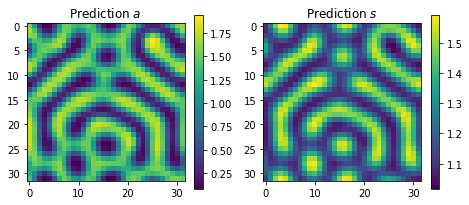

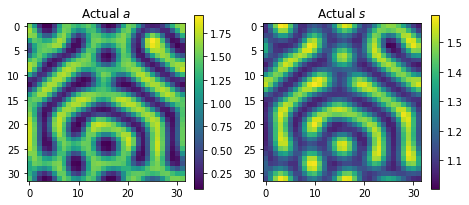

In [97]:
_ = plt.figure(figsize=(12,8))

plt.subplot(131)
plt.title(r"Prediction $a$")
plt.imshow(a_2)
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Prediction $s$")
plt.imshow(s_2)
plt.colorbar(shrink=.4)
plt.show()
_ = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title(r"Actual $a$")
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Actual $s$")
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.show()

In [98]:
graph = tf.get_default_graph()
tmp = graph.get_tensor_by_name("temp_a_t_1:0")
a_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_t_1:0")
s_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_a_diff_1:0")
a_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_diff_1:0")
s_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_kin_1:0")
kin = model.sess.run(tmp, tf_dict)

D_a = 0.005000, rho_a = 0.009493, mu_a = 0.009459971, sigma_a = 0.000000000, kappa_a = 0.2526


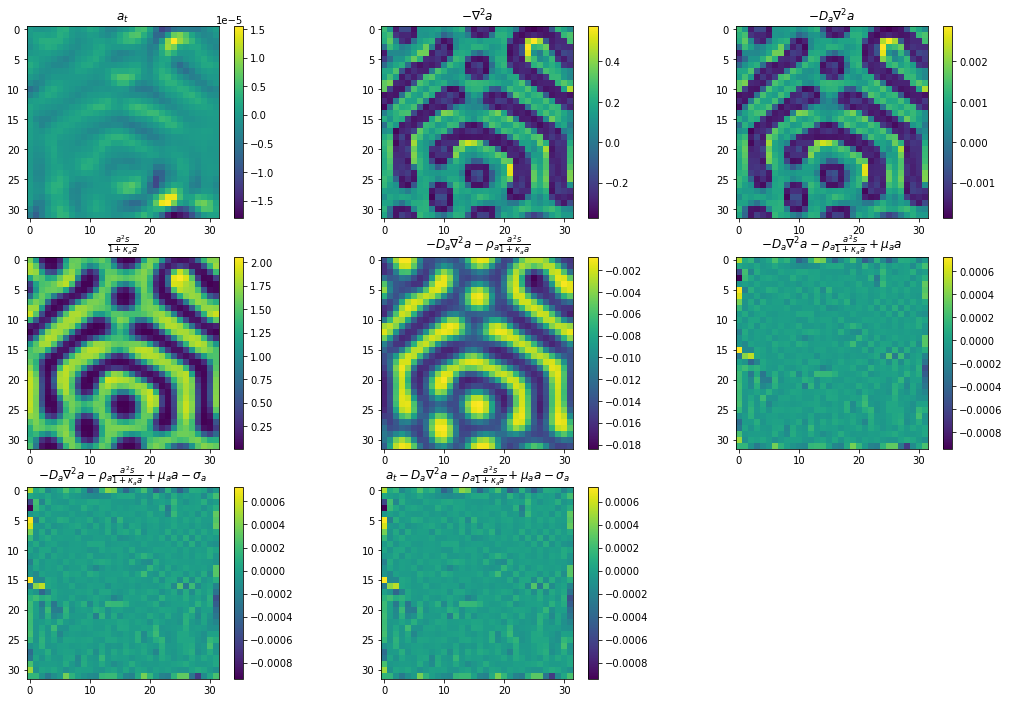

In [99]:
D_a = model.sess.run(model.D_a, tf_dict)
rho_a = model.sess.run(model.rho_a, tf_dict)
mu_a = model.sess.run(model.mu_a, tf_dict)
sigma_a = model.sess.run(model.sigma_a, tf_dict)
kappa_a = model.sess.run(model.kappa_a, tf_dict)[0]
print(f"D_a = {D_a:.6f}, rho_a = {rho_a[0]:.6f}, mu_a = {mu_a[0]:.9f}, sigma_a = {sigma_a:.9f}, kappa_a = {kappa_a:.4f}")

# a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$a_t$")
plt.imshow(a_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 a$")
plt.imshow((-a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_a \nabla^2 a$")
plt.imshow((-D_a*a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$ \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_a*a_diff-rho_a*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 8)
plt.title(r"$a_t-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((a_t-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()


In [ ]:
D_s = model.sess.run(model.D_s, tf_dict)
rho_s = model.sess.run(model.rho_s, tf_dict)
sigma_s = model.sess.run(model.sigma_s, tf_dict)
print(f"D_s = {D_s[0]:.6f}, rho_s = {rho_s:.6f}, sigma_s = {sigma_s[0]:.6f}, kappa_a = {kappa_a:.4f}")

# s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$s_t$")
plt.imshow(s_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 s$")
plt.imshow((-s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_s \nabla^2 s$")
plt.imshow((-D_s*s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$\frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_s*s_diff+rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((-D_s*s_diff+rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$s_t-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((s_t-D_s*s_diff+rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()

D_s = 0.212053, rho_s = 0.020000, sigma_s = 0.019938, kappa_a = 0.2526


# Estimated parameters for a failed attempt, when we used hyper-parameter $\lambda = 10$ for penalising the PDE loss.

# The overal loss was below 5.0

In [17]:

def print_vals(name, value, actual):
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/actual:0.8f}")
    
print(f"D_a: {model.sess.run(model.D_a):0.8f}, actual: 0.005, "
      f"difference: {np.abs(0.005-model.sess.run(model.D_a)):0.8f}, relative: %{100*np.abs(0.005-model.sess.run(model.D_a))/0.005:0.8f}")
print("---------------")
print_vals("D_s", model.sess.run(model.D_s)[0], 0.2)
print_vals("sigma_s", model.sess.run(model.sigma_s)[0], 0.02)
print_vals("rho_a", model.sess.run(model.rho_a)[0], 0.01)
print_vals("mu_a", model.sess.run(model.mu_a)[0], 0.01)
print_vals("kappa_a", model.sess.run(model.kappa_a)[0], 0.01)

D_a: 0.00500000, actual: 0.005, difference: 0.00000000, relative: %0.00000224
---------------
D_s: 0.00061816, actual: 0.200, difference: 0.19938184, relative: %99.69092073
sigma_s: 0.00086267, actual: 0.020, difference: 0.01913733, relative: %95.68665575
rho_a: 0.00137036, actual: 0.010, difference: 0.00862964, relative: %86.29636597
mu_a: 0.00000001, actual: 0.010, difference: 0.00999999, relative: %99.99990000
kappa_a: 24.27730179, actual: 0.010, difference: 24.26730179, relative: %242673.01788330


In [32]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [33]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00140679
Loss_s : 0.00002506
Loss   : 0.13586994


In [34]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

0.0852724278624469
0.03627897217908803


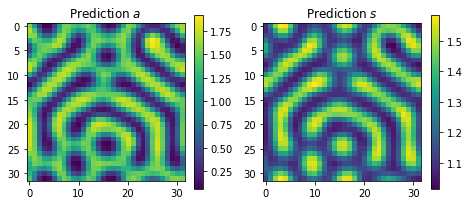

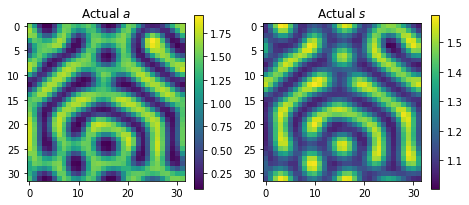

In [35]:
_ = plt.figure(figsize=(12,8))

plt.subplot(131)
plt.title(r"Prediction $a$")
plt.imshow(a_2)
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Prediction $s$")
plt.imshow(s_2)
plt.colorbar(shrink=.4)
plt.show()
_ = plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title(r"Actual $a$")
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.subplot(132)
plt.title(r"Actual $s$")
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.colorbar(shrink=.4)
plt.show()

In [36]:
graph = tf.get_default_graph()
tmp = graph.get_tensor_by_name("temp_a_t:0")
a_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_t:0")
s_t = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_a_diff:0")
a_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_s_diff:0")
s_diff = model.sess.run(tmp, tf_dict)
tmp = graph.get_tensor_by_name("temp_kin:0")
kin = model.sess.run(tmp, tf_dict)

D_a = 0.005000, rho_a = 0.001370, mu_a = 0.000000010, sigma_a = 0.000000000, kappa_a = 24.2773


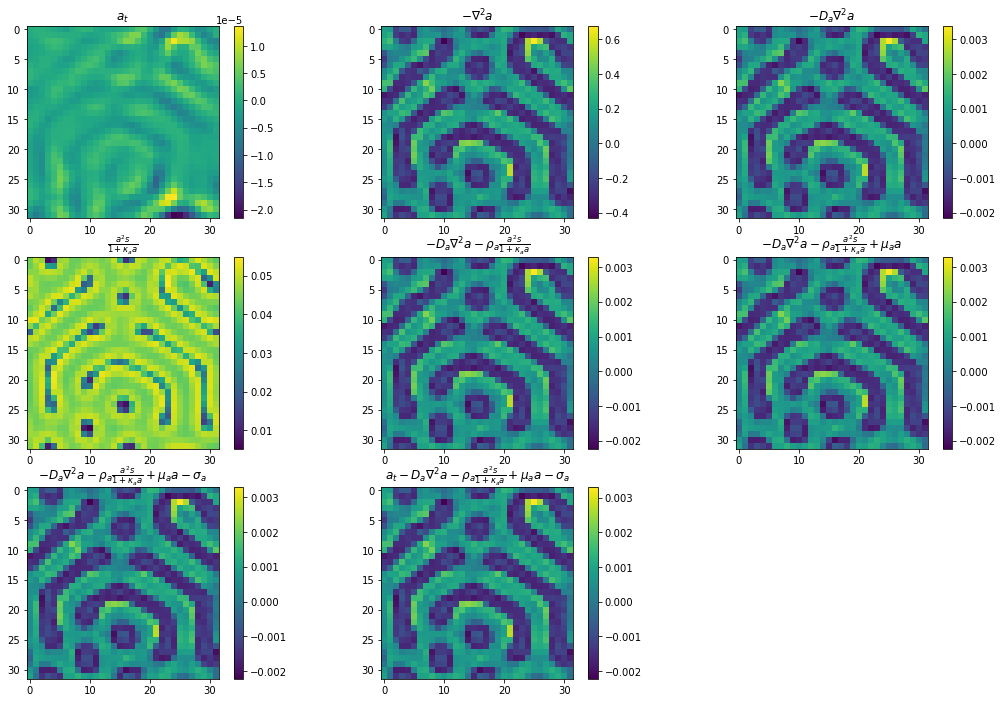

In [45]:
D_a = model.sess.run(model.D_a, tf_dict)
rho_a = model.sess.run(model.rho_a, tf_dict)
mu_a = model.sess.run(model.mu_a, tf_dict)
sigma_a = model.sess.run(model.sigma_a, tf_dict)
kappa_a = model.sess.run(model.kappa_a, tf_dict)[0]
print(f"D_a = {D_a:.6f}, rho_a = {rho_a[0]:.6f}, mu_a = {mu_a[0]:.9f}, sigma_a = {sigma_a:.9f}, kappa_a = {kappa_a:.4f}")

# a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$a_t$")
plt.imshow(a_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 a$")
plt.imshow((-a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_a \nabla^2 a$")
plt.imshow((-D_a*a_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$ \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_a*a_diff-rho_a*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 8)
plt.title(r"$a_t-D_a \nabla^2 a - \rho_a \frac{a^2 s}{1 + \kappa_a a} + \mu_a a - \sigma_a$")
plt.imshow((a_t-D_a*a_diff-rho_a*kin+mu_a*a_2.flatten()[:, np.newaxis]-sigma_a).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()


D_s = 0.000618, rho_s = 0.020000, sigma_s = 0.000863, kappa_a = 24.2773


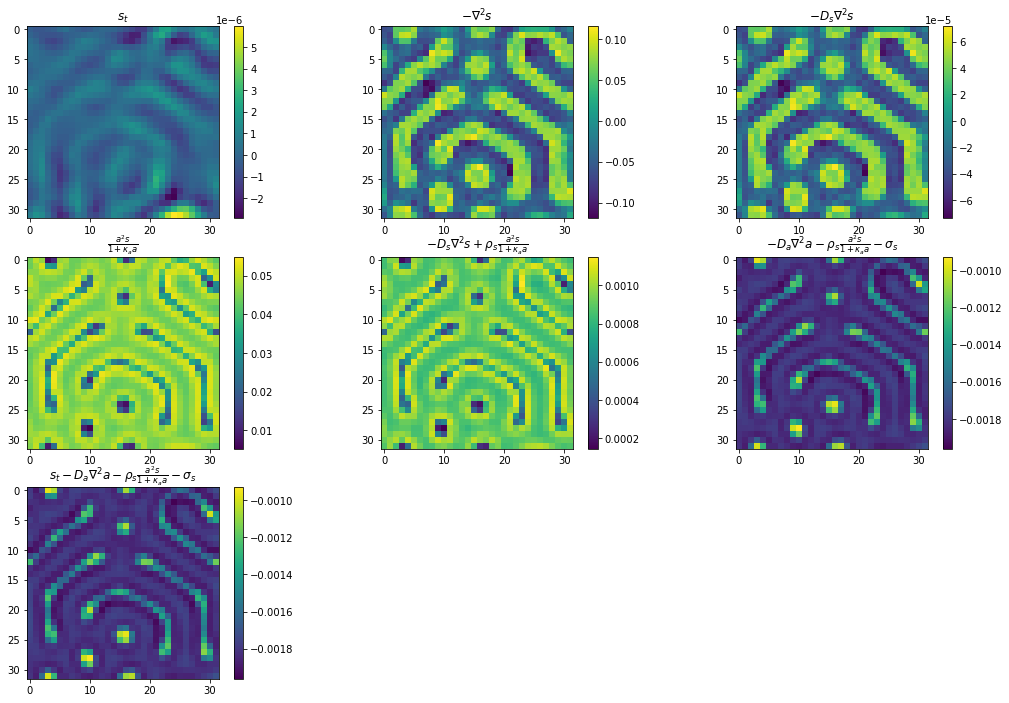

In [47]:
D_s = model.sess.run(model.D_s, tf_dict)
rho_s = model.sess.run(model.rho_s, tf_dict)
sigma_s = model.sess.run(model.sigma_s, tf_dict)
print(f"D_s = {D_s[0]:.6f}, rho_s = {rho_s:.6f}, sigma_s = {sigma_s[0]:.6f}, kappa_a = {kappa_a:.4f}")

# s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
plt.figure(figsize=(18,12))
plt.subplot(3, 3, 1)
plt.title(r"$s_t$")
plt.imshow(s_t.reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 2)
plt.title(r"$-\nabla^2 s$")
plt.imshow((-s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 3)
plt.title(r"$-D_s \nabla^2 s$")
plt.imshow((-D_s*s_diff).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 4)
plt.title(r"$\frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 5)
plt.title(r"$-D_s \nabla^2 s + \rho_s \frac{a^2 s}{1 + \kappa_a a}$")
plt.imshow((-D_s*s_diff+rho_s*kin).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 6)
plt.title(r"$-D_a \nabla^2 a - \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((-D_s*s_diff-rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.subplot(3, 3, 7)
plt.title(r"$s_t-D_a \nabla^2 a - \rho_s \frac{a^2 s}{1 + \kappa_a a} - \sigma_s$")
plt.imshow((s_t-D_s*s_diff-rho_s*kin-sigma_s).reshape((x_size,y_size)))
plt.colorbar(shrink=1)
plt.show()